In [1]:
import pandas as pd
import numpy as np
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import math
import shap
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)

### Read Data

In [2]:
## Read Clean Data From Folder
path = r'C_data'
db_dir = glob.glob(path + "/*.csv")

li = []

for i in db_dir:
    df = pd.read_csv(i, index_col=None, header=0)
    li.append(df)
ori_db = pd.concat(li, ignore_index=True)
wtpc = pd.read_csv('Design Capacity WTP.csv')
master_db = pd.merge(ori_db,wtpc[['wtp','Water Source','Lembangan']],on='wtp',how='left')
master_db['Date'] = pd.to_datetime(master_db['Date'])

### General Data Cleaning

In [3]:
## Define Outliers Removal Function
def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 1.5)
    upper_limit = s.mean() + (s.std() * 1.5)
    return ~s.between(lower_limit, upper_limit)

In [4]:
## Rate of change variables ("..._chpctm") vs agaisnt median value of respective WTP
tv = ['Disinfectant_chpctm','pH Adjuster_chpctm','Coagulant_chpctm']
idv = ['pH_avg_chpctm', 'Turbidity_avg_chpctm','Color_avg_chpctm', 'Iron_avg_chpctm', 'Ammonia_avg_chpctm', 'Manganese_avg_chpctm']
master_db[idv] = master_db[idv].fillna(0)
to_c5 = master_db.copy()
to_c5 = to_c5[tv+idv+['Lembangan','wtp','Date']].copy()
to_c5 = to_c5[~to_c5.isin([np.inf, -np.inf]).any(1)].copy()
to_c5 = to_c5.dropna()
ge2 = tv + idv

In [5]:
ge2

['Disinfectant_chpctm',
 'pH Adjuster_chpctm',
 'Coagulant_chpctm',
 'pH_avg_chpctm',
 'Turbidity_avg_chpctm',
 'Color_avg_chpctm',
 'Iron_avg_chpctm',
 'Ammonia_avg_chpctm',
 'Manganese_avg_chpctm']

In [6]:
opp = pd.DataFrame()
for i in ge2:
    
    if i==ge2[0]:
        m0 = to_c5[~to_c5.groupby(['Lembangan','wtp'])[i].apply(is_outlier)][['Lembangan','wtp',i,'Date']]
        opp = opp.append(m0)
    else:
        m1 = to_c5[~to_c5.groupby(['Lembangan','wtp'])[i].apply(is_outlier)][['Lembangan','wtp',i,'Date']]
        opp = pd.merge(opp,m1,on=['Lembangan','wtp','Date'],how='left')

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [7]:
opp

Lembangan                           wtp  Disinfectant_chpctm       Date  \
0     Sg Bernam  Bernam River Headworks (New)             0.000000 2021-04-01   
1     Sg Bernam  Bernam River Headworks (New)             0.000000 2021-04-02   
2     Sg Bernam  Bernam River Headworks (New)             0.000000 2021-04-03   
3     Sg Bernam  Bernam River Headworks (New)             0.000000 2021-04-04   
4     Sg Bernam  Bernam River Headworks (New)             0.000000 2021-04-05   
...         ...                           ...                  ...        ...   
6328   Sg Tengi                  Sungai Tengi            -4.204204 2021-09-26   
6329   Sg Tengi                  Sungai Tengi            -4.204204 2021-09-27   
6330   Sg Tengi                  Sungai Tengi            -4.204204 2021-09-28   
6331   Sg Tengi                  Sungai Tengi            -4.204204 2021-09-29   
6332   Sg Tengi                  Sungai Tengi            -4.204204 2021-09-30   

      pH Adjuster_chpctm  Coagulant_chpctm  pH_avg_chpctm  \
0              60.000000         95.439739      -0.312500   
1              60.000000         95.439739       1.406250   
2              60.000000         73.724213       2.343750   
3              60.000000        153.311618       2.187500   
4                    NaN        117.155266       1.250000   
...                  ...               ...            ...   
6328           16.987921               NaN      -0.175131   
6329           16.422513         25.260960      -7.530648   
6330           11.282447         -0.208768      -8.406305   
6331           11.282447        -16.492693      -6.129597   
6332          -14.417887        -26.931106      -5.429072   

      Turbidity_avg_chpctm  Color_avg_chpctm  Iron_avg_chpctm  \
0               -47.650931        -15.431349         2.797203   
1               -54.993191         -1.761847         6.293706   
2               -57.523831          3.280680         7.692308   
3                36.904222        143.803159              NaN   
4               -34.827508         47.812880         4.895105   
...                    ...               ...              ...   
6328                   NaN               NaN       -36.781609   
6329            109.539366        127.479064              NaN   
6330              7.154525         16.407739       -37.931034   
6331             13.622999         60.750794       -42.528736   
6332            -20.418164        -15.552989       -36.781609   

      Ammonia_avg_chpctm  Manganese_avg_chpctm  
0             -27.272727            -17.647059  
1             -45.454545            -41.176471  
2             -36.363636            -23.529412  
3              45.454545              0.000000  
4              18.181818              0.000000  
...                  ...                   ...  
6328                 NaN            160.000000  
6329            0.000000             20.000000  
6330          -23.529412             40.000000  
6331          -11.764706             80.000000  
6332          -29.411765              0.000000  

[6333 rows x 12 columns]

In [8]:
opp = opp.dropna()
opp.shape

(3913, 12)

## Modelling (Feature Importance)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sys import stdout
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble  import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

In [10]:
## Random Forest Optimization
def rfopt(Xr_train,y_train,Xr_test,y_test):
    score = {"fea":[],"rscore":[],"MSE":[]}
    max_depth = [10, 20, 30, 40]
    n_estimators = [100, 200, 300]
    for i in max_depth:
        
        for j in n_estimators:
            rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=j, max_depth=i, random_state=0)).fit(Xr_train, y_train)
            rs = round(rf.score(Xr_train,y_train)*100,2)
            rf_pr = rf.predict(Xr_test)
            ms = round(mean_squared_error(y_test,rf_pr),2)
            score["fea"].append(f"max_depth{i} n_est:{j}")
            score["rscore"].append(rs)
            score["MSE"].append(ms)
            del rf
            gc.collect()
    return score

## Sungai Langat

In [11]:
wwt = 'Sg Langat'
## Common Target
to_c7 = opp[opp['Lembangan']==wwt].copy()
y = to_c7[tv].copy()
X = to_c7[idv].copy()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [12]:
X_train

pH_avg_chpctm  Turbidity_avg_chpctm  Color_avg_chpctm  Iron_avg_chpctm  \
3048       1.369863            -18.872410          9.888889         9.090909   
3147       0.754148            176.104298        143.594849         1.428571   
2924       3.044140             14.377901          8.333333         0.000000   
2988       1.217656             76.485905         20.166667         0.000000   
3203       1.508296            325.884034        162.285942       -11.428571   
...             ...                   ...               ...              ...   
3278      -0.452489            -46.065008        -15.704235        -7.142857   
3345      -0.754148            -53.756400        -71.671313         4.285714   
2890       1.369863            -39.250538        -11.111111         9.090909   
3005       1.826484            -23.480131        -11.111111         0.000000   
2776       1.826484            -42.092154        -11.111111         0.000000   

      Ammonia_avg_chpctm  Manganese_avg_chpctm  
3048           42.372881              0.000000  
3147           38.235294             40.000000  
2924            1.694915             11.111111  
2988           16.949153             22.222222  
3203           23.529412             30.000000  
...                  ...                   ...  
3278           26.470588             10.000000  
3345          -26.470588            -10.000000  
2890           18.644068            -22.222222  
3005           44.067797              0.000000  
2776           27.118644             22.222222  

[664 rows x 6 columns]

In [13]:
y_train

Disinfectant_chpctm  pH Adjuster_chpctm  Coagulant_chpctm
3048             0.000000            0.555115          0.000000
3147            11.666667           -5.128205         11.029524
2924             0.000000           -0.158604          0.000000
2988             0.000000            0.713719          0.000000
3203             2.500000           -5.000000         16.047116
...                   ...                 ...               ...
3278            -6.111111           -3.333333         -1.086125
3345            -1.111111            7.820513          2.034572
2890             0.000000           -0.396511          0.000000
3005             0.000000            0.237906          0.000000
2776             0.000000            1.427439          0.000000

[664 rows x 3 columns]

In [14]:
rfoptsc = rfopt(X_train,y_train,X_test,y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

fea  rscore     MSE      Error
0   max_depth10 n_est:100   80.45  161.60  12.712199
1   max_depth10 n_est:200   80.51  159.29  12.621014
2   max_depth10 n_est:300   80.44  157.16  12.536347
3   max_depth20 n_est:100   89.85  162.25  12.737739
4   max_depth20 n_est:200   89.91  160.70  12.676750
5   max_depth20 n_est:300   89.94  158.21  12.578156
6   max_depth30 n_est:100   90.11  162.92  12.764012
7   max_depth30 n_est:200   90.20  160.48  12.668070
8   max_depth30 n_est:300   90.21  158.19  12.577361
9   max_depth40 n_est:100   90.11  162.59  12.751078
10  max_depth40 n_est:200   90.21  160.44  12.666491
11  max_depth40 n_est:300   90.22  158.39  12.585309

In [15]:
max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)
rfdic = [
rf.estimators_[0].feature_importances_,
rf.estimators_[1].feature_importances_,
rf.estimators_[2].feature_importances_]
rap = pd.DataFrame({'Feature':X_train.columns})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")

Feature  Disinfectant_chpctm  pH Adjuster_chpctm  \
0         pH_avg_chpctm             0.175274            0.118858   
1  Turbidity_avg_chpctm             0.132150            0.180394   
2      Color_avg_chpctm             0.116449            0.127104   
3       Iron_avg_chpctm             0.187947            0.136041   
4    Ammonia_avg_chpctm             0.274053            0.172840   
5  Manganese_avg_chpctm             0.114128            0.264763   

   Coagulant_chpctm  
0          0.098725  
1          0.383296  
2          0.136068  
3          0.160626  
4          0.119105  
5          0.102179

R Square Result 89.94%
MSE 158.21


## Sg Klang

In [16]:
wwt = 'Sg Klang'
## Common Target
to_c7 = opp[opp['Lembangan']==wwt].copy()
y = to_c7[tv].copy()
X = to_c7[idv].copy()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [17]:
rfoptsc = rfopt(X_train,y_train,X_test,y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

KeyboardInterrupt: 

In [ ]:
max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)
rfdic = [
rf.estimators_[0].feature_importances_,
rf.estimators_[1].feature_importances_,
rf.estimators_[2].feature_importances_]
rap = pd.DataFrame({'Feature':X_train.columns})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")

Feature  Disinfectant_chpctm  pH Adjuster_chpctm  \
0         pH_avg_chpctm             0.399854            0.255426   
1  Turbidity_avg_chpctm             0.161775            0.382469   
2      Color_avg_chpctm             0.116894            0.150343   
3       Iron_avg_chpctm             0.173466            0.101805   
4    Ammonia_avg_chpctm             0.130720            0.094535   
5  Manganese_avg_chpctm             0.017291            0.015422   

   Coagulant_chpctm  
0          0.212185  
1          0.432042  
2          0.238489  
3          0.060055  
4          0.053282  
5          0.003949

R Square Result 90.93%
MSE 165.31


## Sg Selangor

In [ ]:
wwt = 'Sg Selangor'
## Common Target
to_c7 = opp[opp['Lembangan']==wwt].copy()
y = to_c7[tv].copy()
X = to_c7[idv].copy()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [ ]:
rfoptsc = rfopt(X_train,y_train,X_test,y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

fea  rscore     MSE      Error
0   max_depth10 n_est:100   72.14  170.94  13.074402
1   max_depth10 n_est:200   72.35  171.56  13.098091
2   max_depth10 n_est:300   72.33  170.80  13.069047
3   max_depth20 n_est:100   87.47  177.03  13.305262
4   max_depth20 n_est:200   87.65  176.94  13.301880
5   max_depth20 n_est:300   87.71  176.18  13.273281
6   max_depth30 n_est:100   88.14  178.10  13.345411
7   max_depth30 n_est:200   88.37  177.62  13.327415
8   max_depth30 n_est:300   88.46  176.59  13.288717
9   max_depth40 n_est:100   88.13  177.40  13.319159
10  max_depth40 n_est:200   88.37  177.45  13.321036
11  max_depth40 n_est:300   88.45  176.75  13.294736

In [ ]:
max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)
rfdic = [
rf.estimators_[0].feature_importances_,
rf.estimators_[1].feature_importances_,
rf.estimators_[2].feature_importances_]
rap = pd.DataFrame({'Feature':X_train.columns})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")

Feature  Disinfectant_chpctm  pH Adjuster_chpctm  \
0         pH_avg_chpctm             0.160562            0.165902   
1  Turbidity_avg_chpctm             0.234119            0.236098   
2      Color_avg_chpctm             0.229019            0.220031   
3       Iron_avg_chpctm             0.151722            0.138945   
4    Ammonia_avg_chpctm             0.129025            0.152605   
5  Manganese_avg_chpctm             0.095553            0.086419   

   Coagulant_chpctm  
0          0.112566  
1          0.406530  
2          0.202706  
3          0.107897  
4          0.095559  
5          0.074742

R Square Result 87.71%
MSE 176.18


## Sg Semantan

In [ ]:
wwt = 'Sg Semantan'
## Common Target
to_c7 = opp[opp['Lembangan']==wwt].copy()
y = to_c7[tv].copy()
X = to_c7[idv].copy()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [ ]:
rfoptsc = rfopt(X_train,y_train,X_test,y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

fea  rscore     MSE      Error
0   max_depth10 n_est:100   92.33  234.35  15.308494
1   max_depth10 n_est:200   92.57  230.56  15.184202
2   max_depth10 n_est:300   92.66  233.98  15.296405
3   max_depth20 n_est:100   92.44  234.28  15.306208
4   max_depth20 n_est:200   92.74  232.15  15.236469
5   max_depth20 n_est:300   92.83  234.45  15.311760
6   max_depth30 n_est:100   92.44  234.24  15.304901
7   max_depth30 n_est:200   92.74  232.12  15.235485
8   max_depth30 n_est:300   92.83  234.46  15.312087
9   max_depth40 n_est:100   92.44  234.24  15.304901
10  max_depth40 n_est:200   92.74  232.12  15.235485
11  max_depth40 n_est:300   92.83  234.46  15.312087

In [ ]:
max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)
rfdic = [
rf.estimators_[0].feature_importances_,
rf.estimators_[1].feature_importances_,
rf.estimators_[2].feature_importances_]
rap = pd.DataFrame({'Feature':X_train.columns})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")

Feature  Disinfectant_chpctm  pH Adjuster_chpctm  \
0         pH_avg_chpctm             0.101477            0.198384   
1  Turbidity_avg_chpctm             0.198466            0.087250   
2      Color_avg_chpctm             0.198212            0.168066   
3       Iron_avg_chpctm             0.377428            0.447788   
4    Ammonia_avg_chpctm             0.041385            0.042310   
5  Manganese_avg_chpctm             0.083032            0.056202   

   Coagulant_chpctm  
0          0.251226  
1          0.376016  
2          0.081647  
3          0.167994  
4          0.061462  
5          0.061656

R Square Result 92.83%
MSE 234.45


## Sg Tengi

In [ ]:
wwt = 'Sg Tengi'
## Common Target
to_c7 = opp[opp['Lembangan']==wwt].copy()
y = to_c7[tv].copy()
X = to_c7[idv].copy()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [ ]:
rfoptsc = rfopt(X_train,y_train,X_test,y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

fea  rscore     MSE      Error
0   max_depth10 n_est:100   92.34  183.27  13.537725
1   max_depth10 n_est:200   92.26  182.34  13.503333
2   max_depth10 n_est:300   92.42  183.36  13.541049
3   max_depth20 n_est:100   92.73  185.76  13.629380
4   max_depth20 n_est:200   92.73  183.45  13.544372
5   max_depth20 n_est:300   92.86  184.48  13.582341
6   max_depth30 n_est:100   92.73  185.75  13.629013
7   max_depth30 n_est:200   92.73  183.44  13.544002
8   max_depth30 n_est:300   92.86  184.47  13.581973
9   max_depth40 n_est:100   92.73  185.75  13.629013
10  max_depth40 n_est:200   92.73  183.44  13.544002
11  max_depth40 n_est:300   92.86  184.47  13.581973

In [ ]:
max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)
rfdic = [
rf.estimators_[0].feature_importances_,
rf.estimators_[1].feature_importances_,
rf.estimators_[2].feature_importances_]
rap = pd.DataFrame({'Feature':X_train.columns})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")

Feature  Disinfectant_chpctm  pH Adjuster_chpctm  \
0         pH_avg_chpctm             0.133225            0.344711   
1  Turbidity_avg_chpctm             0.154190            0.229853   
2      Color_avg_chpctm             0.257187            0.255153   
3       Iron_avg_chpctm             0.221609            0.065914   
4    Ammonia_avg_chpctm             0.170508            0.060554   
5  Manganese_avg_chpctm             0.063282            0.043816   

   Coagulant_chpctm  
0          0.043770  
1          0.802068  
2          0.078252  
3          0.039759  
4          0.025471  
5          0.010679

R Square Result 92.86%
MSE 184.48


## Sg Bernam

In [ ]:
wwt = 'Sg Bernam'
## Common Target
to_c7 = opp[opp['Lembangan']==wwt].copy()
y = to_c7[tv].copy()
X = to_c7[idv].copy()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [ ]:
rfoptsc = rfopt(X_train,y_train,X_test,y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

fea  rscore     MSE      Error
0   max_depth10 n_est:100   88.12  600.92  24.513670
1   max_depth10 n_est:200   88.22  612.22  24.743080
2   max_depth10 n_est:300   88.21  613.03  24.759443
3   max_depth20 n_est:100   93.19  608.65  24.670833
4   max_depth20 n_est:200   93.30  617.98  24.859204
5   max_depth20 n_est:300   93.35  616.24  24.824182
6   max_depth30 n_est:100   93.25  608.61  24.670022
7   max_depth30 n_est:200   93.36  618.35  24.866644
8   max_depth30 n_est:300   93.39  617.15  24.842504
9   max_depth40 n_est:100   93.25  608.61  24.670022
10  max_depth40 n_est:200   93.36  618.35  24.866644
11  max_depth40 n_est:300   93.39  617.15  24.842504

In [ ]:
max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)
rfdic = [
rf.estimators_[0].feature_importances_,
rf.estimators_[1].feature_importances_,
rf.estimators_[2].feature_importances_]
rap = pd.DataFrame({'Feature':X_train.columns})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")

Feature  Disinfectant_chpctm  pH Adjuster_chpctm  \
0         pH_avg_chpctm             0.600322            0.628616   
1  Turbidity_avg_chpctm             0.097559            0.054892   
2      Color_avg_chpctm             0.095286            0.141395   
3       Iron_avg_chpctm             0.085590            0.057930   
4    Ammonia_avg_chpctm             0.061638            0.078290   
5  Manganese_avg_chpctm             0.059605            0.038878   

   Coagulant_chpctm  
0          0.260493  
1          0.124362  
2          0.349935  
3          0.109993  
4          0.084674  
5          0.070543

R Square Result 93.35%
MSE 616.24


## General

In [ ]:
to_c7 = opp.copy()
to_c7.shape
## Common Target
y = to_c7[tv].copy()
X = to_c7[idv].copy()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=88)

(3913, 12)

In [ ]:
rfoptsc = rfopt(X_train,y_train,X_test,y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

fea  rscore     MSE      Error
0   max_depth10 n_est:100   59.33  238.91  15.456714
1   max_depth10 n_est:200   59.48  238.34  15.438264
2   max_depth10 n_est:300   59.58  237.57  15.413306
3   max_depth20 n_est:100   85.60  238.87  15.455420
4   max_depth20 n_est:200   85.86  237.53  15.412008
5   max_depth20 n_est:300   85.99  237.17  15.400325
6   max_depth30 n_est:100   89.62  240.14  15.496451
7   max_depth30 n_est:200   89.90  238.37  15.439236
8   max_depth30 n_est:300   90.01  237.43  15.408764
9   max_depth40 n_est:100   89.83  239.72  15.482894
10  max_depth40 n_est:200   90.10  238.69  15.449595
11  max_depth40 n_est:300   90.21  237.94  15.425304

In [ ]:
max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)
rfdic = [
rf.estimators_[0].feature_importances_,
rf.estimators_[1].feature_importances_,
rf.estimators_[2].feature_importances_]

In [ ]:
rap = pd.DataFrame({'Feature':X_train.columns})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")

Feature  Disinfectant_chpctm  pH Adjuster_chpctm  \
0         pH_avg_chpctm             0.219462            0.365170   
1  Turbidity_avg_chpctm             0.187635            0.133518   
2      Color_avg_chpctm             0.151427            0.168363   
3       Iron_avg_chpctm             0.185217            0.118387   
4    Ammonia_avg_chpctm             0.135053            0.107841   
5  Manganese_avg_chpctm             0.121206            0.106720   

   Coagulant_chpctm  
0          0.297001  
1          0.182234  
2          0.253083  
3          0.086216  
4          0.089393  
5          0.092073

R Square Result 85.99%
MSE 237.17


In [ ]:
## User Defined Weightage for each Chemical Products

## General Random Method
weight = np.array([0.3, 0.3, 0.4])

## Weightage Based on Cost
weight_c = np.array([0.395, 0.1224, 0.4826])

## Weightage Based on Dosing 
weight_d = np.array([0.1064, 0.1969, 0.6967])

In [ ]:
## Refined Weightage
fw = RDF.iloc[:,1:].dot(weight_d)
fwc = RDF.iloc[:,1:].dot(weight_c)
#fwd = RDF.iloc[:,1:].dot(weight_d) # (Will be focus on this as user has agreed on this weightage)

## New Computation - Ikmal

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sys import stdout
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble  import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import glob

path = r'CP_data'
db_dir = glob.glob(path + "/*.csv")

jam3 = pd.concat([pd.read_csv(file, index_col=None, header=0) for file in db_dir])
jam3 = jam3.drop('Unnamed: 0', axis=1)
# define the conditions
condition = (jam3['wtp'] == 'Kuala Kubu Bharu') | (jam3['wtp'] == 'Batang Kali')| (jam3['wtp'] == 'Sungai Rangkap')

# use loc to update the values
jam3.loc[condition, 'Lembangan'] = 'Sungai Selangor Upstream'
jam3 = pd.concat([jam3, pd.get_dummies(jam3['Lembangan'])], axis=1)

jam4 = jam3[(jam3['wtp'] != 'Sungai Selangor Fasa 2 Stream C') & (jam3['wtp'] != 'Bukit Tampoi New')].copy()

idv = ['pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg']
exclude = ['Month', 'Quarter', 'Water Source', 'Lembangan', 'wtp', 'date', 'Date',
           'Liquid Chlorine (Pre)', 'Liquid Chlorine (Intermediate)', 'Liquid Chlorine (Post)',
           'Hydrated Lime (Intermediate)', 'Hydrated Lime (Powder) (Pre)', 'Hydrated Lime (Powder) (Post)',
           'Hydrated Lime (Post) (mg/L)', 'Liquid Chlorine (Post) (mg/L)', 'Liquid Chlorine (Pre) (mg/L)',
           'Hydrated Lime (Pre) (mg/L)', 'Hydrated Lime (Pre)', 'Hydrated Lime (Post)', 'Soda Ash (Pre)',
           'Soda Ash (Post)', 'Soda_Ash_T', 'Hydrated_Lime_T', 'Hydrated_Lime_Pow_T', 'Liquid_Chlorine_T',
           'Hydrated_Lime_T_Pow']

tv = [col for col in jam4.columns if col not in idv and col not in exclude]

jam4[tv] = jam4[tv].fillna(0)

X = jam4[idv].copy()
y = jam4[tv].copy()

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

## Random Forest Optimization
def rfopt(Xr_train, y_train, Xr_test, y_test):
    score = {"fea":[],"rscore":[],"MSE":[]}
    max_depth = [10]
    n_estimators = [100]
    for i in max_depth:
        for j in n_estimators:
            rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=j, max_depth=i, random_state=0)).fit(Xr_train, y_train)
            rs = round(rf.score(Xr_train,y_train)*100,2)
            rf_pr = rf.predict(Xr_test)
            ms = round(mean_squared_error(y_test,rf_pr),2)
            score["fea"].append(f"max_depth{i} n_est:{j}")
            score["rscore"].append(rs)
            score["MSE"].append(ms)
            del rf
            gc.collect()
    return score

rfoptsc = rfopt(X_train, y_train, X_test, y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)

rfdic = [rf.estimators_[i].feature_importances_ for i in range(len(rf.estimators_))]

rap = pd.DataFrame({'Feature': idv})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")


fea  rscore   MSE     Error
0  max_depth10 n_est:100    94.8  2.05  1.431782

Feature  Kibbled Aluminium Sulphate  Flopam FA 920 PWG  \
0         pH_avg                    0.119288           0.179037   
1  Turbidity_avg                    0.210365           0.377299   
2      Color_avg                    0.177892           0.116533   
3       Iron_avg                    0.244264           0.200187   
4    Ammonia_avg                    0.131626           0.037589   
5  Manganese_avg                    0.116566           0.089355   

   Liquid Chlorine  Sodium Silico Fluoride  Liquid Aluminium Sulphate  \
0         0.194421                0.187577                   0.241703   
1         0.162258                0.172584                   0.123898   
2         0.229795                0.175157                   0.189695   
3         0.145690                0.218941                   0.180163   
4         0.194625                0.194325                   0.195874   
5         0.073211                0.051415                   0.068668   

   Soda Ash  Hydrated Lime  Liquid Polyaluminium Chloride  \
0  0.108098       0.218347                       0.498968   
1  0.072438       0.083311                       0.049623   
2  0.483124       0.127972                       0.131722   
3  0.076109       0.163441                       0.083048   
4  0.034122       0.332906                       0.104410   
5  0.226109       0.074024                       0.132228   

   Sodium Aluminosilicate  Sodium Fluoride  Superfloc C 591 PWG  \
0                     0.0         0.184789             0.879501   
1                     0.0         0.071947             0.015753   
2                     0.0         0.046601             0.019149   
3                     0.0         0.283619             0.021686   
4                     0.0         0.310066             0.054604   
5                     0.0         0.102977             0.009307   

   Aluminium Chlorohydrate  Flopam AH 912 PWG  Hydrated Lime (Powder)  \
0                 0.752319           0.045726                     0.0   
1                 0.038271           0.129829                     0.0   
2                 0.017813           0.087559                     0.0   
3                 0.040767           0.201432                     0.0   
4                 0.142371           0.500124                     0.0   
5                 0.008459           0.035331                     0.0   

   Flopam FO 4190 PWG  Flopam FO 4290 PWG  Polyelectrolyte AN 910 PWG  \
0                 0.0                 0.0                         0.0   
1                 0.0                 0.0                         0.0   
2                 0.0                 0.0                         0.0   
3                 0.0                 0.0                         0.0   
4                 0.0                 0.0                         0.0   
5                 0.0                 0.0                         0.0   

   Microsand  Activated Carbon  Flopam FL 4520 PWG  Modified Liquid Alum  \
0        0.0               0.0                 0.0              0.004635   
1        0.0               0.0                 0.0              0.152872   
2        0.0               0.0                 0.0              0.298258   
3        0.0               0.0                 0.0              0.521500   
4        0.0               0.0                 0.0              0.005457   
5        0.0               0.0                 0.0              0.017278   

   Potassium Permanganate  Polymer Tianfloc C3080  Sodium Hypochlorite  \
0                     0.0                0.336908             0.708962   
1                     0.0                0.047966             0.019325   
2                     0.0                0.211832             0.025846   
3                     0.0                0.145675             0.242288   
4                     0.0                0.109410             0.002944   
5                     0.0                0.148210             0.000635   

   Liquid Polyaluminium Chloride (mg/L)  \
0         

R Square Result 96.89%
MSE 1.95


### Testing other algorithm

In [962]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sys import stdout
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble  import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
import pandas as pd
import numpy as np
import glob

path = r'CP_data'
db_dir = glob.glob(path + "/*.csv")

jam3 = pd.concat([pd.read_csv(file, index_col=None, header=0) for file in db_dir])
jam3 = jam3.drop('Unnamed: 0', axis=1)
# define the conditions for sungai selangor upstream reclassification
condition = (jam3['wtp'] == 'Kuala Kubu Bharu') | (jam3['wtp'] == 'Batang Kali')| (jam3['wtp'] == 'Sungai Rangkap')

# use loc to update the values
jam3.loc[condition, 'Lembangan'] = 'Sg Selangor Upstream'
jam3 = pd.concat([jam3, pd.get_dummies(jam3['Lembangan'])], axis=1)

jam4 = jam3[(jam3['wtp'] != 'Sungai Selangor Fasa 2 Stream C') & (jam3['wtp'] != 'Bukit Tampoi New')].copy()

#select the lembangan
jam4 = jam4[jam4['Lembangan'] == 'Sg Tengi']

idv = ['pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg']
exclude = ['Month', 'Quarter', 'Water Source', 'Lembangan', 'wtp', 'date', 'Date',
           'Liquid Chlorine (Pre)', 'Liquid Chlorine (Intermediate)', 'Liquid Chlorine (Post)',
           'Hydrated Lime (Intermediate)', 'Hydrated Lime (Powder) (Pre)', 'Hydrated Lime (Powder) (Post)',
           'Hydrated Lime (Post) (mg/L)', 'Liquid Chlorine (Post) (mg/L)', 'Liquid Chlorine (Pre) (mg/L)',
           'Hydrated Lime (Pre) (mg/L)', 'Hydrated Lime (Pre)', 'Hydrated Lime (Post)', 'Soda Ash (Pre)',
           'Soda Ash (Post)', 'Soda_Ash_T', 'Hydrated_Lime_T', 'Hydrated_Lime_Pow_T', 'Liquid_Chlorine_T',
           'Hydrated_Lime_T_Pow']

tv = [col for col in jam4.columns if col not in idv and col not in exclude]

jam4[tv] = jam4[tv].fillna(0)

X = jam4[idv].copy()
y = jam4[tv].copy()

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

## Random Forest Optimization
def rfopt(Xr_train, y_train, Xr_test, y_test):
    score = {"fea":[],"rscore":[],"MSE":[]}
    max_depth = [10]
    n_estimators = [100]
    for i in max_depth:
        for j in n_estimators:
            rf = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=j, max_depth=i, random_state=0)).fit(Xr_train, y_train)
            rs = round(rf.score(Xr_train,y_train)*100,2)
            rf_pr = rf.predict(Xr_test)
            ms = round(mean_squared_error(y_test,rf_pr),2)
            score["fea"].append(f"max_depth{i} n_est:{j}")
            score["rscore"].append(rs)
            score["MSE"].append(ms)
            del rf
            gc.collect()
    return score

rfoptsc = rfopt(X_train, y_train, X_test, y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

max_depth = 20
rf = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)

rfdic = [rf.estimators_[i].feature_importances_ for i in range(len(rf.estimators_))]

rap = pd.DataFrame({'Feature': idv})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")


fea  rscore   MSE     Error
0  max_depth10 n_est:100   99.75  0.11  0.331662

Feature  Kibbled Aluminium Sulphate  Flopam FA 920 PWG  \
0         pH_avg                    0.037225                0.0   
1  Turbidity_avg                    0.467782                0.0   
2      Color_avg                    0.349062                0.0   
3       Iron_avg                    0.028587                0.0   
4    Ammonia_avg                    0.039723                0.0   
5  Manganese_avg                    0.077621                0.0   

   Liquid Chlorine  Sodium Silico Fluoride  Liquid Aluminium Sulphate  \
0         0.201406                     0.0                        0.0   
1         0.118502                     0.0                        0.0   
2         0.178175                     0.0                        0.0   
3         0.173424                     0.0                        0.0   
4         0.152193                     0.0                        0.0   
5         0.176299                     0.0                        0.0   

   Soda Ash  Hydrated Lime  Liquid Polyaluminium Chloride  \
0       0.0            0.0                            0.0   
1       0.0            0.0                            0.0   
2       0.0            0.0                            0.0   
3       0.0            0.0                            0.0   
4       0.0            0.0                            0.0   
5       0.0            0.0                            0.0   

   Sodium Aluminosilicate  Sodium Fluoride  Superfloc C 591 PWG  \
0                     0.0         0.149989                  0.0   
1                     0.0         0.055190                  0.0   
2                     0.0         0.094965                  0.0   
3                     0.0         0.312641                  0.0   
4                     0.0         0.260340                  0.0   
5                     0.0         0.126876                  0.0   

   Aluminium Chlorohydrate  Flopam AH 912 PWG  Hydrated Lime (Powder)  \
0                      0.0                0.0                     0.0   
1                      0.0                0.0                     0.0   
2                      0.0                0.0                     0.0   
3                      0.0                0.0                     0.0   
4                      0.0                0.0                     0.0   
5                      0.0                0.0                     0.0   

   Flopam FO 4190 PWG  Flopam FO 4290 PWG  Polyelectrolyte AN 910 PWG  \
0                 0.0                 0.0                         0.0   
1                 0.0                 0.0                         0.0   
2                 0.0                 0.0                         0.0   
3                 0.0                 0.0                         0.0   
4                 0.0                 0.0                         0.0   
5                 0.0                 0.0                         0.0   

   Microsand  Activated Carbon  Flopam FL 4520 PWG  Modified Liquid Alum  \
0        0.0               0.0                 0.0                   0.0   
1        0.0               0.0                 0.0                   0.0   
2        0.0               0.0                 0.0                   0.0   
3        0.0               0.0                 0.0                   0.0   
4        0.0               0.0                 0.0                   0.0   
5        0.0               0.0                 0.0                   0.0   

   Potassium Permanganate  Polymer Tianfloc C3080  Sodium Hypochlorite  \
0                     0.0                     0.0                  0.0   
1                     0.0                     0.0                  0.0   
2                     0.0                     0.0                  0.0   
3                     0.0                     0.0                  0.0   
4                     0.0                     0.0                  0.0   
5                     0.0                     0.0                  0.0   

   Liquid Polyaluminium Chloride (mg/L)  \
0         

R Square Result 100.0%
MSE 0.1


In [187]:
#jam4['Soda_Ash'] = jam4.apply(lambda row: row['Soda_Ash_T'] + row['Soda Ash'], axis=1)
#jam4['Liquid_Chlorine'] = jam4.apply(lambda row: row['Liquid_Chlorine_T'] + row['Liquid Chlorine'], axis=1)
#jam4['Liquid_Polyaluminium_Chloride'] = jam4.apply(lambda row: row['Liquid Polyaluminium Chloride (mg/L)'] + row['Liquid Polyaluminium Chloride'], axis=1)

### Using CV to overcome overfit issue

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sys import stdout
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble  import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np
import glob


path = r'CP_data'
db_dir = glob.glob(path + "/*.csv")

jam3 = pd.read_csv('CP_data\ChemPare_SgSel.csv', index_col=None, header=0)
jam3 = jam3.drop('Unnamed: 0', axis=1)
# define the conditions for sungai selangor upstream reclassification
#condition = (jam3['wtp'] == 'Kuala Kubu Bharu') | (jam3['wtp'] == 'Batang Kali')| (jam3['wtp'] == 'Sungai Rangkap')

# use loc to update the values
# jam3.loc[condition, 'Lembangan'] = 'Sg Selangor Upstream'

wtp_exclude_lst = ['Bernam River Headworks (Old)',
 'Bukit Tampoi New',
 'Salak Tinggi',
 'Sungai Serai',
 'Bernam River Headworks (New)']

jam4 = jam3.copy().fillna(0)

for i in wtp_exclude_lst:
    jam4 = jam4[(jam4['wtp'] != i) ]
#select the lembangan
jam4 = jam4[jam4['Lembangan'] == 'Sg Selangor']
jam4['Soda_Ash'] = jam4.apply(lambda row: row['Soda_Ash_T'] + row['Soda Ash'], axis=1)
jam4['Liquid_Chlorine'] = jam4.apply(lambda row: row['Liquid_Chlorine_T'] + row['Liquid Chlorine'], axis=1)
jam4['Liquid_Polyaluminium_Chloride'] = jam4.apply(lambda row: row['Liquid Polyaluminium Chloride (mg/L)'] + row['Liquid Polyaluminium Chloride'], axis=1)
jam4['Hydrated_Lime'] = jam4.apply(lambda row: row['Hydrated Lime'] + row['Hydrated_Lime_Pow_T'], axis=1)
jam4['Aluminium_Sulphate'] = jam4.apply(lambda row: row['Liquid Aluminium Sulphate'] + row['Kibbled Aluminium Sulphate'], axis=1)
jam4['Sodium_Silico_Fluoride'] = jam4.apply(lambda row: row['Sodium Silico Fluoride'] + row['Sodium Silico Fluoride (mg/L)'], axis=1)

jam4 = jam4.drop(['Sodium Aluminosilicate','Flopam FA 920 PWG','Raw Water Polyelectrolyte 4290 PWG / 4190 PWG / AN910 (mg/L)','Flopam FO 4290 PWG','Sodium_Silico_Fluoride','Microsand','Sodium Silico Fluoride (mg/L)','Sodium Silico Fluoride','Kibbled Aluminium Sulphate','Liquid Aluminium Sulphate','Hydrated Lime','Hydrated_Lime_Pow_T','Soda_Ash_T','Soda Ash','Liquid_Chlorine_T','Liquid Chlorine','Liquid Polyaluminium Chloride (mg/L)','Liquid Polyaluminium Chloride'],axis = 1)
jam4 = pd.concat([jam4, pd.get_dummies(jam4['wtp'])], axis=1)

idv = ['pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg']
exclude = ['Month', 'Quarter', 'Water Source', 'Lembangan', 'wtp', 'Date']

tv = [col for col in jam4.columns if col not in idv and col not in exclude]

jam4[tv] = jam4[tv].fillna(0)

# MLD_dict = {'Batang Kali':17,
#        'Kuala Kubu Bharu':22, 'Rasa':809,
#         'Rantau Panjang New':120, 'Rantau Panjang Old':120, 'Sungai Rangkap':23,
#        'Sungai Selangor Fasa 1':3501, 'Sungai Selangor Fasa 3':3074,'Sungai Selangor Fasa 2 Stream C':3617}

# jam4_i = jam4.copy()
# for key, value in MLD_dict.items():
#     # Check if the key is in the DataFrame
#     if key in jam4_i['wtp'].tolist():
#         # Set the value in the new column where the feature matches the key
#         jam4_i.loc[jam4_i['wtp'] == key, 'MLD'] = value

# chem = [
#         'Soda_Ash',
#         'Liquid_Chlorine',
#         'Liquid_Polyaluminium_Chloride',
#         'Hydrated_Lime',
#         'Aluminium_Sulphate']

# for i in chem:
#     jam4_i[i] = jam4_i[i]/jam4_i['MLD']

# jam4_i = jam4_i.drop('MLD',axis = 1)

X = jam4[idv].copy()
y = jam4[tv].copy()

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)



In [ ]:
#Random Forest Optimization
def rfopt(Xr_train, y_train, Xr_test, y_test,X,y):
    score = {"fea":[],"CV_mean_MSE":[],"CV_mean_rscore":[]}
    max_depth = [10,50,80]
    n_estimators = [10,50,100]
    scoring = ['neg_root_mean_squared_error', 'r2']
    for i in max_depth:
        for j in n_estimators:
            rf = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=j, max_depth=i, random_state=0))#.fit(Xr_train, y_train)
            
            cv_results = cross_validate(rf, X, y, cv=10, scoring=scoring, return_train_score=False)
            #rs = round(rf.score(Xr_train,y_train)*100,2)
            #rf_pr = rf.predict(Xr_test)
            #ms = round(mean_squared_error(y_test,rf_pr),2)
            score["fea"].append(f"max_depth{i} n_est:{j}")
            #score["rscore"].append(rs)
            #score["MSE"].append(ms)
            score['CV_mean_MSE'].append(round(-np.mean(cv_results["test_neg_root_mean_squared_error"]), 2))
            score['CV_mean_rscore'].append(round(np.mean(cv_results["test_r2"]), 2))
            del rf
            gc.collect()
    return score

rfoptsc = rfopt(X_train, y_train, X_test, y_test,X,y)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['CV_mean_MSE'])
cal



'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs

fea  CV_mean_MSE  CV_mean_rscore     Error
0  max_depth1 n_est:1         3.29          -32.13  1.813836

In [ ]:
cal[cal['CV_mean_rscore'] > 0.84]

Empty DataFrame
Columns: [fea, CV_mean_MSE, CV_mean_rscore, Error]
Index: []

In [ ]:
jam4

wtp  pH_avg        Date  Turbidity_avg  Color_avg  \
0                Batang Kali    6.77  2021-04-01          28.75       4.96   
1                Batang Kali    6.65  2021-04-02           5.67       0.42   
2                Batang Kali    6.61  2021-04-03          14.72       0.42   
3                Batang Kali    6.60  2021-04-04           9.50       3.42   
4                Batang Kali    6.61  2021-04-05           9.01       0.17   
...                      ...     ...         ...            ...        ...   
2999  Sungai Selangor Fasa 3    5.63  2021-09-26         237.78      31.17   
3000  Sungai Selangor Fasa 3    5.52  2021-09-27         196.33      31.92   
3001  Sungai Selangor Fasa 3    5.54  2021-09-28         192.42      32.25   
3002  Sungai Selangor Fasa 3    5.54  2021-09-29         263.42      26.00   
3003  Sungai Selangor Fasa 3    5.55  2021-09-30         124.68      34.25   

      Iron_avg  Ammonia_avg  Manganese_avg  Month  Sodium Aluminosilicate  \
0         0.26         0.28           0.02      4                     0.0   
1         0.22         0.12           0.02      4                     0.0   
2         0.13         0.22           0.02      4                     0.0   
3         0.22         0.47           0.04      4                     0.0   
4         0.14         0.15           0.02      4                     0.0   
...        ...          ...            ...    ...                     ...   
2999      2.98         0.17           0.46      9                     0.0   
3000      2.64         0.15           0.55      9                     0.0   
3001      1.89         0.20           0.38      9                     0.0   
3002      2.63         0.24           0.57      9                     0.0   
3003      1.58         0.10           0.32      9                     0.0   

        Lembangan  Soda_Ash  Liquid_Chlorine  Liquid_Polyaluminium_Chloride  \
0     Sg Selangor      1.05         2.380000                       0.000000   
1     Sg Selangor      1.01         2.360000                       0.000000   
2     Sg Selangor      0.98         2.260000                       0.000000   
3     Sg Selangor      1.03         2.360000                       0.000000   
4     Sg Selangor      1.05         2.350000                       0.000000   
...           ...       ...              ...                            ...   
2999  Sg Selangor      0.00         6.042845                      37.260145   
3000  Sg Selangor      0.00         6.514619                      41.511501   
3001  Sg Selangor      0.00         5.035667                      36.873714   
3002  Sg Selangor      0.00         5.355148                      41.047287   
3003  Sg Selangor      0.00         5.266567                      43.483007   

      Hydrated_Lime  Aluminium_Sulphate  Batang Kali  Kuala Kubu Bharu  \
0          0.000000               14.23            1                 0   
1          0.000000               13.33            1                 0   
2          0.000000               16.47            1                 0   
3          0.000000               16.32            1                 0   
4          0.000000               17.09            1                 0   
...             ...                 ...          ...               ...   
2999       8.515733                0.00            0                 0   
3000       8.710183                0.00            0                 0   
3001       8.627555                0.00            0                 0   
3002       8.724761                0.00            0                 0   
3003       8.167570                0.00            0                 0   

      Rantau Panjang New  Rantau Panjang Old  Rasa  Sungai Rangkap  \
0                      0                   0     0               0   
1                      0                   0     0               0   
2                      0                   0     0               0   
3                      0                   0 

In [ ]:
max_depth = 50
rf = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=100, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_2 = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=100, max_depth=max_depth, random_state=0))
rf_pr = rf.predict(X_test)

rfdic = [rf.estimators_[i].feature_importances_ for i in range(len(rf.estimators_))]

scoring = ['neg_root_mean_squared_error', 'r2']
cv_results = cross_validate(rf_2, X, y, cv=10, scoring=scoring, return_train_score=False)

rap = pd.DataFrame({'Feature': idv})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF


# Print results
print(f'CV Mean RMSE: {round(-np.mean(cv_results["test_neg_root_mean_squared_error"]), 2)}')
print(f'CV RMSE Std: {round(np.std(cv_results["test_neg_root_mean_squared_error"]), 2)}')
print(f'CV Mean R2: {round(np.mean(cv_results["test_r2"]), 2)}')
print(f'CV R2 Std: {round(np.std(cv_results["test_r2"]), 2)}')
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")



Feature  Soda_Ash  Liquid_Chlorine  Liquid_Polyaluminium_Chloride  \
0         pH_avg  0.396239         0.331600                       0.243576   
1  Turbidity_avg  0.118581         0.141134                       0.060481   
2      Color_avg  0.103867         0.156126                       0.364268   
3       Iron_avg  0.234066         0.178258                       0.205310   
4    Ammonia_avg  0.065105         0.096003                       0.095874   
5  Manganese_avg  0.082141         0.096879                       0.030491   

   Hydrated_Lime  Aluminium_Sulphate  Batang Kali  Kuala Kubu Bharu  \
0       0.391643            0.145599     0.180600          0.708765   
1       0.086291            0.091455     0.092150          0.023879   
2       0.114111            0.387116     0.204759          0.069958   
3       0.232372            0.150760     0.251830          0.154404   
4       0.101785            0.176049     0.132566          0.020910   
5       0.073799            0.049021     0.138095          0.022083   

   Rantau Panjang New  Rantau Panjang Old      Rasa  Sungai Rangkap  \
0            0.159244            0.188903  0.154447        0.220833   
1            0.058922            0.056035  0.044851        0.108567   
2            0.265836            0.214043  0.173993        0.191915   
3            0.141883            0.066890  0.390609        0.268562   
4            0.193690            0.349271  0.191267        0.087765   
5            0.180424            0.124858  0.044832        0.122358   

   Sungai Selangor Fasa 1  Sungai Selangor Fasa 2 Stream C  \
0                0.099848                         0.204924   
1                0.112107                         0.038807   
2                0.459072                         0.413847   
3                0.021065                         0.137585   
4                0.269487                         0.170862   
5                0.038420                         0.033975   

   Sungai Selangor Fasa 3  
0                0.603501  
1                0.019146  
2                0.237155  
3                0.017863  
4                0.091698  
5                0.030637

CV Mean RMSE: 0.97
CV RMSE Std: 0.32
CV Mean R2: 0.87
CV R2 Std: 0.07
R Square Result 100.0%
MSE 3.05


In [ ]:
cv_results

{'fit_time': array([1.79647303, 1.77503586, 1.93972349, 1.7573483 , 1.81481838,
        1.77893066, 1.8042016 , 1.83589649, 1.78469825, 1.80581617]),
 'score_time': array([0.0672822 , 0.06794906, 0.07198977, 0.06905293, 0.06805062,
        0.06799459, 0.06901002, 0.07899666, 0.07090735, 0.06899142]),
 'test_neg_root_mean_squared_error': array([-0.94927733, -0.58434961, -0.93561331, -1.30350778, -0.59923503,
        -0.74932818, -0.9098245 , -1.58715907, -0.73808109, -0.73077175]),
 'test_r2': array([0.88489418, 0.94424013, 0.79964343, 0.7275696 , 0.93312759,
        0.92070403, 0.86351964, 0.89829672, 0.9159605 , 0.93635408])}

In [ ]:
# #Compute the new weight for each of the ph,turbidity, color, iron, ammonia and manganese using the 
# #feature importance of non grouped chemical result. The feature importance then multiplied with the ratio 
# #actual volume from all the materials. 

# # define list of columns to exclude
# exclude_ct = ['Month', 'Quarter', 'Water Source', 'Lembangan', 'wtp', 'date', 'Date', 
#               'Liquid Chlorine (Pre)', 'Liquid Chlorine (Intermediate)', 'Liquid Chlorine (Post)',
#               'Hydrated Lime (Intermediate)', 'Hydrated Lime (Powder) (Pre)', 'Hydrated Lime (Powder) (Post)',
#               'Hydrated Lime (Post) (mg/L)', 'Liquid Chlorine (Post) (mg/L)', 'Liquid Chlorine (Pre) (mg/L)',
#               'Hydrated Lime (Pre) (mg/L)', 'Hydrated Lime (Pre)', 'Hydrated Lime (Post)', 'Soda Ash (Pre)',
#               'Soda Ash (Post)', 'Sg Klang', 'Sg Langat', 'Sg Selangor', 'Sg Semantan', 'Sg Tengi', 'Sg Bernam',
#               'pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg','Batang Kali',
# 'Rasa',
# 'Sungai Selangor Fasa 2 Stream C',
# 'Sungai Rangkap',
# 'Kuala Kubu Bharu',
# 'Rantau Panjang New',
# 'Rantau Panjang Old',
# 'Sungai Selangor Fasa 1',
# 'Sungai Selangor Fasa 3','Sungai Selangor Fasa 2 Stream C'
# 'Flopam FA 920 PWG','Raw Water Polyelectrolyte 4290 PWG / 4190 PWG / AN910 (mg/L)','Flopam FO 4290 PWG','Sodium_Silico_Fluoride','Microsand',
# ]

# # calculate the weight of each feature
# weight_pd = pd.DataFrame(jam4.sum(), columns=['weight']).reset_index().rename(columns={'index': 'Feature'})
# weight_pd = weight_pd[~weight_pd['Feature'].isin(exclude_ct)]

# my_dict_2 = {'Sodium Aluminosilicate':0,
#         'Soda_Ash':36,
#         'Liquid_Chlorine': 2799,
#         'Liquid_Polyaluminium_Chloride':2763,
#         'Hydrated_Lime':1019.7,
#         'Aluminium_Sulphate' :986

#     }
# for key, value in my_dict_2.items():
#     # Check if the key is in the DataFrame
#     if key in weight_pd['Feature'].tolist():
#         # Set the value in the new column where the feature matches the key
#         weight_pd.loc[weight_pd['Feature'] == key, 'MLD_produced'] = value

# # Output the updated DataFrame

# weight_pd['MLD_ratio'] = weight_pd['MLD_produced'].div(2799)
# weight_pd['weight'] = weight_pd['weight'] / weight_pd['MLD_ratio']
# #weight_pd['chem_ratio_ori2'] = weight_pd['weight_adj'].div(weight_pd['weight_adj'].sum())
# weight_pd['chem_ratio'] = weight_pd['weight'].div(weight_pd['weight'].sum())
# weight_pd = weight_pd.fillna(0)

# # calculate the percentage of each feature
# #weight_pd['chem_ratio_ori'] = weight_pd['weight'].div(weight_pd['weight'].sum())

# # create a new dataframe without excluded features
# #RDF_ex = RDF.drop(['Sg Klang','Sg Langat', 'Sg Selangor', 'Sg Semantan', 'Sg Tengi', 'Sg Bernam','Sg Selangor Upstream'], axis=1)

# # create a new dataframe without excluded features
# RDF_ex = RDF.drop([ 'Batang Kali',
#        'Kuala Kubu Bharu', 'Rasa',
#         'Rantau Panjang New', 'Rantau Panjang Old', 'Sungai Rangkap',
#        'Sungai Selangor Fasa 1', 'Sungai Selangor Fasa 3','Sungai Selangor Fasa 2 Stream C'], axis=1)

# # pivot the table and merge it with weight_pd
# merged_df = pd.pivot_table(RDF_ex, columns='Feature').reset_index()
# merged_df['Feature'] = merged_df['index']
# merged_df = merged_df.drop('index', axis=1)
# merged_df = merged_df.merge(weight_pd, on='Feature', how='left')

# # multiply each column with its percentage and drop unnecessary columns
# merged_df[['pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg']] *= merged_df['chem_ratio'].values[:, None]
# merged_df = merged_df.drop(['weight', 'chem_ratio','MLD_produced','MLD_ratio'], axis=1)

# # calculate the final weight and create a new dataframe
# sums_df = pd.DataFrame({'final_weight': pd.pivot_table(merged_df, columns='Feature').sum(axis=1)})
# sums_df = sums_df.reset_index().rename(columns={'index': 'Feature'})

# # merge the final weight with the features
# fwd = RDF['Feature'].str.replace('_chpctm', '')
# fwd = pd.merge(pd.DataFrame(fwd), sums_df, on='Feature', how='left')[['final_weight']]
# fwd = fwd.astype('float64')
# fwd
        

final_weight
0      0.318675
1      0.098033
2      0.206923
3      0.210239
4      0.100080
5      0.066050

In [ ]:
#Compute the new weight for each of the ph,turbidity, color, iron, ammonia and manganese using the 
#feature importance of non grouped chemical result. The feature importance then multiplied with the ratio 
#actual volume from all the materials. 

# define list of columns to exclude
exclude_ct = ['Month', 'Quarter', 'Water Source', 'Lembangan', 'wtp', 'date', 'Date', 
              'Liquid Chlorine (Pre)', 'Liquid Chlorine (Intermediate)', 'Liquid Chlorine (Post)',
              'Hydrated Lime (Intermediate)', 'Hydrated Lime (Powder) (Pre)', 'Hydrated Lime (Powder) (Post)',
              'Hydrated Lime (Post) (mg/L)', 'Liquid Chlorine (Post) (mg/L)', 'Liquid Chlorine (Pre) (mg/L)',
              'Hydrated Lime (Pre) (mg/L)', 'Hydrated Lime (Pre)', 'Hydrated Lime (Post)', 'Soda Ash (Pre)',
              'Soda Ash (Post)', 'Sg Klang', 'Sg Langat', 'Sg Selangor', 'Sg Semantan', 'Sg Tengi', 'Sg Bernam',
              'pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg','Batang Kali',
'Rasa',
'Sungai Selangor Fasa 2 Stream C',
'Sungai Rangkap',
'Kuala Kubu Bharu',
'Rantau Panjang New',
'Rantau Panjang Old',
'Sungai Selangor Fasa 1',
'Sungai Selangor Fasa 3','Sungai Selangor Fasa 2 Stream C'
]

# calculate the weight of each feature
weight_pd = pd.DataFrame(jam4.sum(), columns=['weight']).reset_index().rename(columns={'index': 'Feature'})
weight_pd = weight_pd[~weight_pd['Feature'].isin(exclude_ct)]

# calculate the percentage of each feature
weight_pd['chem_ratio'] = weight_pd['weight'].div(weight_pd['weight'].sum())

# create a new dataframe without excluded features
#RDF_ex = RDF.drop(['Sg Klang','Sg Langat', 'Sg Selangor', 'Sg Semantan', 'Sg Tengi', 'Sg Bernam','Sg Selangor Upstream'], axis=1)

# create a new dataframe without excluded features
RDF_ex = RDF.drop([ 'Batang Kali',
       'Kuala Kubu Bharu', 'Rasa',
        'Rantau Panjang New', 'Rantau Panjang Old', 'Sungai Rangkap',
       'Sungai Selangor Fasa 1', 'Sungai Selangor Fasa 3'], axis=1)

# pivot the table and merge it with weight_pd
merged_df = pd.pivot_table(RDF_ex, columns='Feature').reset_index()
merged_df['Feature'] = merged_df['index']
merged_df = merged_df.drop('index', axis=1)
merged_df = merged_df.merge(weight_pd, on='Feature', how='left')

# multiply each column with its percentage and drop unnecessary columns
merged_df[['pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg']] *= merged_df['chem_ratio'].values[:, None]
merged_df = merged_df.drop(['weight', 'chem_ratio'], axis=1)

# calculate the final weight and create a new dataframe
sums_df = pd.DataFrame({'final_weight': pd.pivot_table(merged_df, columns='Feature').sum(axis=1)})
sums_df = sums_df.reset_index().rename(columns={'index': 'Feature'})

# merge the final weight with the features
fwd = RDF['Feature'].str.replace('_chpctm', '')
fwd = pd.merge(pd.DataFrame(fwd), sums_df, on='Feature', how='left')[['final_weight']]
fwd = fwd.astype('float64')
fwd
        

final_weight
0      0.270899
1      0.083673
2      0.284504
3      0.197565
4      0.110573
5      0.052785

In [ ]:
# my_dict = {'Sodium Aluminosilicate':0,
#         'Soda_Ash':0.313843157,
#         'Liquid_Chlorine': 0.333333333,
#         'Liquid_Polyaluminium_Chloride':0.018423207,
#         'Hydrated_Lime':0.019490176,
#         'Aluminium_Sulphate' :0.314910126
#     }

# my_dict_2 = {'Sodium Aluminosilicate':0,
#         'Soda_Ash':36,
#         'Liquid_Chlorine': 2799,
#         'Liquid_Polyaluminium_Chloride':2763,
#         'Hydrated_Lime':1019.7,
#         'Aluminium_Sulphate' :986

#     }

# weight_pd['capacity_ratio'] = float('nan')

# for key, value in my_dict.items():
#     # Check if the key is in the DataFrame
#     if key in weight_pd['Feature'].tolist():
#         # Set the value in the new column where the feature matches the key
#         weight_pd.loc[weight_pd['Feature'] == key, 'capacity_ratio'] = value

# weight_pd['MLD_produced'] = 0

# for key, value in my_dict_2.items():
#     # Check if the key is in the DataFrame
#     if key in weight_pd['Feature'].tolist():
#         # Set the value in the new column where the feature matches the key
#         weight_pd.loc[weight_pd['Feature'] == key, 'MLD_produced'] = value

# # Output the updated DataFrame
# weight_pd['weight_adj'] = weight_pd['weight'] / weight_pd['MLD_produced']
# weight_pd['chem_ratio'] = weight_pd['weight_adj'].div(weight_pd['weight_adj'].sum())
# weight_pd

Feature        weight chem_ratio  capacity_ratio  \
9          Sodium Aluminosilicate           0.0        NaN        0.000000   
11                       Soda_Ash       1278.38   0.381578        0.313843   
12                Liquid_Chlorine  14399.570964   0.055281        0.333333   
13  Liquid_Polyaluminium_Chloride  45432.710661   0.176691        0.018423   
14                  Hydrated_Lime   19223.83495   0.202579        0.019490   
15             Aluminium_Sulphate      16871.99   0.183872        0.314910   

    capacity_ration weight_adj adj_chem_ratio  MLD_produced  
9          0.000000        NaN            NaN           0.0  
11         0.313843  35.510556       0.381578          36.0  
12         0.333333   5.144541       0.055281        2799.0  
13         0.018423  16.443254       0.176691        2763.0  
14         0.019490  18.852442       0.202579        1019.7  
15         0.314910  17.111552       0.183872         986.0

In [ ]:
RDF.to_csv('Plot/Result/Sg_Selangor_weight_chemical_weightage_3.csv')

In [ ]:
weight_pd.sort_values('weight',ascending=False).to_csv('Plot/Result/Sg_Selangor_weight_chemical_weightage_actual_3.csv')

In [ ]:
fwd_out = RDF['Feature'].str.replace('_chpctm', '')
pd.merge(pd.DataFrame(fwd_out), sums_df, on='Feature', how='left').to_csv('Plot/Result/final_weightage_Sg_Selangor_3.csv')

In [ ]:
weight_pd_T = weight_pd.transpose()
weight_pd_T = weight_pd_T.set_axis(weight_pd_T.iloc[0], axis=1).iloc[1:]
out_weight = pd.concat([RDF,weight_pd_T],axis = 0).T.sort_values('weight',ascending = False).T
out_weight
out_weight.to_csv('Plot/Result/Sg_Selangor_weight_chemical_weightage_actual_all_3.csv')

Liquid_Polyaluminium_Chloride Hydrated_Lime Aluminium_Sulphate  \
0                               0.243576      0.391643           0.145599   
1                               0.060481      0.086291           0.091455   
2                               0.364268      0.114111           0.387116   
3                                0.20531      0.232372            0.15076   
4                               0.095874      0.101785           0.176049   
5                               0.030491      0.073799           0.049021   
weight                      45432.710661   19223.83495           16871.99   
chem_ratio                      0.467384      0.197763           0.173569   

           Liquid_Chlorine  Soda_Ash Sodium Aluminosilicate        Feature  \
0                   0.3316  0.396239                    0.0         pH_avg   
1                 0.141134  0.118581                    0.0  Turbidity_avg   
2                 0.156126  0.103867                    0.0      Color_avg   
3                 0.178258  0.234066                    0.0       Iron_avg   
4                 0.096003  0.065105                    0.0    Ammonia_avg   
5                 0.096879  0.082141                    0.0  Manganese_avg   
weight        14399.570964   1278.38                    0.0            NaN   
chem_ratio        0.148134  0.013151                    0.0            NaN   

           Batang Kali Kuala Kubu Bharu Rantau Panjang New Rantau Panjang Old  \
0               0.1806         0.708765           0.159244           0.188903   
1              0.09215         0.023879           0.058922           0.056035   
2             0.204759         0.069958           0.265836           0.214043   
3              0.25183         0.154404           0.141883            0.06689   
4             0.132566          0.02091            0.19369           0.349271   
5             0.138095         0.022083           0.180424           0.124858   
weight             NaN              NaN                NaN                NaN   
chem_ratio         NaN              NaN                NaN                NaN   

                Rasa Sungai Rangkap Sungai Selangor Fasa 1  \
0           0.154447       0.220833               0.099848   
1           0.044851       0.108567               0.112107   
2           0.173993       0.191915               0.459072   
3           0.390609       0.268562               0.021065   
4           0.191267       0.087765               0.269487   
5           0.044832       0.122358                0.03842   
weight           NaN            NaN                    NaN   
chem_ratio       NaN            NaN                    NaN   

           Sungai Selangor Fasa 2 Stream C Sungai Selangor Fasa 3  
0                                 0.204924               0.603501  
1                                 0.038807               0.019146  
2                                 0.413847               0.237155  
3                                 0.137585               0.017863  
4                                 0.170862               0.091698  
5                                 0.033975               0.030637  
weight                                 NaN                    NaN  
chem_ratio                             NaN                    NaN

In [ ]:
RDF

Feature  Sodium Aluminosilicate  Soda_Ash  Liquid_Chlorine  \
0         pH_avg                     0.0  0.396239         0.331600   
1  Turbidity_avg                     0.0  0.118581         0.141134   
2      Color_avg                     0.0  0.103867         0.156126   
3       Iron_avg                     0.0  0.234066         0.178258   
4    Ammonia_avg                     0.0  0.065105         0.096003   
5  Manganese_avg                     0.0  0.082141         0.096879   

   Liquid_Polyaluminium_Chloride  Hydrated_Lime  Aluminium_Sulphate  \
0                       0.243576       0.391643            0.145599   
1                       0.060481       0.086291            0.091455   
2                       0.364268       0.114111            0.387116   
3                       0.205310       0.232372            0.150760   
4                       0.095874       0.101785            0.176049   
5                       0.030491       0.073799            0.049021   

   Batang Kali  Kuala Kubu Bharu  Rantau Panjang New  Rantau Panjang Old  \
0     0.180600          0.708765            0.159244            0.188903   
1     0.092150          0.023879            0.058922            0.056035   
2     0.204759          0.069958            0.265836            0.214043   
3     0.251830          0.154404            0.141883            0.066890   
4     0.132566          0.020910            0.193690            0.349271   
5     0.138095          0.022083            0.180424            0.124858   

       Rasa  Sungai Rangkap  Sungai Selangor Fasa 1  \
0  0.154447        0.220833                0.099848   
1  0.044851        0.108567                0.112107   
2  0.173993        0.191915                0.459072   
3  0.390609        0.268562                0.021065   
4  0.191267        0.087765                0.269487   
5  0.044832        0.122358                0.038420   

   Sungai Selangor Fasa 2 Stream C  Sungai Selangor Fasa 3  
0                         0.204924                0.603501  
1                         0.038807                0.019146  
2                         0.413847                0.237155  
3                         0.137585                0.017863  
4                         0.170862                0.091698  
5                         0.033975                0.030637

## Scoring Mechanism & Generate Water Grading

In [525]:
path = r'WQ\Refined'
db_dir = glob.glob(path + "/*.csv")

li = []

for i in db_dir:
    df = pd.read_csv(i, index_col=None, header=0)
    li.append(df)
fdb1 = pd.concat(li, ignore_index=True)

d_2022 = pd.read_csv('outlier_removal\Cleaned_Data\WQ_2022_Data_All.csv')
d_2022.loc[d_2022['wtp'] == 'Sungai Selangor Fasa 2', 'wtp'] = 'Sungai Selangor Fasa 2 Stream C'
d_2022.loc[d_2022['wtp'] == 'Rantau Panjang', 'wtp'] = 'Rantau Panjang New'

fdb = pd.concat([fdb1,d_2022], ignore_index=True)

fdb = fdb.drop(['Unnamed: 0'],axis=1)
fdb['Date'] = pd.to_datetime(fdb['Date'])
cl = fdb.loc[:, fdb.dtypes == object].columns.to_list()
cl.remove('wtp')
for i in cl:
    fdb[i] = fdb[i].fillna(9999)
    fdb[i] = fdb[i].apply(lambda x: str(x).replace(',',''))
fdb[cl] = fdb[cl].apply(pd.to_numeric)
db = fdb.copy()
avg = fdb.columns
l = ['Quarter','wtp','Month','Date']
avg = [x for x in avg if "avg" in x ] + l
db['Month'] = db['Date'].dt.month
db['Quarter'] = db['Date'].dt.quarter
dc = db[avg].copy()
dc= dc.drop(['Aluminium_avg', 'Fluoride_avg'],axis=1)
avc = [x for x in dc.columns if "avg" in x ]
wtpc = pd.read_csv('Design Capacity WTP.csv')
dc = pd.merge(dc,wtpc[['wtp','Water Source','Lembangan']],on='wtp',how='left')
dc = dc[dc['pH_avg']<14].copy()

<AxesSubplot:xlabel='Date'>

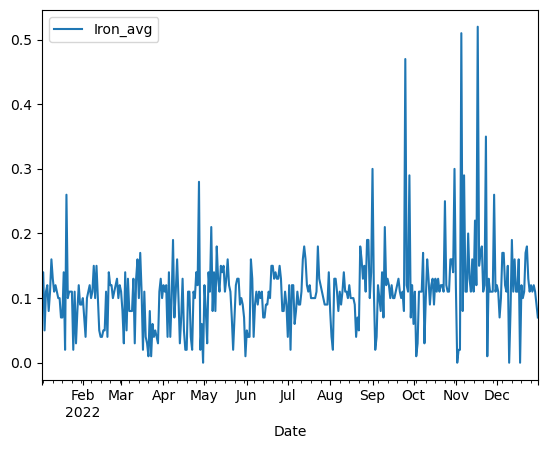

In [526]:
dc[(dc['wtp'] == 'Sungai Rangkap')& (dc['Date'] > '2022-01-01')].plot(x='Date',y=['Iron_avg'])

### Water Grading Mechanism

In [527]:
## Ammonia

def ammonia_score(x):
    if x<=0.3:
        score = 100.5-105*x
    elif (x>0.3) & (x<=4):
        score = 94*math.exp(-0.573*x)-5*abs(x-2)
    else:
        score = 0
        
    return score

## Suspended Solid (Turbidity)

def SS_score(x):
    if x<=100:
        score = 97.5*math.exp(-0.00676*x)+0.05*x
    elif (x>100) & (x<=1000):
        ### what is I
        score = 71*math.exp(-0.0061*x)+0.015*x
    else:
        score = 0
        
    return score

## pH Score

def pH_score(x):
    if x<5.5:
        score = 17.02-17.2*x+5.02*x**2
    elif (x>=5.5) & (x<7):
        score = -242+95.5*x-6.67*x**2
    elif (x>=7) & (x<8.75):
        score = -181+82.4*x-6.05*x**2
    else:
        score = 536-77.0*x+2.76*x**2
        
    return score

## Color Score (National Water Standard for Malaysia Guideline)

def color_score(x):
    # Class I - Practically no treatment necessary.
    if x<15:
        score = (1-x/15)*10+90
    # Class II - Conventional treatment
    elif (x>=15) & (x<=150):
        score = (1-(x-15)/135)*90
    # Class III and lower - Extensive treatment required
    else:
        score = 0
        
    return score

## Manganese Score (National Water Standard for Malaysia Guideline)
def Mn_score(x):
    # Class I
    if x<0.1:
        score = (1-x/0.1)*50+50
    # Class II & III
    elif (x>=0.1) & (x<=0.2):
        score = (1-(x-0.1)/0.1)*50
    # Class IV
    else:
        score = 0
    return score


## Iron Score 
def Fe_score(x):
    # WQ Dept Excel file guideline
    fegl = 1
    score = max((1 - x/fegl)*100,0)
    return score

In [528]:
to_score = dc[['wtp', 'pH_avg', 'Date', 'Turbidity_avg', 'Color_avg', 'Iron_avg','Ammonia_avg','Manganese_avg','Month']].copy()
to_score['pH_Sc'] = to_score['pH_avg'].apply(lambda x: pH_score(x))
to_score['SS_sc'] = to_score['Turbidity_avg'].apply(lambda x: SS_score(x))
to_score['Co_Sc'] = to_score['Color_avg'].apply(lambda x: color_score(x))
to_score['Iron_Sc'] = to_score['Iron_avg'].apply(lambda x: Fe_score(x))
to_score['Amm_Sc'] = to_score['Ammonia_avg'].apply(lambda x: ammonia_score(x))
to_score['Mgn_Sc'] = to_score['Manganese_avg'].apply(lambda x: Mn_score(x))

In [529]:
Psc = ['pH_Sc','SS_sc','Co_Sc','Iron_Sc','Amm_Sc','Mgn_Sc']

In [530]:
## Water Grading by Random Weightage
to_score['WGI'] = to_score[Psc].dot(np.array(fw))

## Water Grading by Cost Weightage
to_score['WGI_c'] = to_score[Psc].dot(np.array(fwc))

## Water Grading by Dosage Weightage
to_score['WGI_d'] = to_score[Psc].dot(np.array(fwd))

## Water Grading Mechanism/Model Evaluation (VS WQI)

In [531]:
## Get WQI data provided by production team 
wqidb = pd.read_csv('WQI_Breakdown.csv')
wqidb = wqidb.rename(columns={'Month':'DMonth','New WTP':'wtp'})
wqidb['DMonth'] = pd.to_datetime(wqidb['DMonth'])
wqidb['Month'] = wqidb['DMonth'].dt.month

In [532]:
## Touch up on raw data
def ren(x):
    if x=='Semenyih 2 ':
        y = 'Semenyih 2'
    else:
        y = x
    return y

In [533]:
to_score['Month_Year'] = to_score['Date'].dt.strftime('%m-%Y')
to_score

wtp  pH_avg       Date  Turbidity_avg  Color_avg  Iron_avg  \
0      Batang Kali    6.77 2021-04-01          28.75       4.96      0.26   
1      Batang Kali    6.65 2021-04-02           5.67       0.42      0.22   
2      Batang Kali    6.61 2021-04-03          14.72       0.42      0.13   
3      Batang Kali    6.60 2021-04-04           9.50       3.42      0.22   
4      Batang Kali    6.61 2021-04-05           9.01       0.17      0.14   
...            ...     ...        ...            ...        ...       ...   
25125  Wangsa Maju    6.24 2022-12-27          33.49     297.46      0.59   
25126  Wangsa Maju    6.29 2022-12-28          35.94     300.04      0.54   
25127  Wangsa Maju    6.29 2022-12-29          31.50     289.63      0.54   
25128  Wangsa Maju    6.28 2022-12-30          34.37     258.54      0.57   
25129  Wangsa Maju    6.28 2022-12-31          30.37     255.54      0.56   

       Ammonia_avg  Manganese_avg  Month      pH_Sc      SS_sc      Co_Sc  \
0             0.28           0.02      4  98.829557  81.716043  96.693333   
1             0.12           0.02      4  98.110925  94.117117  99.720000   
2             0.22           0.02      4  97.828693  89.001135  99.720000   
3             0.47           0.04      4  97.754800  91.910369  97.720000   
4             0.15           0.02      4  97.828693  92.189242  99.886667   
...            ...            ...    ...        ...        ...        ...   
25125         0.39           0.07     12  94.206208  79.421501   0.000000   
25126         0.40           0.06     12  94.802453  78.266960   0.000000   
25127         0.35           0.07     12  94.802453  80.374951   0.000000   
25128         0.44           0.08     12  94.685872  79.004373   0.000000   
25129         0.45           0.05     12  94.685872  80.922693   0.000000   

       Iron_Sc     Amm_Sc  Mgn_Sc        WGI      WGI_c      WGI_d Month_Year  
0         74.0  71.100000    90.0  89.243715  88.162307  88.352191    04-2021  
1         78.0  87.900000    90.0  93.914188  93.150147  92.704139    04-2021  
2         87.0  77.400000    90.0  92.842710  92.171519  92.816675    04-2021  
3         78.0  64.157202    80.0  89.668563  88.595498  88.700837    04-2021  
4         86.0  84.750000    90.0  94.048901  93.450990  93.746000    04-2021  
...        ...        ...     ...        ...        ...        ...        ...  
25125     41.0  67.125455    65.0  59.394366  59.560890  51.119315    12-2022  
25126     46.0  66.745931    70.0  60.343103  60.650246  52.394018    12-2022  
25127     46.0  68.668374    65.0  60.406135  60.710322  52.519045    12-2022  
25128     43.0  65.252239    60.0  58.999581  59.144429  51.138429    12-2022  
25129     44.0  64.884846    75.0  60.869838  61.156226  52.247660    12-2022  

[25123 rows x 19 columns]

In [534]:
fscore = to_score.groupby(['wtp','Month_Year'])['pH_Sc', 'SS_sc', 'Co_Sc','Iron_Sc', 'Amm_Sc', 'Mgn_Sc', 'WGI','WGI_c','WGI_d'].mean().reset_index()
fscore['wtp'] = fscore['wtp'].apply(lambda x: ren(x))

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [535]:
wqidb

DMonth                     WTP                           wtp  \
0   2021-01-31  Bernam River Headworks  Bernam River Headworks (New)   
1   2021-01-31          Rantau Panjang            Rantau Panjang New   
2   2021-01-31           North Hummock                 North Hummock   
3   2021-01-31             Batang Kali                   Batang Kali   
4   2021-01-31        Kuala Kubu Bharu              Kuala Kubu Bharu   
..         ...                     ...                           ...   
412 2021-12-31                   SSP 1        Sungai Selangor Fasa 1   
413 2021-12-31                    RASA                          Rasa   
414 2021-12-31           SSP 3 BKT BDG        Sungai Selangor Fasa 3   
415 2021-12-31                LANGAT 2                      Langat 2   
416 2021-12-31          LABOHAN DAGANG                Labohan Dagang   

          SIpH        SIDO       SISS    SIBOD   SICOD       SIAN   WQI  Month  
0    99.350000   81.196365  60.772518  95.6201  81.677  53.545629  78.8      1  
1    97.828693   94.055141  45.410012  93.4628  86.066  82.745931  83.6      1  
2    69.964888   44.512861  91.062900  93.5897  75.559  77.400000  74.2      1  
3    99.242468  100.000000  95.098925  96.3815  90.987  80.550000  94.1      1  
4    93.832453  100.000000  94.509572  93.8435  94.445  90.000000  94.8      1  
..         ...         ...        ...      ...     ...        ...   ...    ...  
412  96.932555   85.416711  42.578498  95.7047  81.411  84.750000  81.2     12  
413  99.072292   84.092350  81.103048  99.5963  97.504  87.900000  91.1     12  
414  98.909420   39.026582  50.133469  97.5236  83.007  85.800000  73.2     12  
415  99.159355   94.974400  89.395786  88.2176  95.243  79.500000  91.0     12  
416  94.802453   79.005218  96.893123  90.6287  87.263  85.800000  88.3     12  

[417 rows x 11 columns]

In [536]:
## Final data to be compare 
#c = pd.merge(fscore, wqidb, on=['wtp','Month'],how='left')
c = fscore
## To gauge roughly how much the differences
#c['Diff'] = abs(c['WGI_d'] - c['WQI'])

In [537]:
## For user to double check the grading by WTP
#c.to_excel('WGI_Full_DB.xlsx')

In [538]:
to_merge = dc[['Lembangan','wtp']].drop_duplicates(subset='wtp')
c = pd.merge(c,to_merge,on=['wtp'],how='left')

In [539]:
c

wtp Month_Year      pH_Sc      SS_sc      Co_Sc    Iron_Sc  \
0    Ampang Intake    01-2021  94.272226  77.936429  15.974409  82.258065   
1    Ampang Intake    01-2022  95.743087  60.617039   6.272043  78.096774   
2    Ampang Intake    02-2021  91.951318  79.195662  16.775476  74.928571   
3    Ampang Intake    02-2022  95.352663  66.253740   8.938095  79.178571   
4    Ampang Intake    03-2021  96.176716  72.510342  18.221075  64.322581   
..             ...        ...        ...        ...        ...        ...   
823    Wangsa Maju    10-2021  94.051354  95.279909  70.273333  61.548387   
824    Wangsa Maju    10-2022  94.771395  91.774958  54.268172  67.451613   
825    Wangsa Maju    11-2021  94.071947  95.038127  65.688667  25.566667   
826    Wangsa Maju    11-2022  94.790580  87.985548  25.378444  49.233333   
827    Wangsa Maju    12-2022  94.610950  82.349837  16.559140  43.838710   

        Amm_Sc      Mgn_Sc        WGI      WGI_c      WGI_d Lembangan  
0    85.575580  100.000000  72.251664  73.594621  67.596441  Sg Klang  
1    80.129375  100.000000  66.545344  67.808270  62.361040  Sg Klang  
2    84.662940  100.000000  71.104290  72.296436  65.752017  Sg Klang  
3    81.744541  100.000000  68.274775  69.563655  63.877736  Sg Klang  
4    80.032583  100.000000  70.002648  70.678545  64.141211  Sg Klang  
..         ...         ...        ...        ...        ...       ...  
823  76.060115   88.870968  83.280630  82.733503  78.704961  Sg Klang  
824  75.201671   83.387097  79.267330  79.155053  74.835092  Sg Klang  
825  68.877000   81.333333  77.059374  75.534240  69.085097  Sg Klang  
826  71.599062   76.500000  69.193660  69.156648  61.942787  Sg Klang  
827  66.303700   73.064516  64.762375  64.675290  57.080782  Sg Klang  

[828 rows x 12 columns]

In [540]:
## General Plot to see how the WQI & WGI Differences
# for i in c['wtp'].unique():
#     c[c['wtp']==i].plot(x='Month',y=['WGI_d','WQI'])
#     plt.title(f'WGI VS WQI Time Series {i}')
#     plt.ylabel('Score')
#     plt.show()

### WGI/WQI VS Actual Monthly Chemical Consumption (Linear Correlation)

In [470]:
## Loading Chemical File & Perform Data Regrouping
chedf = pd.read_csv('checons.csv')
chedf = chedf.rename(columns={'Flopam AH 912 PWG (25kg / bag).1':'Flopam AH 912 PWG (25kg / bag)'})
mdict = dict(zip(chedf['Month'].unique(),np.array(range(1,13,1))))
chedf['Month'] = chedf['Month'].apply(lambda x: mdict.get(x))
cgr = pd.read_csv("C.Grouping.csv")
cgr = cgr.rename(columns={'Chemical Name':'Chem'})

In [471]:
newdb = pd.merge(pd.DataFrame({'Chem':chedf.columns}),cgr,on='Chem',how='inner')
coa = newdb[newdb['Correct Grouping']=='Coagulant']['Chem'].unique()
pha = newdb[newdb['Correct Grouping']=='pH Adjuster']['Chem'].unique()
dis = newdb[newdb['Correct Grouping']=='Disinfectant']['Chem'].unique()

In [472]:
chedf['Coagulant'] = chedf[coa].sum(axis=1)
chedf['pH Adjuster'] = chedf[pha].sum(axis=1)
chedf['Disinfectant'] = chedf[dis].sum(axis=1)

In [67]:
fcl = ['Month', 'wtp', 'Coagulant','pH Adjuster', 'Disinfectant']
db1 = chedf[fcl].copy()
c2 = pd.merge(c,db1,on=['wtp','Month'],how='left')

KeyError: 'Month'

In [68]:
## General Correlation Between Chemical Products & WGI/WQI
c2[['wtp','WQI','WGI_d','Coagulant','Disinfectant','pH Adjuster']].corr()

NameError: name 'c2' is not defined

### WGI/WQI VS Actual Monthly Chemical Consumption (Elasticity of Grading)

In [ ]:
the_name = ['pH_Sc', 'SS_sc', 'Co_Sc', 'Iron_Sc', 'Amm_Sc', 'Mgn_Sc', 'WGI','SIpH', 'SIDO', 'SISS', 'SIBOD', 'SICOD', 'SIAN','WQI','WGI_c','WGI_d', 'pH Adjuster', 'Disinfectant', 'Coagulant']
## Generate Daily % Changed 
for i in the_name:
    c2[f'{i}_chpctm'] = (c2.groupby('wtp')[i].shift(1)-c2[i])/c2[i]
    
## Parameters To Focus
tfi2 = ['pH Adjuster_chpctm','Disinfectant_chpctm','Coagulant_chpctm']

In [ ]:
for i in tfi2:
    c2[f'Elas_WGI_G{i}'] = c2[i]/c2['WGI_chpctm']
    c2[f'Elas_WQI_{i}'] = c2[i]/c2['WQI_chpctm']
    c2[f'Elas_WGI_c{i}'] = c2[i]/c2['WGI_c_chpctm']
    c2[f'Elas_WGI_d{i}'] = c2[i]/c2['WGI_d_chpctm']

In [ ]:
lmo = [x for x in c2.columns if "Elas_WGI_G" in x]
lmc = [x for x in c2.columns if "Elas_WGI_c" in x]
lmd = [x for x in c2.columns if "Elas_WGI_d" in x]
lmi = [x for x in c2.columns if "Elas_WQI_" in x]
lll = lmo + lmi + lmc + lmd

In [ ]:
mdict = {'Parameters':[],'Median':[],'Count':[],'+ve_inf':[],'-ve_inf':[],'0_count':[]}
for i in lll:
    temp = c2[i].copy()
    temp1 = temp[~temp.isin([np.nan, np.inf, -np.inf,0])]
    mdict['Parameters'].append(i)
    mdict['Median'].append(temp1.median()) ## Get Median due to a good measure when there are outliers
    mdict['Count'].append(temp1.count())
    mdict['+ve_inf'].append(temp[temp.isin([np.inf])].count())
    mdict['-ve_inf'].append(temp[temp.isin([-np.inf])].count())
    mdict['0_count'].append(temp[temp.isin([0])].count())

In [ ]:
result = pd.DataFrame(mdict)
result[result['Parameters'].isin(lmd)]

Parameters    Median  Count  +ve_inf  -ve_inf  0_count
9    Elas_WGI_dpH Adjuster_chpctm -1.382518    268        2        7        8
10  Elas_WGI_dDisinfectant_chpctm -0.552521    267        0        1       42
11     Elas_WGI_dCoagulant_chpctm -1.777638    247        2        6       11

## Unit Cost Comparison

In [542]:
uc = pd.read_csv('unit_cost_v2.csv')
uc = uc.rename(columns={'n_wtp':'wtp','UnitCost (cent per m3)':'Unit_cost'})
uc1 = uc[(uc['Year']==2021) | (uc['Year']==2022)].copy()

In [543]:
uc1['Month_Year'] = pd.to_datetime(uc1['Year'].astype(str) + '-' + uc1['Month'].astype(str) + '-01', format='%Y-%m-%d').dt.strftime('%m-%Y')
#uc1['Month_Year'] = uc1['Month_Year'].dt.strftime('%m-%Y')

In [544]:
fc = pd.merge(c,uc1[['wtp','Month_Year','Unit_cost']],on=['wtp','Month_Year'],how='left')

In [545]:
fc['Month_Year'] = pd.to_datetime(fc['Month_Year'])

## Graph

t-value = 1647.027, p-value = 0.000


<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Batang Kali Corr:-0.14')

Text(0, 0.5, 'Score')

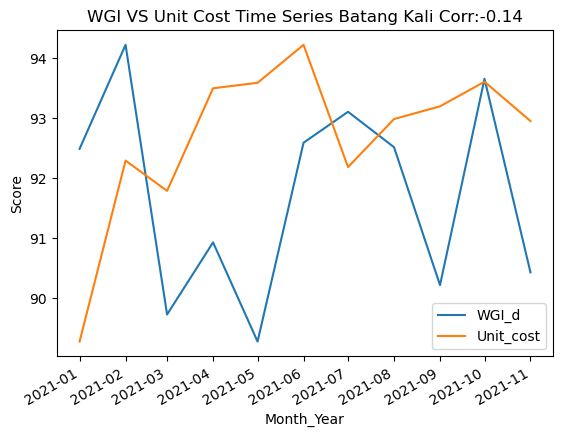

<AxesSubplot:>

Text(0.5, 1.0, 'Batang Kali')

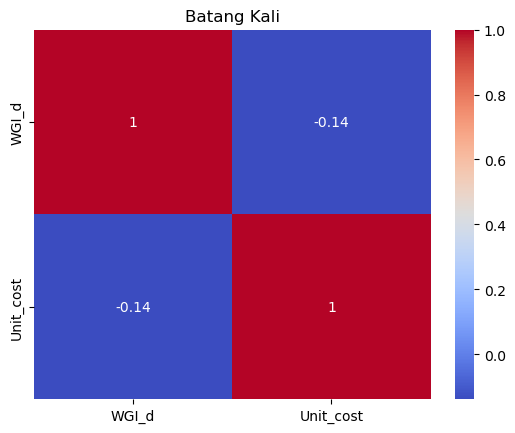

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     71.16
Date:                Mon, 20 Mar 2023   Prob (F-statistic):           4.67e-17
Time:                        10:54:41   Log-Likelihood:                -8017.7
No. Observations:                3674   AIC:                         1.604e+04
Df Residuals:                    3672   BIC:                         1.605e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.3961      2.017     17.549      0.0

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Kuala Kubu Bharu Corr:-0.75')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

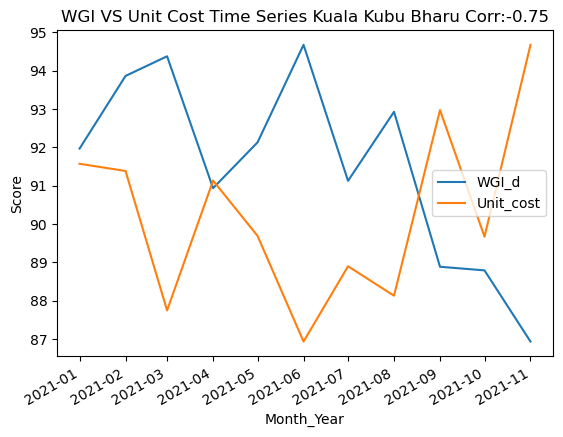

<AxesSubplot:>

Text(0.5, 1.0, 'Kuala Kubu Bharu')

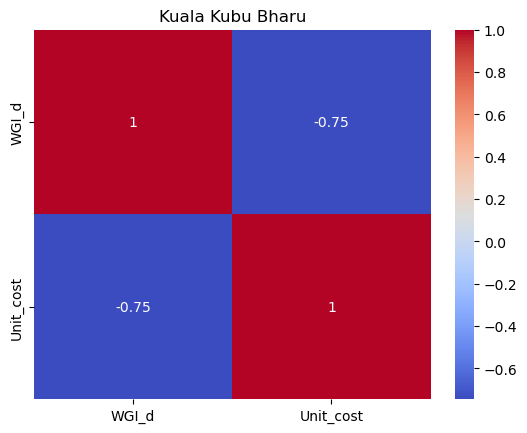

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     4584.
Date:                Mon, 20 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:54:41   Log-Likelihood:                 811.50
No. Observations:                3674   AIC:                            -1619.
Df Residuals:                    3672   BIC:                            -1607.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.8290      0.123    103.975      0.0

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Rantau Panjang New Corr:-0.18')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

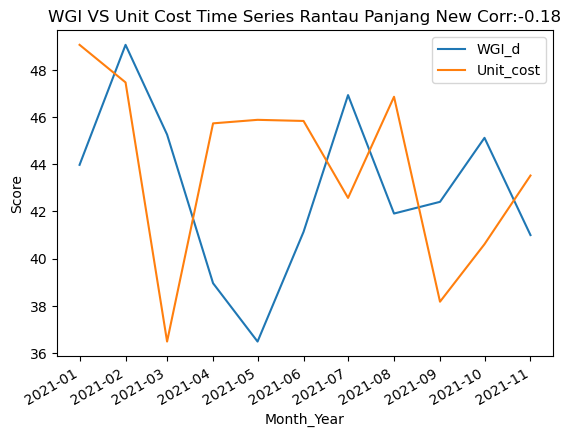

<AxesSubplot:>

Text(0.5, 1.0, 'Rantau Panjang New')

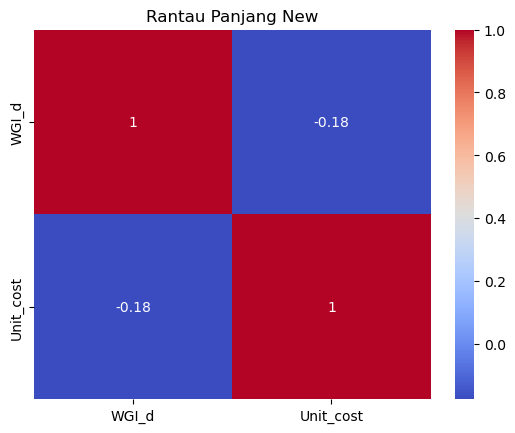

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     116.7
Date:                Mon, 20 Mar 2023   Prob (F-statistic):           8.59e-27
Time:                        10:54:42   Log-Likelihood:                -3097.7
No. Observations:                3674   AIC:                             6199.
Df Residuals:                    3672   BIC:                             6212.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7487      0.116     58.218      0.0

All-NaN slice encountered
All-NaN slice encountered


<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Rantau Panjang Old Corr:nan')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

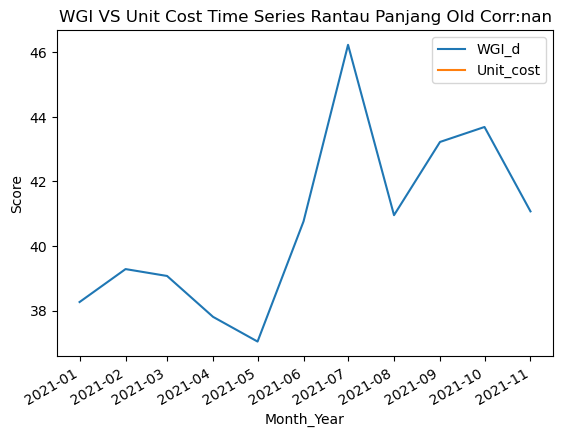

<AxesSubplot:>

Text(0.5, 1.0, 'Rantau Panjang Old')

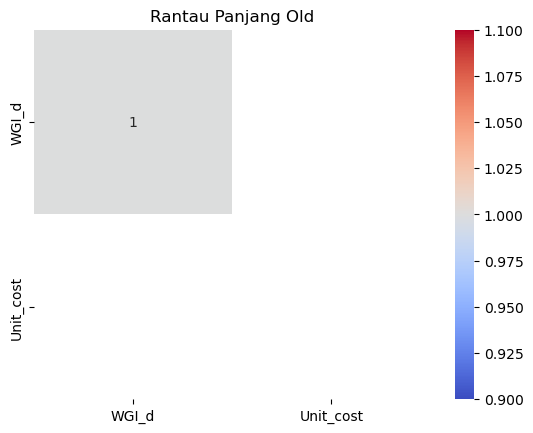

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 20 Mar 2023   Prob (F-statistic):                nan
Time:                        10:54:42   Log-Likelihood:                    nan
No. Observations:                3674   AIC:                               nan
Df Residuals:                    3672   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Rasa Corr:-0.42')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

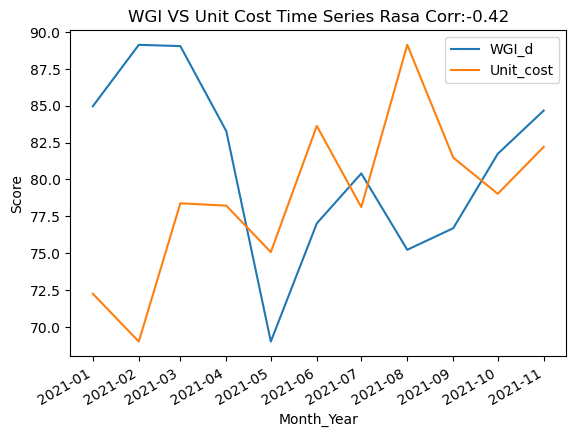

<AxesSubplot:>

Text(0.5, 1.0, 'Rasa')

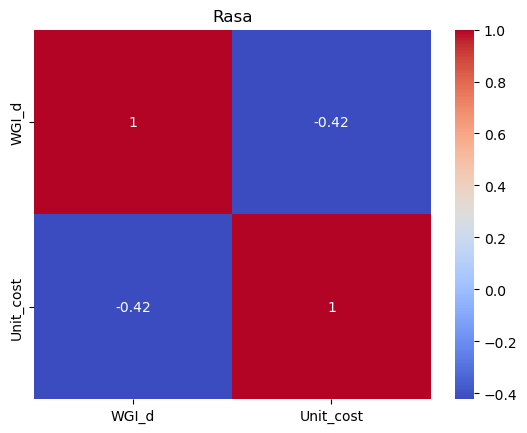

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     798.2
Date:                Mon, 20 Mar 2023   Prob (F-statistic):          4.59e-159
Time:                        10:54:42   Log-Likelihood:                 21429.
No. Observations:                3674   AIC:                        -4.285e+04
Df Residuals:                    3672   BIC:                        -4.284e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0116      0.000     71.248      0.0

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Sungai Rangkap Corr:-0.1')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

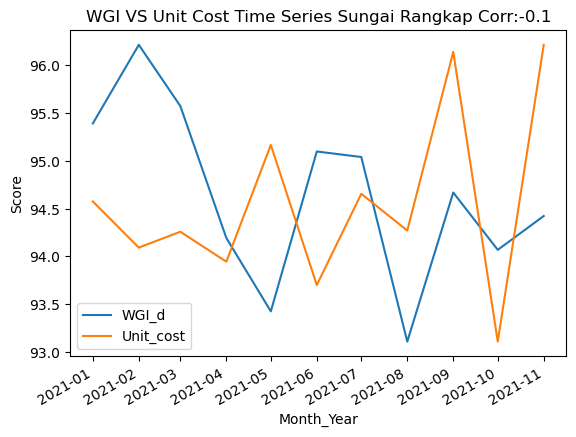

<AxesSubplot:>

Text(0.5, 1.0, 'Sungai Rangkap')

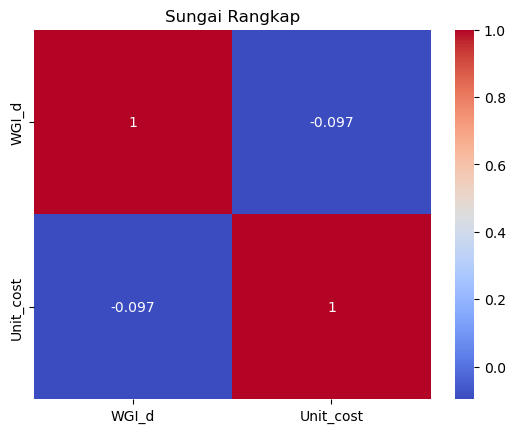

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     34.71
Date:                Mon, 20 Mar 2023   Prob (F-statistic):           4.17e-09
Time:                        10:54:43   Log-Likelihood:                -3585.4
No. Observations:                3674   AIC:                             7175.
Df Residuals:                    3672   BIC:                             7187.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.3766      1.130     10.072      0.0

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Sungai Selangor Fasa 1 Corr:-0.85')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

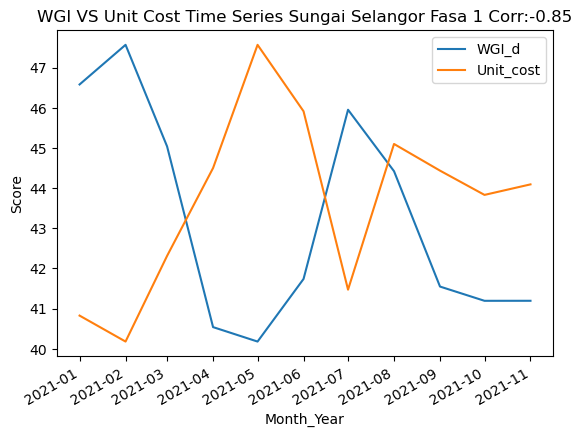

<AxesSubplot:>

Text(0.5, 1.0, 'Sungai Selangor Fasa 1')

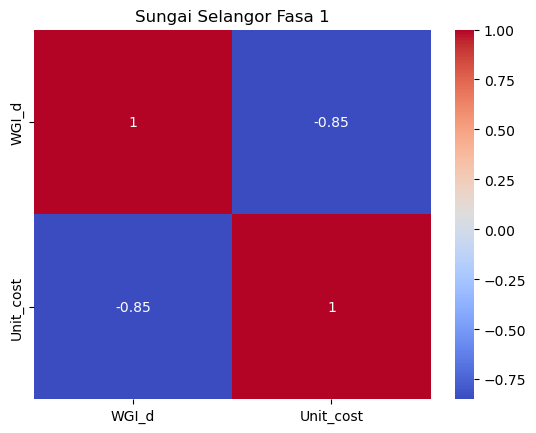

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     9519.
Date:                Mon, 20 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:54:44   Log-Likelihood:                 3907.3
No. Observations:                3663   AIC:                            -7811.
Df Residuals:                    3661   BIC:                            -7798.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7590      0.023    161.248      0.0

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Sungai Selangor Fasa 2 Stream C Corr:-0.9')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

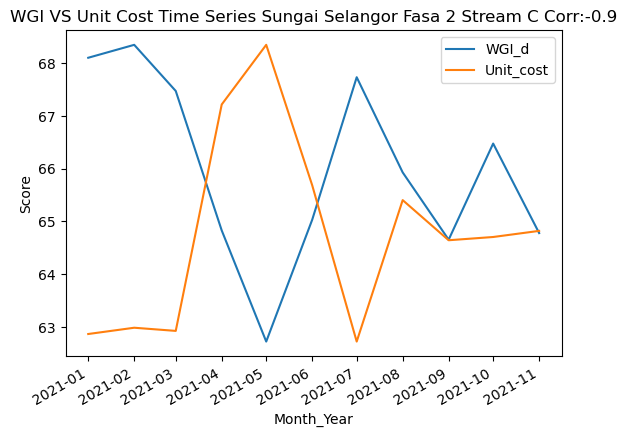

<AxesSubplot:>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream C')

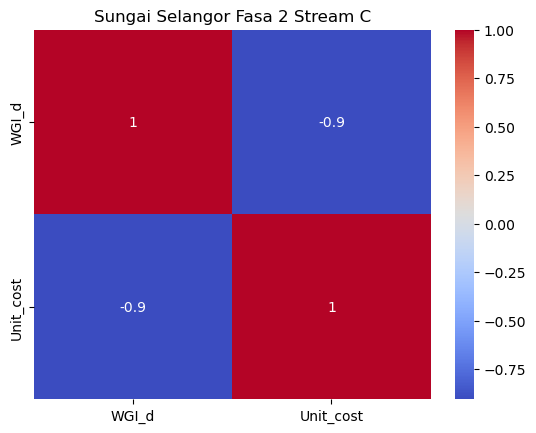

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                 1.661e+04
Date:                Mon, 20 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:54:45   Log-Likelihood:                 3117.8
No. Observations:                3674   AIC:                            -6232.
Df Residuals:                    3672   BIC:                            -6219.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.3884      0.066    201.401      0.0

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Sungai Selangor Fasa 3 Corr:0.18')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

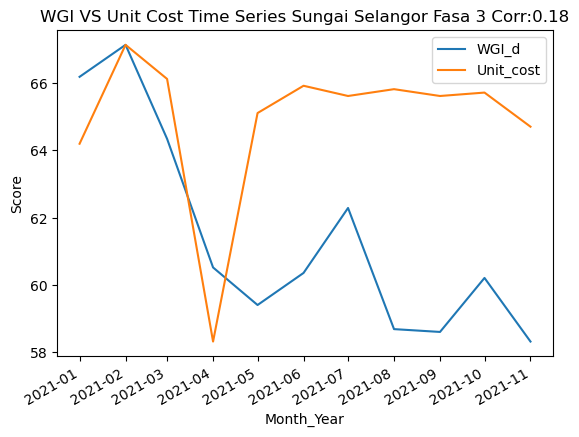

<AxesSubplot:>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3')

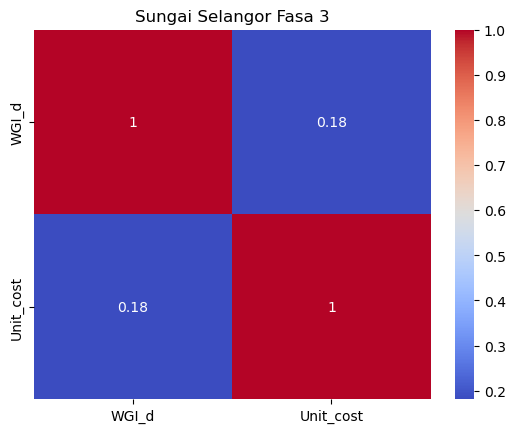

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     124.4
Date:                Mon, 20 Mar 2023   Prob (F-statistic):           2.00e-28
Time:                        10:54:45   Log-Likelihood:                 434.73
No. Observations:                3663   AIC:                            -865.5
Df Residuals:                    3661   BIC:                            -853.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.1648      0.073    710.387      0.0

<Figure size 640x480 with 0 Axes>

In [546]:
import statsmodels.api as sm
fr = pd.merge(fc,master_db[['wtp']],on = 'wtp',how = 'left')

# define the conditions
#condition = (fr['wtp'] == 'Kuala Kubu Bharu') | (fr['wtp'] == 'Batang Kali')| (fr['wtp'] == 'Sungai Rangkap')
# use loc to update the values
#fr.loc[condition, 'Lembangan'] = 'Sungai Selangor Upstream'

#fr = fr[(fr['wtp'] != 'Sungai Selangor Fasa 2 Stream C') & (fr['wtp'] != 'Bukit Tampoi New') & (fr['wtp'] != 'Salak Tinggi')& (fr['wtp'] != 'Sungai Serai') ]
fr = fr[(fr['Lembangan'] == 'Sg Selangor') & (fr['Month_Year'] < '01-2022')]
# for i in c['wtp'].unique():
#     c[c['wtp']==i].plot(x='Month',y=['WGI_d','WQI'])
#     plt.title(f'WGI VS WQI Time Series {i}')
#     plt.ylabel('Score')
#     plt.show()
#fr[['Unit_cost']] = fr[['Unit_cost']].multiply(10)
columns_target = 'wtp'
core_unit_wgi = []
wtp_corr = []
#columns_target = 'Lembangan'
for i in fr[columns_target].unique():
    # fr[fr[columns_target]==i].plot(x='Month',y=['WGI_d'])
    # plt.title(f'WGI Time Series {i}')
    # plt.ylabel('Score')
    # plt.show()
    # fr[fr[columns_target]==i].plot(x='Month',y=['Unit_cost'])
    # plt.title(f'Unit Cost Time Series {i}')
    # plt.ylabel('Score')
    # plt.show()
    core = fr[fr[columns_target] == i][['WGI_d','Unit_cost']].corr()
    core_unit_wgi.append(core['Unit_cost'][0])
    corr_val =round(core['Unit_cost'][0],2)
    #for i in c['wtp'].unique():
    
    a = fr[fr['wtp']==i].copy()
    t, p = stats.ttest_ind(a['WGI_d'], a['Unit_cost'])

    # print the results
    print("t-value = {:.3f}, p-value = {:.3f}".format(t, p))
    scaler = MinMaxScaler(feature_range=(a['WGI_d'].min(), a['WGI_d'].max()))
    a['Unit_cost'] = scaler.fit_transform(a[['Unit_cost']])
    a.plot(x='Month_Year',y=['WGI_d','Unit_cost'])
    plt.title(f'WGI VS Unit Cost Time Series {i} Corr:{corr_val}')
    plt.ylabel('Score')
    #save = f'Plot/Sg_Sel_2021_2/{i}WGI_UnitCost_TimeSeries_plot_Sg_Selangor.png'
    plt.show()
    wtp_corr.append(i) 
    sns.heatmap(core, annot=True, cmap='coolwarm')
    plt.title(i)
    plt.show()
    #save = f'Plot/Sg_Sel_2021_2/{i}WGI_UnitCost_Corr_plot_Sg_Selangor.png'
    plt.savefig(save)
    X = fr[fr[columns_target] == i]['WGI_d']
    Y = fr[fr[columns_target] == i]['Unit_cost']
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    print(model.summary())


data = {'wtp': wtp_corr,
        'corr_wgi_unit': core_unit_wgi}
  
# Create DataFrame
corr_df = pd.DataFrame(data)

In [547]:
corr_df.sort_values('corr_wgi_unit')  #[corr_df['corr_wgi_unit'] > -0.]#['wtp'].to_list()
#corr_df.to_csv('Plot\Result\correlation_unified_weight_WGI_Sg_Selangor_3.csv')

wtp  corr_wgi_unit
7  Sungai Selangor Fasa 2 Stream C      -0.904983
6           Sungai Selangor Fasa 1      -0.849843
1                 Kuala Kubu Bharu      -0.745152
4                             Rasa      -0.422554
2               Rantau Panjang New      -0.175473
0                      Batang Kali      -0.137880
5                   Sungai Rangkap      -0.096770
8           Sungai Selangor Fasa 3       0.181256
3               Rantau Panjang Old            NaN

t-value = 1460.260, p-value = 0.000


<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Batang Kali Corr:-0.3')

Text(0, 0.5, 'Score')

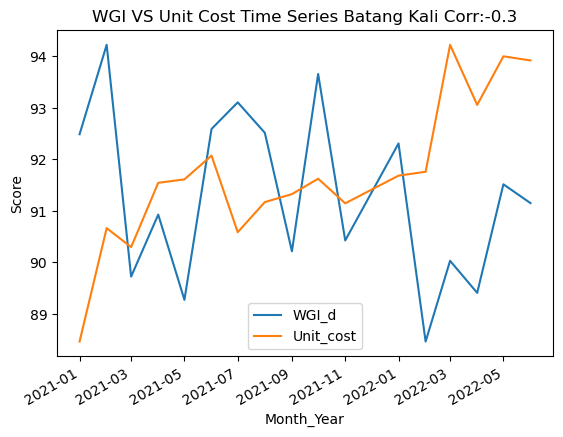

<AxesSubplot:>

Text(0.5, 1.0, 'Batang Kali')

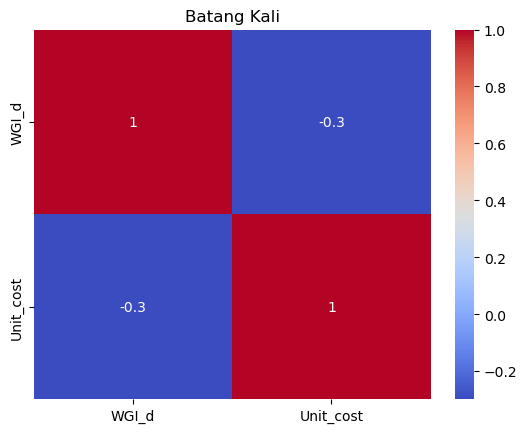

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'Unit Cost Time Series Batang Kali Corr:-0.3')

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     554.3
Date:                Mon, 20 Mar 2023   Prob (F-statistic):          5.07e-117
Time:                        10:54:46   Log-Likelihood:                -14555.
No. Observations:                5678   AIC:                         2.911e+04
Df Residuals:                    5676   BIC:                         2.913e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         75.1961      2.338     32.156      0.0

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Kuala Kubu Bharu Corr:-0.7')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

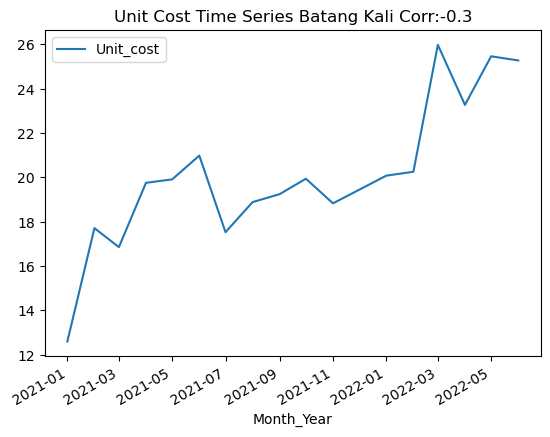

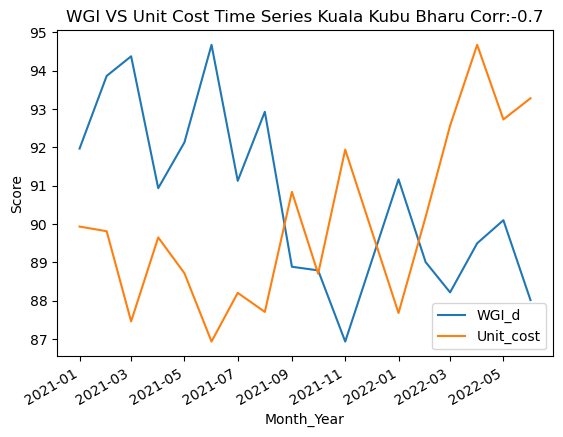

<AxesSubplot:>

Text(0.5, 1.0, 'Kuala Kubu Bharu')

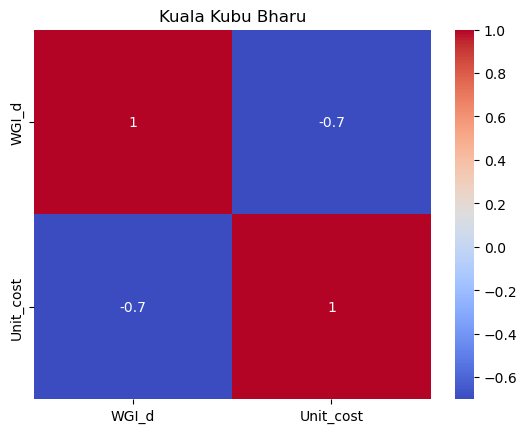

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'Unit Cost Time Series Kuala Kubu Bharu Corr:-0.7')

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     5488.
Date:                Mon, 20 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:54:46   Log-Likelihood:                -1574.3
No. Observations:                5678   AIC:                             3153.
Df Residuals:                    5676   BIC:                             3166.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.2305      0.170    101.627      0.0

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Rantau Panjang New Corr:-0.13')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

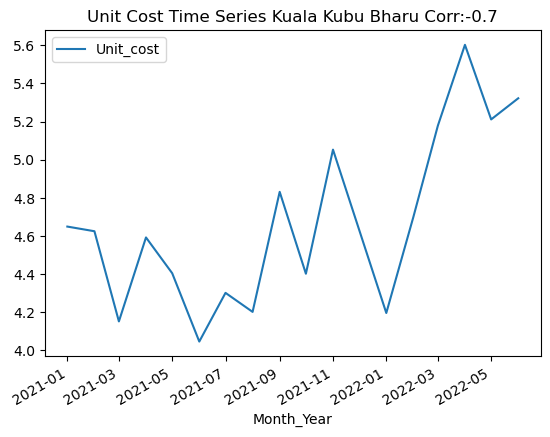

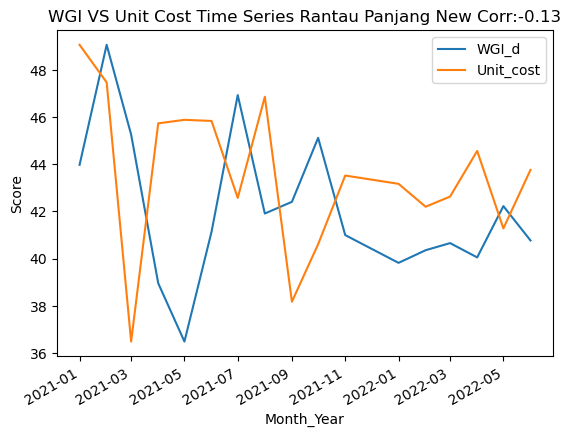

<AxesSubplot:>

Text(0.5, 1.0, 'Rantau Panjang New')

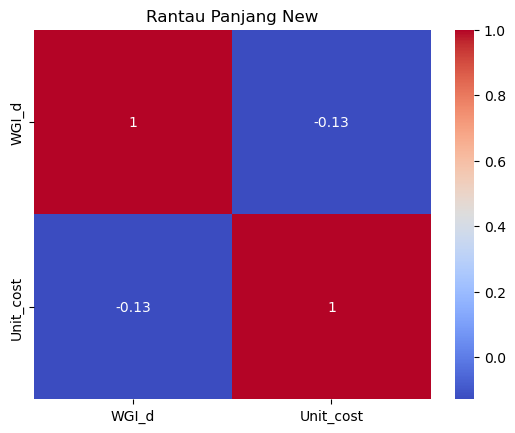

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'Unit Cost Time Series Rantau Panjang New Corr:-0.13')

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     95.27
Date:                Mon, 20 Mar 2023   Prob (F-statistic):           2.49e-22
Time:                        10:54:47   Log-Likelihood:                -3764.3
No. Observations:                5678   AIC:                             7533.
Df Residuals:                    5676   BIC:                             7546.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3025      0.087     72.219      0.0

All-NaN slice encountered
All-NaN slice encountered


<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Rantau Panjang Old Corr:nan')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

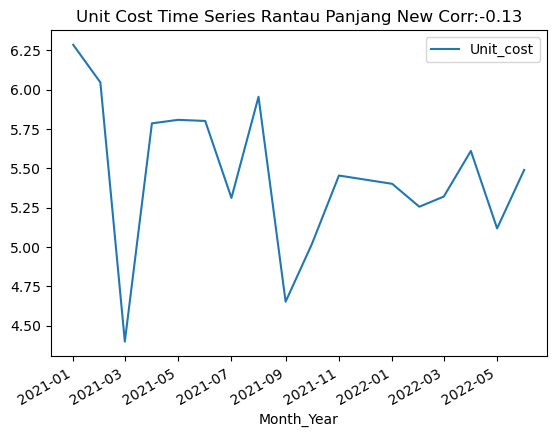

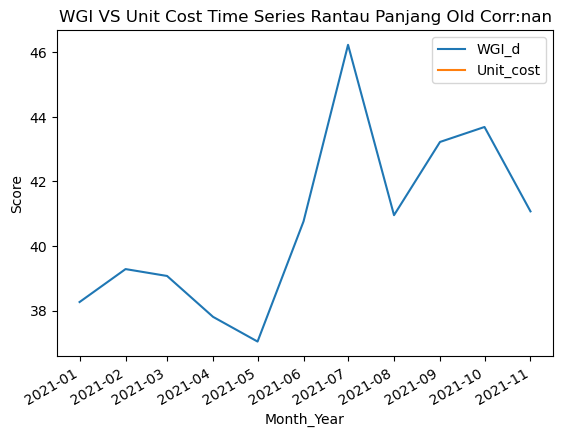

<AxesSubplot:>

Text(0.5, 1.0, 'Rantau Panjang Old')

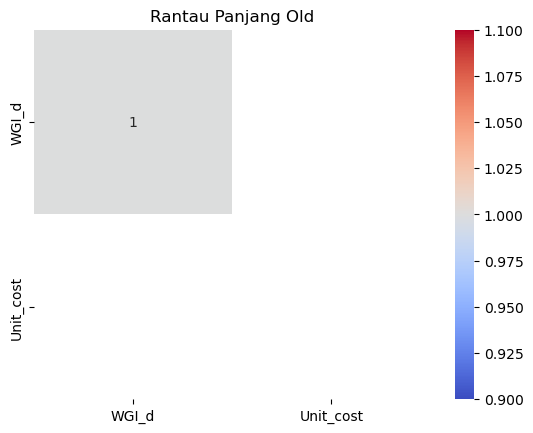

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'Unit Cost Time Series Rantau Panjang Old Corr:nan')

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 20 Mar 2023   Prob (F-statistic):                nan
Time:                        10:54:47   Log-Likelihood:                    nan
No. Observations:                3674   AIC:                               nan
Df Residuals:                    3672   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Rasa Corr:0.41')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

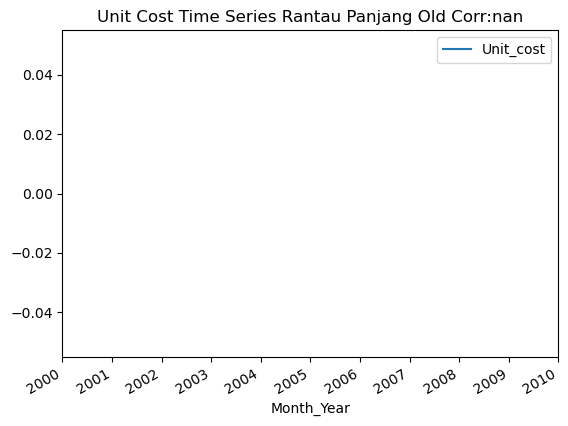

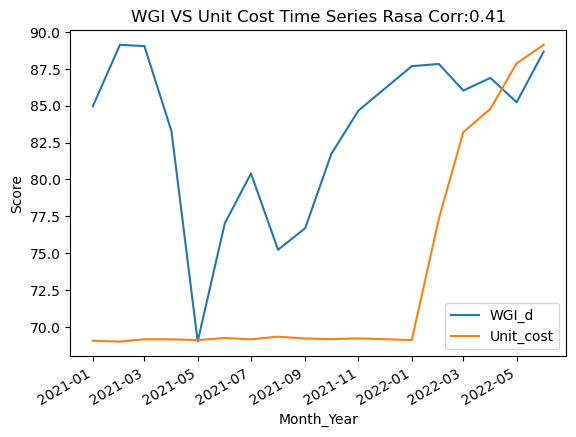

<AxesSubplot:>

Text(0.5, 1.0, 'Rasa')

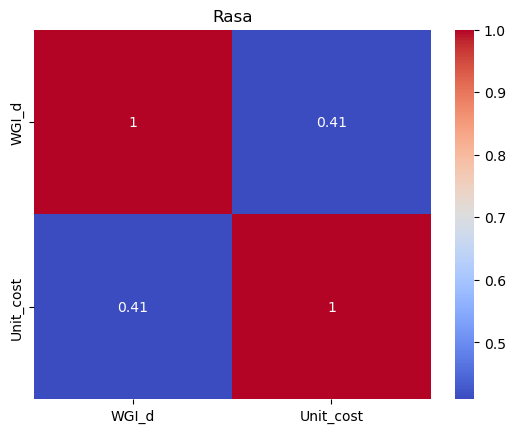

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'Unit Cost Time Series Rasa Corr:0.41')

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     1141.
Date:                Mon, 20 Mar 2023   Prob (F-statistic):          5.01e-228
Time:                        10:54:48   Log-Likelihood:                 7866.1
No. Observations:                5678   AIC:                        -1.573e+04
Df Residuals:                    5676   BIC:                        -1.571e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3576      0.012    -29.733      0.0

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Sungai Rangkap Corr:0.08')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

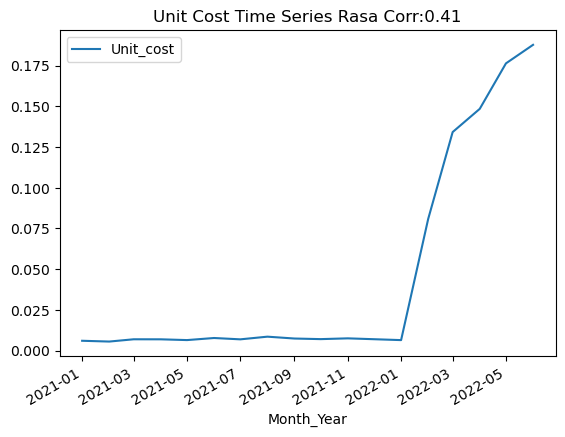

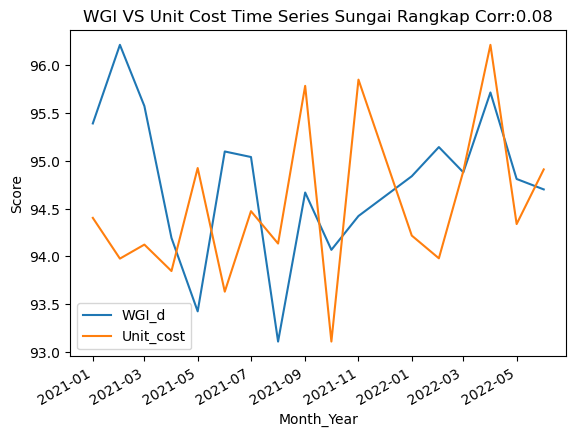

<AxesSubplot:>

Text(0.5, 1.0, 'Sungai Rangkap')

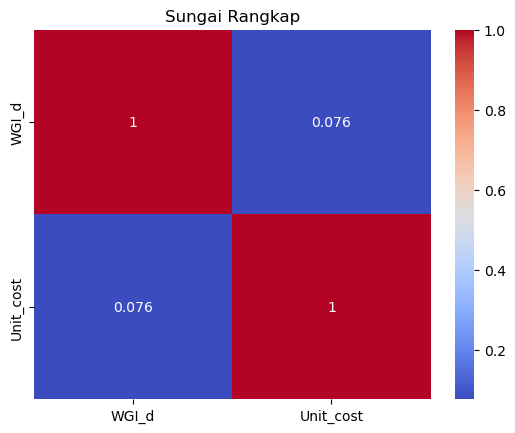

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'Unit Cost Time Series Sungai Rangkap Corr:0.08')

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     32.92
Date:                Mon, 20 Mar 2023   Prob (F-statistic):           1.01e-08
Time:                        10:54:48   Log-Likelihood:                -5512.8
No. Observations:                5678   AIC:                         1.103e+04
Df Residuals:                    5676   BIC:                         1.104e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2250      1.055     -1.161      0.2

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Sungai Selangor Fasa 1 Corr:-0.75')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

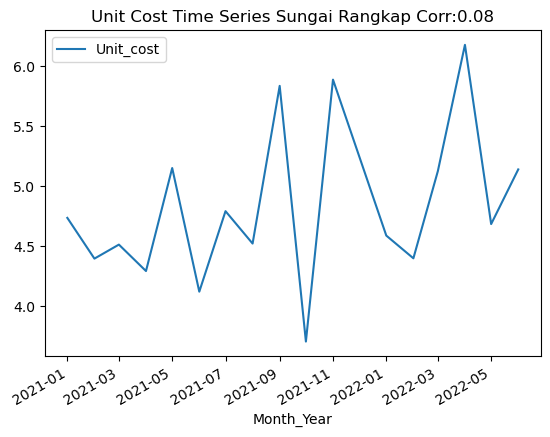

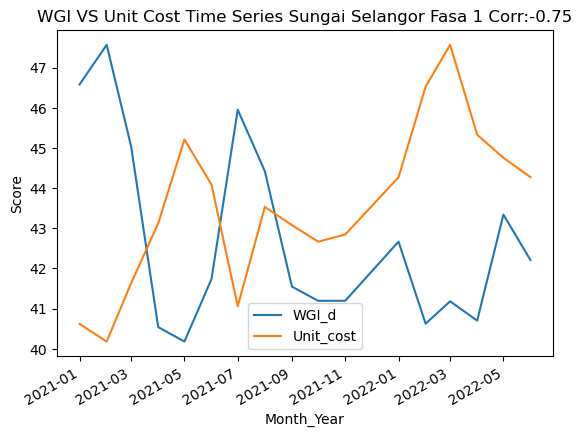

<AxesSubplot:>

Text(0.5, 1.0, 'Sungai Selangor Fasa 1')

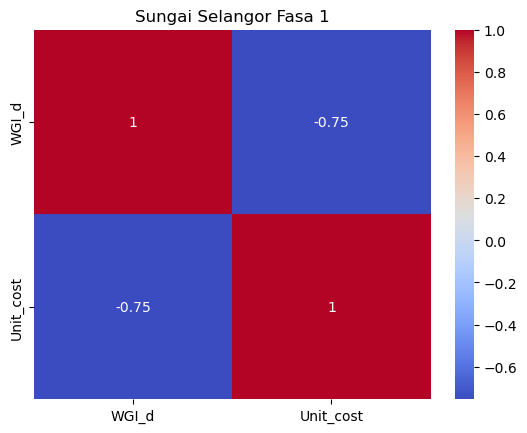

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'Unit Cost Time Series Sungai Selangor Fasa 1 Corr:-0.75')

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     7443.
Date:                Mon, 20 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:54:49   Log-Likelihood:                 3135.2
No. Observations:                5661   AIC:                            -6266.
Df Residuals:                    5659   BIC:                            -6253.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6162      0.035    131.823      0.0

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Sungai Selangor Fasa 2 Stream C Corr:-0.67')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

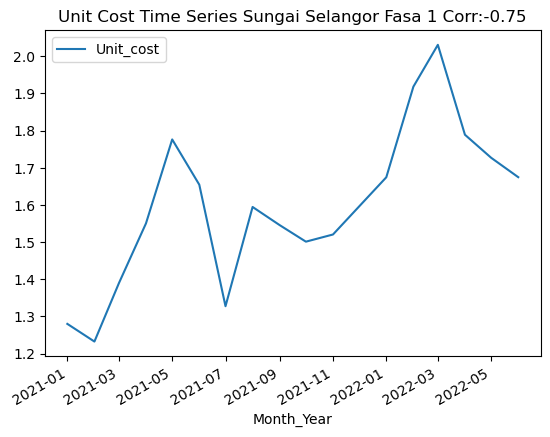

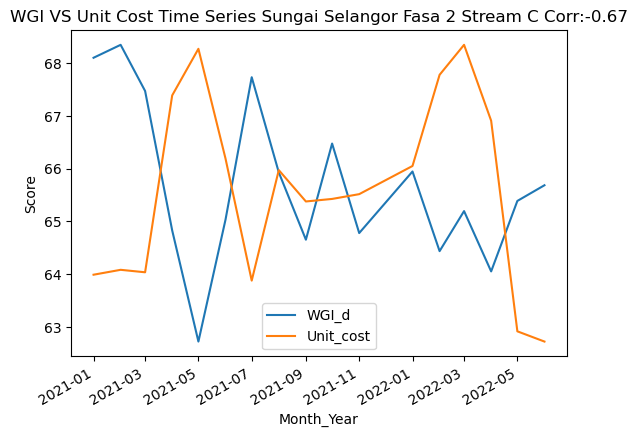

<AxesSubplot:>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream C')

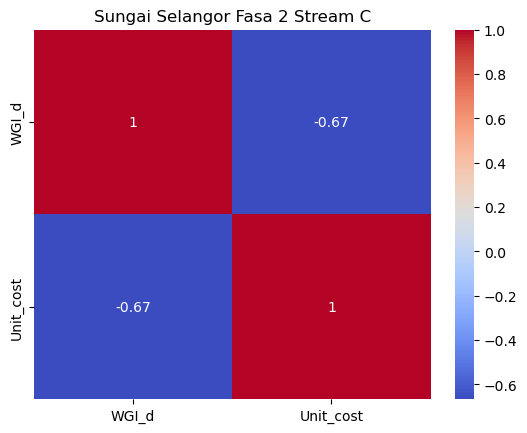

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'Unit Cost Time Series Sungai Selangor Fasa 2 Stream C Corr:-0.67')

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     4547.
Date:                Mon, 20 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:54:49   Log-Likelihood:                 361.88
No. Observations:                5678   AIC:                            -719.8
Df Residuals:                    5676   BIC:                            -706.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.8350      0.133    103.717      0.0

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Sungai Selangor Fasa 3 Corr:0.45')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

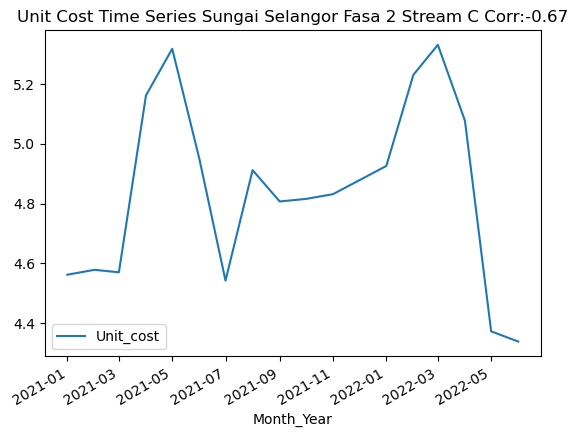

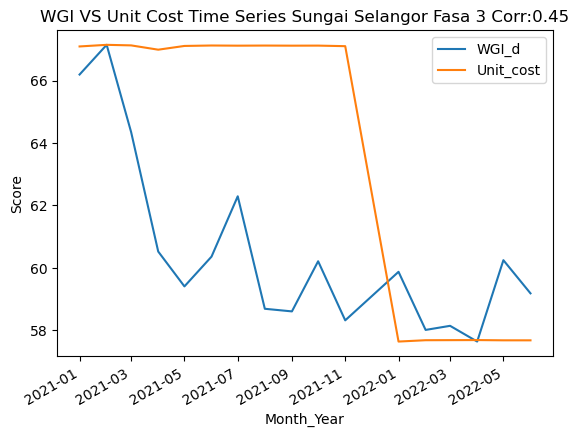

<AxesSubplot:>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3')

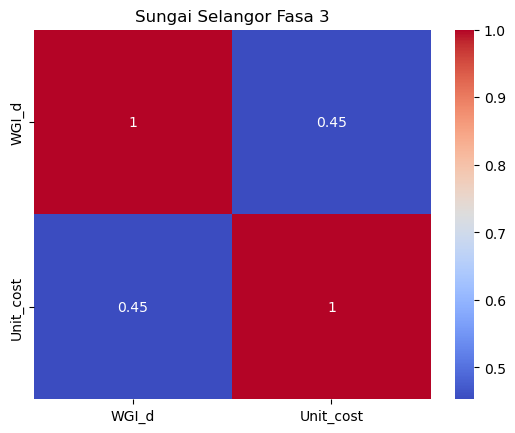

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'Unit Cost Time Series Sungai Selangor Fasa 3 Corr:0.45')

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     1462.
Date:                Mon, 20 Mar 2023   Prob (F-statistic):          8.43e-285
Time:                        10:54:50   Log-Likelihood:                -25651.
No. Observations:                5661   AIC:                         5.131e+04
Df Residuals:                    5659   BIC:                         5.132e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -215.9213      6.552    -32.955      0.0

<Figure size 640x480 with 0 Axes>

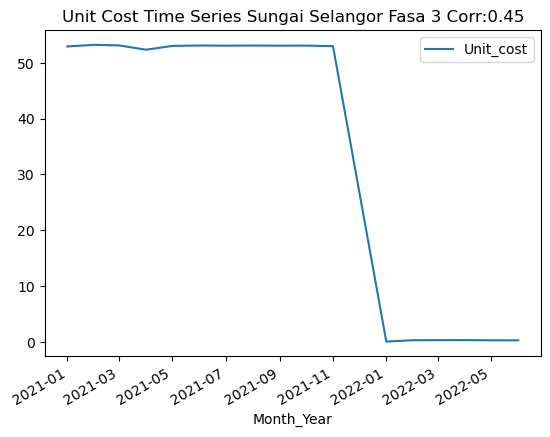

In [548]:
import statsmodels.api as sm
fr = pd.merge(fc,master_db[['wtp']],on = 'wtp',how = 'left')

# define the conditions
#condition = (fr['wtp'] == 'Kuala Kubu Bharu') | (fr['wtp'] == 'Batang Kali')| (fr['wtp'] == 'Sungai Rangkap')
# use loc to update the values
#fr.loc[condition, 'Lembangan'] = 'Sungai Selangor Upstream'

#fr = fr[(fr['wtp'] != 'Sungai Selangor Fasa 2 Stream C') & (fr['wtp'] != 'Bukit Tampoi New') & (fr['wtp'] != 'Salak Tinggi')& (fr['wtp'] != 'Sungai Serai') ]
fr = fr[(fr['Lembangan'] == 'Sg Selangor') & (fr['Month_Year'] < '07-2022')]
# for i in c['wtp'].unique():
#     c[c['wtp']==i].plot(x='Month',y=['WGI_d','WQI'])
#     plt.title(f'WGI VS WQI Time Series {i}')
#     plt.ylabel('Score')
#     plt.show()
#fr[['Unit_cost']] = fr[['Unit_cost']].multiply(10)
columns_target = 'wtp'
core_unit_wgi = []
wtp_corr = []
#columns_target = 'Lembangan'
for i in fr[columns_target].unique():
    # fr[fr[columns_target]==i].plot(x='Month',y=['WGI_d'])
    # plt.title(f'WGI Time Series {i}')
    # plt.ylabel('Score')
    # plt.show()
    # fr[fr[columns_target]==i].plot(x='Month',y=['Unit_cost'])
    # plt.title(f'Unit Cost Time Series {i}')
    # plt.ylabel('Score')
    # plt.show()
    core = fr[fr[columns_target] == i][['WGI_d','Unit_cost']].corr()
    core_unit_wgi.append(core['Unit_cost'][0])
    corr_val =round(core['Unit_cost'][0],2)
    #for i in c['wtp'].unique():
    
    a = fr[fr['wtp']==i].copy()
    t, p = stats.ttest_ind(a['WGI_d'], a['Unit_cost'])

    # print the results
    print("t-value = {:.3f}, p-value = {:.3f}".format(t, p))
    scaler = MinMaxScaler(feature_range=(a['WGI_d'].min(), a['WGI_d'].max()))
    a['Unit_cost'] = scaler.fit_transform(a[['Unit_cost']])
    a.plot(x='Month_Year',y=['WGI_d','Unit_cost'])
    plt.title(f'WGI VS Unit Cost Time Series {i} Corr:{corr_val}')
    plt.ylabel('Score')
    #save = f'Plot/Sg_Sel_2021_2/{i}WGI_UnitCost_TimeSeries_plot_Sg_Selangor.png'
    plt.show()
    wtp_corr.append(i) 
    sns.heatmap(core, annot=True, cmap='coolwarm')
    plt.title(i)
    plt.show()
    #save = f'Plot/Sg_Sel_2021_2/{i}WGI_UnitCost_Corr_plot_Sg_Selangor.png'
    plt.savefig(save)
    fr[fr['wtp']==i].plot(x='Month_Year',y=['Unit_cost'])
    plt.title(f'Unit Cost Time Series {i} Corr:{corr_val}')
    X = fr[fr[columns_target] == i]['WGI_d']
    Y = fr[fr[columns_target] == i]['Unit_cost']
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    print(model.summary())


data = {'wtp': wtp_corr,
        'corr_wgi_unit': core_unit_wgi}
  
# Create DataFrame
corr_df = pd.DataFrame(data)

t-value = nan, p-value = nan


<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Batang Kali Corr:0.14')

Text(0, 0.5, 'Score')

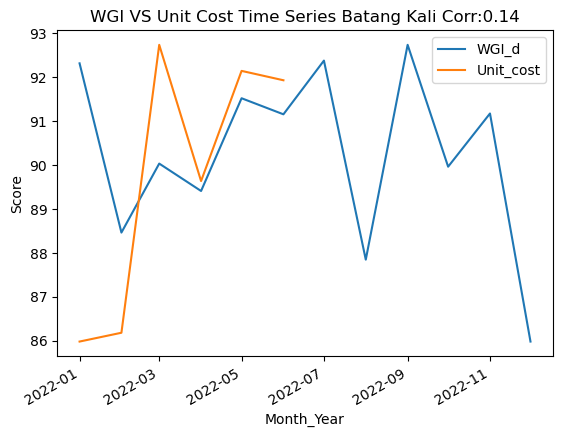

<AxesSubplot:>

Text(0.5, 1.0, 'Batang Kali')

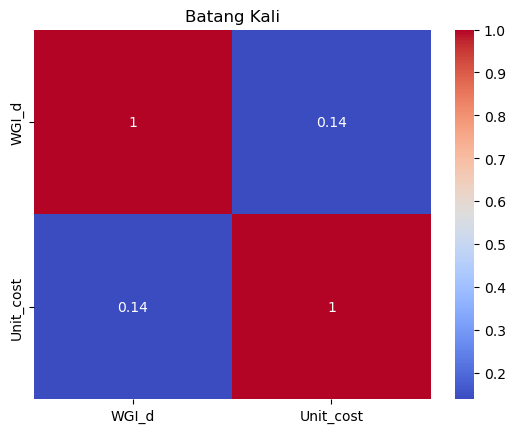

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 20 Mar 2023   Prob (F-statistic):                nan
Time:                        10:54:50   Log-Likelihood:                    nan
No. Observations:                4008   AIC:                               nan
Df Residuals:                    4006   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Kuala Kubu Bharu Corr:-0.58')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

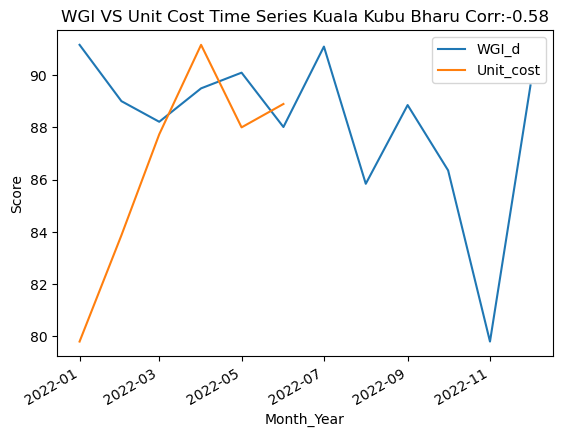

<AxesSubplot:>

Text(0.5, 1.0, 'Kuala Kubu Bharu')

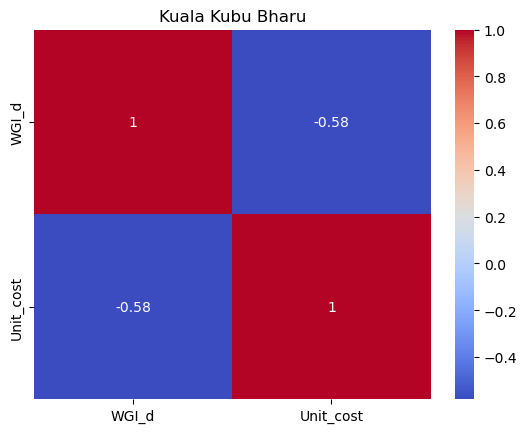

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 20 Mar 2023   Prob (F-statistic):                nan
Time:                        10:54:51   Log-Likelihood:                    nan
No. Observations:                4008   AIC:                               nan
Df Residuals:                    4006   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Rantau Panjang New Corr:-0.7')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

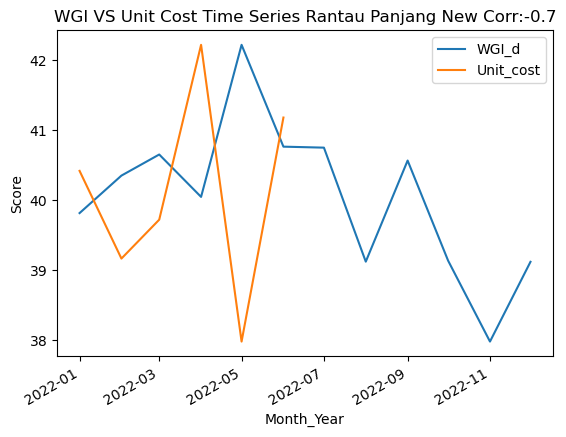

<AxesSubplot:>

Text(0.5, 1.0, 'Rantau Panjang New')

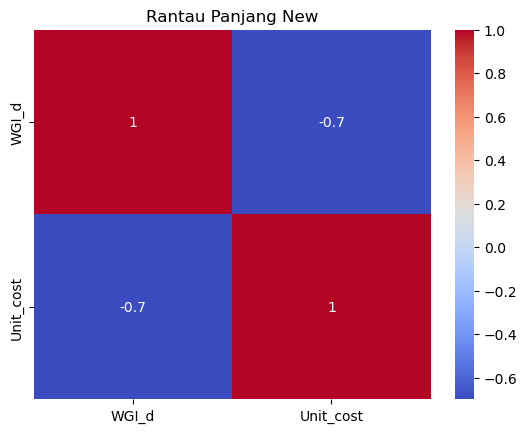

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 20 Mar 2023   Prob (F-statistic):                nan
Time:                        10:54:51   Log-Likelihood:                    nan
No. Observations:                4008   AIC:                               nan
Df Residuals:                    4006   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Rasa Corr:-0.26')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

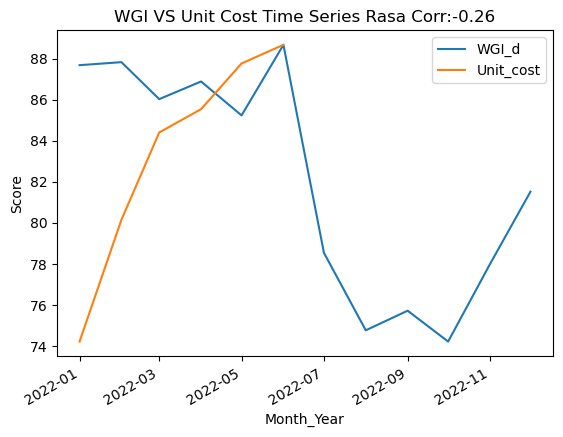

<AxesSubplot:>

Text(0.5, 1.0, 'Rasa')

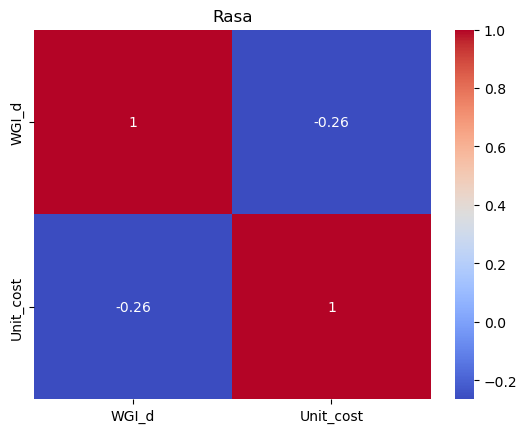

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 20 Mar 2023   Prob (F-statistic):                nan
Time:                        10:54:51   Log-Likelihood:                    nan
No. Observations:                4008   AIC:                               nan
Df Residuals:                    4006   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Sungai Rangkap Corr:0.69')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

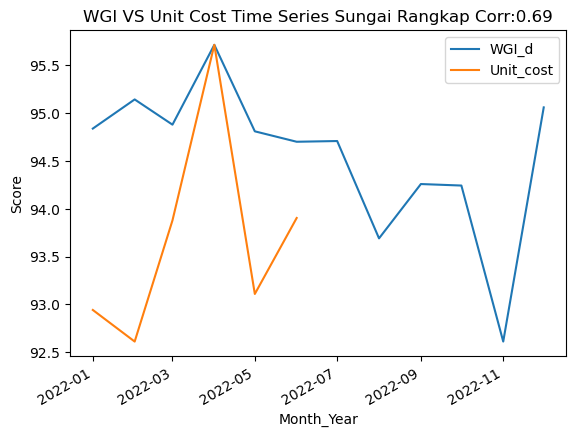

<AxesSubplot:>

Text(0.5, 1.0, 'Sungai Rangkap')

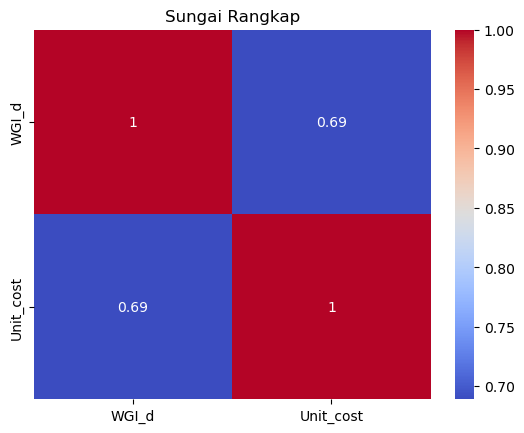

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 20 Mar 2023   Prob (F-statistic):                nan
Time:                        10:54:52   Log-Likelihood:                    nan
No. Observations:                4008   AIC:                               nan
Df Residuals:                    4006   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Sungai Selangor Fasa 1 Corr:-0.67')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

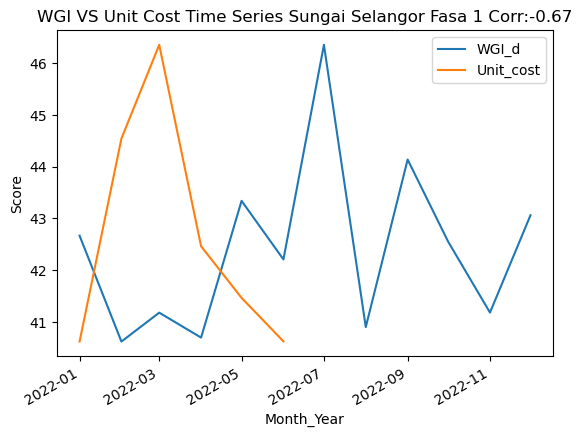

<AxesSubplot:>

Text(0.5, 1.0, 'Sungai Selangor Fasa 1')

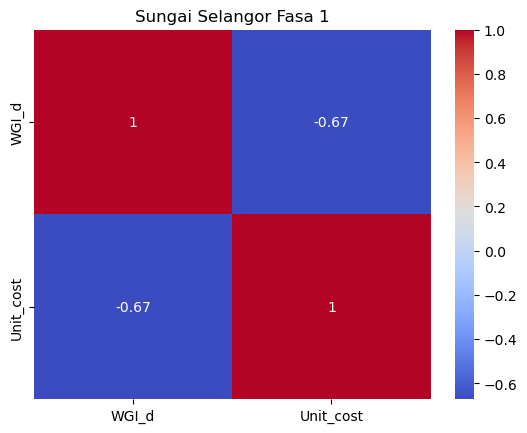

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 20 Mar 2023   Prob (F-statistic):                nan
Time:                        10:54:52   Log-Likelihood:                    nan
No. Observations:                3996   AIC:                               nan
Df Residuals:                    3994   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Sungai Selangor Fasa 2 Stream C Corr:-0.52')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

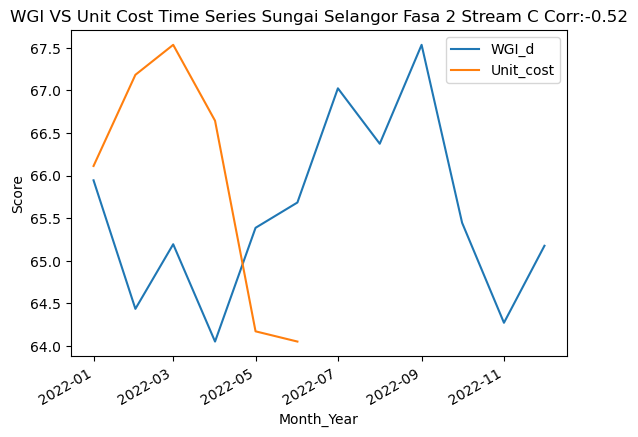

<AxesSubplot:>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream C')

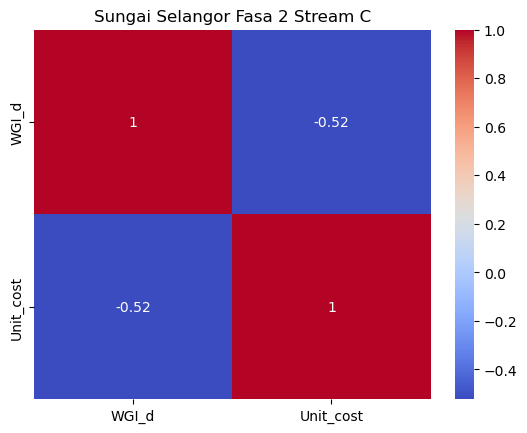

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 20 Mar 2023   Prob (F-statistic):                nan
Time:                        10:54:52   Log-Likelihood:                    nan
No. Observations:                4008   AIC:                               nan
Df Residuals:                    4006   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

<AxesSubplot:xlabel='Month_Year'>

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Sungai Selangor Fasa 3 Corr:-0.6')

Text(0, 0.5, 'Score')

<Figure size 640x480 with 0 Axes>

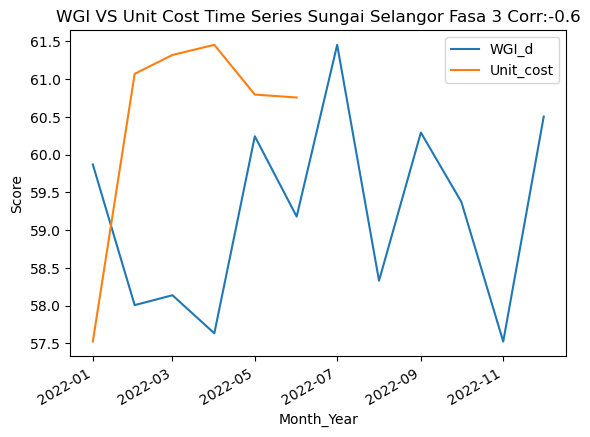

<AxesSubplot:>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3')

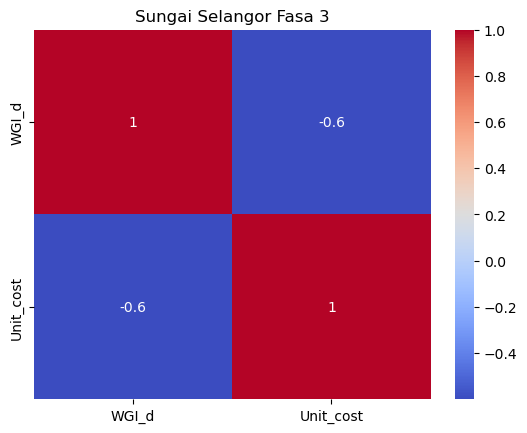

                            OLS Regression Results                            
Dep. Variable:              Unit_cost   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 20 Mar 2023   Prob (F-statistic):                nan
Time:                        10:54:53   Log-Likelihood:                    nan
No. Observations:                3996   AIC:                               nan
Df Residuals:                    3994   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

<Figure size 640x480 with 0 Axes>

In [549]:
import statsmodels.api as sm
fr = pd.merge(fc,master_db[['wtp']],on = 'wtp',how = 'left')

# define the conditions
#condition = (fr['wtp'] == 'Kuala Kubu Bharu') | (fr['wtp'] == 'Batang Kali')| (fr['wtp'] == 'Sungai Rangkap')
# use loc to update the values
#fr.loc[condition, 'Lembangan'] = 'Sungai Selangor Upstream'

#fr = fr[(fr['wtp'] != 'Sungai Selangor Fasa 2 Stream C') & (fr['wtp'] != 'Bukit Tampoi New') & (fr['wtp'] != 'Salak Tinggi')& (fr['wtp'] != 'Sungai Serai') ]
fr = fr[(fr['Lembangan'] == 'Sg Selangor') & (fr['Month_Year'] > '12-2021')]
# for i in c['wtp'].unique():
#     c[c['wtp']==i].plot(x='Month',y=['WGI_d','WQI'])
#     plt.title(f'WGI VS WQI Time Series {i}')
#     plt.ylabel('Score')
#     plt.show()
#fr[['Unit_cost']] = fr[['Unit_cost']].multiply(10)
columns_target = 'wtp'
core_unit_wgi = []
wtp_corr = []
#columns_target = 'Lembangan'
for i in fr[columns_target].unique():
    # fr[fr[columns_target]==i].plot(x='Month',y=['WGI_d'])
    # plt.title(f'WGI Time Series {i}')
    # plt.ylabel('Score')
    # plt.show()
    # fr[fr[columns_target]==i].plot(x='Month',y=['Unit_cost'])
    # plt.title(f'Unit Cost Time Series {i}')
    # plt.ylabel('Score')
    # plt.show()
    core = fr[fr[columns_target] == i][['WGI_d','Unit_cost']].corr()
    core_unit_wgi.append(core['Unit_cost'][0])
    corr_val =round(core['Unit_cost'][0],2)
    #for i in c['wtp'].unique():
    
    a = fr[fr['wtp']==i].copy()
    t, p = stats.ttest_ind(a['WGI_d'], a['Unit_cost'])

    # print the results
    print("t-value = {:.3f}, p-value = {:.3f}".format(t, p))
    scaler = MinMaxScaler(feature_range=(a['WGI_d'].min(), a['WGI_d'].max()))
    a['Unit_cost'] = scaler.fit_transform(a[['Unit_cost']])
    a.plot(x='Month_Year',y=['WGI_d','Unit_cost'])
    plt.title(f'WGI VS Unit Cost Time Series {i} Corr:{corr_val}')
    plt.ylabel('Score')
    #save = f'Plot/Sg_Sel_2021_2/{i}WGI_UnitCost_TimeSeries_plot_Sg_Selangor.png'
    plt.show()
    wtp_corr.append(i) 
    sns.heatmap(core, annot=True, cmap='coolwarm')
    plt.title(i)
    plt.show()
    #save = f'Plot/Sg_Sel_2021_2/{i}WGI_UnitCost_Corr_plot_Sg_Selangor.png'
    plt.savefig(save)
    X = fr[fr[columns_target] == i]['WGI_d']
    Y = fr[fr[columns_target] == i]['Unit_cost']
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    print(model.summary())


data = {'wtp': wtp_corr,
        'corr_wgi_unit': core_unit_wgi}
  
# Create DataFrame
corr_df = pd.DataFrame(data)

In [518]:
fr.columns

Index(['wtp', 'Month_Year', 'pH_Sc', 'SS_sc', 'Co_Sc', 'Iron_Sc', 'Amm_Sc',
       'Mgn_Sc', 'WGI', 'WGI_c', 'WGI_d', 'Lembangan', 'Unit_cost'],
      dtype='object')

In [519]:
corr_df.sort_values('corr_wgi_unit')  #[corr_df['corr_wgi_unit'] > -0.]#['wtp'].to_list()
#corr_df.to_csv('Plot\Result\correlation_unified_weight_WGI_Sg_Selangor_3.csv')

wtp  corr_wgi_unit
2               Rantau Panjang New      -0.717291
5           Sungai Selangor Fasa 1      -0.661636
1                 Kuala Kubu Bharu      -0.597653
7           Sungai Selangor Fasa 3      -0.570204
6  Sungai Selangor Fasa 2 Stream C      -0.473455
3                             Rasa      -0.261382
0                      Batang Kali       0.154165
4                   Sungai Rangkap       0.732779

In [483]:
core = fr[['WQI','WGI_d','Unit_cost']].corr()
sns.heatmap(core, annot=True, cmap='coolwarm')

KeyError: "['WQI'] not in index"

In [66]:
fc.groupby('wtp')[['WGI_d','WQI','Unit_cost']].mean().sort_values(by='WGI_d',ascending=False)

WGI_d        WQI  Unit_cost
wtp                                                             
Sungai Lolo - Baru               95.720776  94.400000   4.527599
Sungai Pangsoon                  95.407785  95.154545   3.653661
Sungai Serai                     94.712647  95.545455  10.487718
Sungai Rumput                    92.395470  93.736364  16.685140
Kalumpang                        91.752331  95.545455   4.865266
Labohan Dagang                   91.400315  90.100000   6.421107
Sungai Labu                      90.552404  81.863636   2.871870
Sungai Rangkap                   90.233071  94.490909   4.721915
Semenyih 2                       90.133670  79.472727   5.699350
Kepong                           90.100488  94.936364   6.095540
Kuala Kubu Bharu                 89.199316  95.863636   4.477614
Sungai Gombak                    87.613969  94.409091   4.008616
Sungai Batu                      87.070361  89.700000   2.643524
Batang Kali                      86.803912  90.472727  18.383914
Rasa                             77.355751  90.181818   0.006989
Salak Tinggi                     73.895502  66.345455   8.571474
Bukit Nanas                      70.674828  71.736364   3.114537
Ampang Intake                    69.973446  92.581818   8.650482
Bukit Tampoi New                 68.698687  73.400000  14.167527
Sungai Semenyih                  65.107568  74.590909   3.310553
Wangsa Maju                      65.004077  73.700000   2.763904
Sungai Dusun                     64.978607  92.572727  10.566502
North Hummock                    63.357157  72.363636  11.085536
Langat 2                         62.812622  92.054545   3.873350
Sungai Langat                    61.374913  88.418182   4.170874
Cheras Batu 11                   57.582346  74.000000   7.345932
Sungai Tengi                     56.013961  92.672727   8.767862
Bernam River Headworks (Old)     55.868143        NaN   6.316159
Sungai Selangor Fasa 2 Stream C  55.741708  81.672727   4.822555
Bernam River Headworks (New)     54.740347  85.936364        NaN
Sungai Selangor Fasa 3           54.068039  80.972727   0.000000
Sungai Selisek                   52.292556  88.900000  11.110208
Sungai Selangor Fasa 1           45.723404  83.754545   1.488503
Rantau Panjang New               40.604421  84.554545   5.500688
Rantau Panjang Old               40.311969        NaN        NaN
Sungai Sireh                     29.378132  83.281818  19.601485

In [ ]:
## Treated vs Raw Water

In [158]:
treated_WQ = pd.read_csv('outlier_removal\Raw_File\WTP Treated Water Quality Data (2022).csv')
treated_WQ.loc[treated_WQ['WTP'] == 'Sungai Selangor Fasa 2', 'WTP'] = 'Sungai Selangor Fasa 2 Stream C'
treated_WQ.loc[treated_WQ['WTP'] == 'Rantau Panjang', 'WTP'] = 'Rantau Panjang New'
treated_WQ['wtp'] = treated_WQ['WTP']
treated_WQ = treated_WQ.drop('WTP',axis = 1)
treated_WQ['TestDate'] = pd.to_datetime(treated_WQ['TestDate'])
treated_WQ['Month_Year'] = treated_WQ['TestDate'].dt.strftime('%m-%Y')
treated_WQ['metrix'] = treated_WQ['TreatedWaterTotalViolation']
treated_WQ

Parsing '14/10/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '13/10/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '16/10/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '17/10/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '15/10/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '19/10/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '18/10/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '20/10/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '21/10/2022' in DD/MM/YYYY forma

TestDate TreatedWaterTotalTest TreatedWaterTotalViolation  \
0     2022-01-01                TW1020                         pH   
1     2022-01-01                TW1030                      Color   
2     2022-01-01                TW1040                  Turbidity   
3     2022-01-01                TW1050            Ferum/Iron (Fe)   
4     2022-01-01                TW1070              Ammonia (NH4)   
...          ...                   ...                        ...   
78805 2022-12-31                TW1030                      Color   
78806 2022-12-31                TW1040                  Turbidity   
78807 2022-12-31                TW1050            Ferum/Iron (Fe)   
78808 2022-12-31                TW1070              Ammonia (NH4)   
78809 2022-12-31                TW1080             Manganese (Mn)   

       wqc_tre_total_min  wqc_tre_total_avg  wqc_tre_total_max  \
0                   6.90               7.01               7.12   
1                   1.00               3.04               7.00   
2                   0.80               1.54               2.11   
3                   0.01               0.01               0.02   
4                   0.01               0.01               0.01   
...                  ...                ...                ...   
78805               2.00               2.17               3.00   
78806               0.34               0.55               1.02   
78807               0.03               0.04               0.04   
78808               0.01               0.01               0.01   
78809               0.01               0.01               0.02   

                    wtp Month_Year           metrix  
0      Kuala Kubu Bharu    01-2022               pH  
1      Kuala Kubu Bharu    01-2022            Color  
2      Kuala Kubu Bharu    01-2022        Turbidity  
3      Kuala Kubu Bharu    01-2022  Ferum/Iron (Fe)  
4      Kuala Kubu Bharu    01-2022    Ammonia (NH4)  
...                 ...        ...              ...  
78805      Sungai Sireh    12-2022            Color  
78806      Sungai Sireh    12-2022        Turbidity  
78807      Sungai Sireh    12-2022  Ferum/Iron (Fe)  
78808      Sungai Sireh    12-2022    Ammonia (NH4)  
78809      Sungai Sireh    12-2022   Manganese (Mn)  

[78810 rows x 9 columns]

In [159]:
raw_WQ = pd.read_csv('outlier_removal\Raw_File\WTP Raw Water Quality Data (2022) All.csv')
raw_WQ.loc[raw_WQ['WTP'] == 'Sungai Selangor Fasa 2', 'WTP'] = 'Sungai Selangor Fasa 2 Stream C'
raw_WQ.loc[raw_WQ['WTP'] == 'Rantau Panjang', 'WTP'] = 'Rantau Panjang New'
raw_WQ['wtp'] = raw_WQ['WTP']
raw_WQ = raw_WQ.drop('WTP',axis = 1)
raw_WQ['TestDate'] = pd.to_datetime(raw_WQ['TestDate'])
raw_WQ['Month_Year'] = raw_WQ['TestDate'].dt.strftime('%m-%Y')
raw_WQ['metrix'] = raw_WQ['RawWaterTotalViolation']
raw_WQ

Parsing '14/10/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '13/10/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '15/10/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '17/10/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '16/10/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '18/10/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '20/10/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '19/10/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
Parsing '21/10/2022' in DD/MM/YYYY forma

TestDate RawWaterTotalViolation  wqc_raw_total_min  wqc_raw_total_avg  \
0     2022-02-01                     pH               6.65               6.73   
1     2022-02-01                  Color             120.00             278.79   
2     2022-02-01              Turbidity              30.10              77.17   
3     2022-02-01        Ferum/Iron (Fe)               0.50               0.71   
4     2022-02-01          Ammonia (NH4)               0.09               0.12   
...          ...                    ...                ...                ...   
78805 2022-12-31                  Color              22.00              26.58   
78806 2022-12-31              Turbidity               5.70               8.58   
78807 2022-12-31        Ferum/Iron (Fe)               0.91               1.03   
78808 2022-12-31          Ammonia (NH4)               0.01               0.02   
78809 2022-12-31         Manganese (Mn)               0.06               0.07   

       wqc_raw_total_max             wtp Month_Year           metrix  
0                   6.84  Sungai Selisek    02-2022               pH  
1                 789.00  Sungai Selisek    02-2022            Color  
2                 212.00  Sungai Selisek    02-2022        Turbidity  
3                   0.86  Sungai Selisek    02-2022  Ferum/Iron (Fe)  
4                   0.16  Sungai Selisek    02-2022    Ammonia (NH4)  
...                  ...             ...        ...              ...  
78805              34.00            Rasa    12-2022            Color  
78806              13.00            Rasa    12-2022        Turbidity  
78807               1.14            Rasa    12-2022  Ferum/Iron (Fe)  
78808               0.02            Rasa    12-2022    Ammonia (NH4)  
78809               0.08            Rasa    12-2022   Manganese (Mn)  

[78810 rows x 8 columns]

In [160]:
fd = fc[fc['Lembangan'] == 'Sg Selangor'].copy()
fd['Month_Year'] = fd['Month_Year'].dt.strftime('%m-%Y')
fd

wtp Month_Year      pH_Sc      SS_sc      Co_Sc  \
23              Batang Kali    01-2021  98.584898  90.715256  97.207957   
24              Batang Kali    01-2022  98.985646  83.865449  97.956129   
25              Batang Kali    02-2021  98.515513  90.760754  99.226190   
26              Batang Kali    02-2022  99.011106  76.255839  98.332143   
27              Batang Kali    03-2021  98.145760  88.293993  95.833548   
..                      ...        ...        ...        ...        ...   
685  Sungai Selangor Fasa 3    10-2021  83.830145  58.312615  74.978280   
686  Sungai Selangor Fasa 3    10-2022  86.582986  43.885636  76.264516   
687  Sungai Selangor Fasa 3    11-2021  84.008694  42.581882  75.816444   
688  Sungai Selangor Fasa 3    11-2022  84.212125  38.327676  76.386889   
689  Sungai Selangor Fasa 3    12-2022  92.011779  47.128452  75.360215   

       Iron_Sc     Amm_Sc     Mgn_Sc        WGI      WGI_c      WGI_d  \
23   80.838710  88.749174  90.000000  93.277217  92.624683  91.946860   
24   81.580645  90.238978  85.483871  92.160062  91.447722  91.741067   
25   81.035714  97.184195  93.928571  94.950597  94.387192  94.433854   
26   74.607143  78.794555  72.500000  87.822235  86.648449  86.803054   
27   73.225806  84.847094  87.741935  91.026935  90.143699  89.049018   
..         ...        ...        ...        ...        ...        ...   
685   0.000000  91.219355  22.741935  63.504867  61.022306  62.195281   
686   0.322581  87.188710  15.967742  61.102331  58.351028  60.654919   
687   0.200000  88.495000  11.333333  59.658331  56.959564  59.782272   
688   0.000000  85.590000   5.833333  58.267308  55.447984  58.608054   
689   0.000000  86.106786  12.741935  62.645015  59.737487  61.401950   

       Lembangan  Unit_cost  
23   Sg Selangor  12.593988  
24   Sg Selangor  20.077182  
25   Sg Selangor  17.709801  
26   Sg Selangor  20.252403  
27   Sg Selangor  16.853729  
..           ...        ...  
685  Sg Selangor   0.000000  
686  Sg Selangor        NaN  
687  Sg Selangor   0.000000  
688  Sg Selangor        NaN  
689  Sg Selangor        NaN  

[195 rows x 13 columns]

In [167]:
treated_WQ_Sel = pd.merge(treated_WQ,fd[['wtp','Lembangan']].drop_duplicates(), on = 'wtp',how = 'left')
treated_WQ_Sel.dropna(subset=['Lembangan'], inplace=True)
treated_WQ_Sel = treated_WQ_Sel[['TestDate','metrix','wqc_tre_total_avg','wtp']].copy()
treated_WQ_Sel

TestDate           metrix  wqc_tre_total_avg               wtp
0     2022-01-01               pH               7.01  Kuala Kubu Bharu
1     2022-01-01            Color               3.04  Kuala Kubu Bharu
2     2022-01-01        Turbidity               1.54  Kuala Kubu Bharu
3     2022-01-01  Ferum/Iron (Fe)               0.01  Kuala Kubu Bharu
4     2022-01-01    Ammonia (NH4)               0.01  Kuala Kubu Bharu
...          ...              ...                ...               ...
78747 2022-12-31            Color               0.00       Batang Kali
78748 2022-12-31        Turbidity               0.16       Batang Kali
78749 2022-12-31  Ferum/Iron (Fe)               0.01       Batang Kali
78750 2022-12-31    Ammonia (NH4)               0.00       Batang Kali
78751 2022-12-31   Manganese (Mn)               0.00       Batang Kali

[17520 rows x 4 columns]

In [168]:
raw_WQ_Sel = pd.merge(raw_WQ,fd[['wtp','Lembangan']].drop_duplicates(), on = 'wtp',how = 'left')
raw_WQ_Sel.dropna(subset=['Lembangan'], inplace=True)
raw_WQ_Sel = raw_WQ_Sel[['TestDate','metrix','wqc_raw_total_avg','wtp']].copy()

In [169]:
treated_vs_raw_pd = pd.merge(raw_WQ_Sel,treated_WQ_Sel,on = ['TestDate','metrix','wtp'],how = 'left')

In [174]:
treated_vs_raw_pd['wtp'].unique()

array(['Sungai Selangor Fasa 3', 'Sungai Selangor Fasa 1',
       'Sungai Selangor Fasa 2 Stream C', 'Kuala Kubu Bharu', 'Rasa',
       'Rantau Panjang New', 'Batang Kali', 'Sungai Rangkap'],
      dtype=object)

<AxesSubplot:title={'center':'pH Sungai Selangor Fasa 3'}, xlabel='TestDate'>

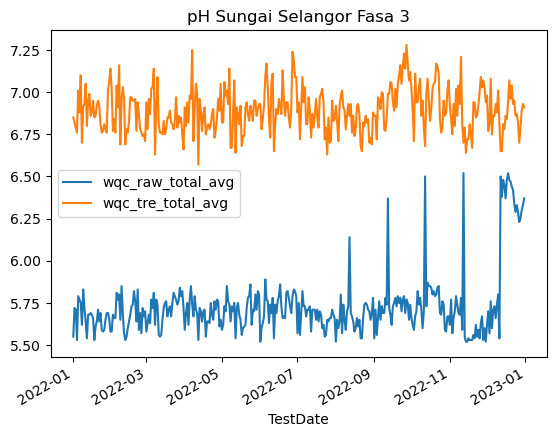

<AxesSubplot:>

Text(0.5, 1.0, 'pH Sungai Selangor Fasa 3')

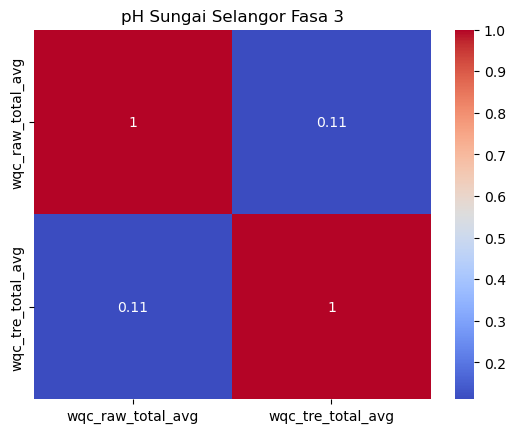

<AxesSubplot:title={'center':'pH Sungai Selangor Fasa 1'}, xlabel='TestDate'>

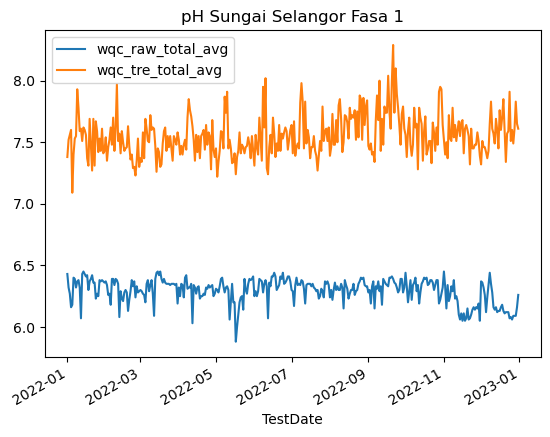

<AxesSubplot:>

Text(0.5, 1.0, 'pH Sungai Selangor Fasa 1')

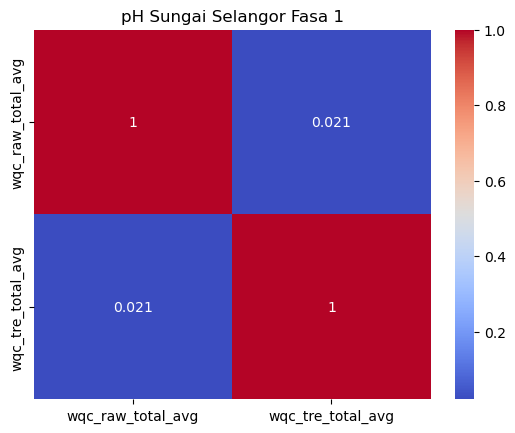

<AxesSubplot:title={'center':'pH Sungai Selangor Fasa 2 Stream C'}, xlabel='TestDate'>

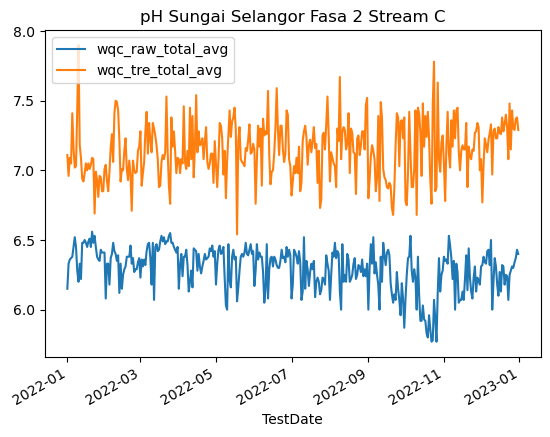

<AxesSubplot:>

Text(0.5, 1.0, 'pH Sungai Selangor Fasa 2 Stream C')

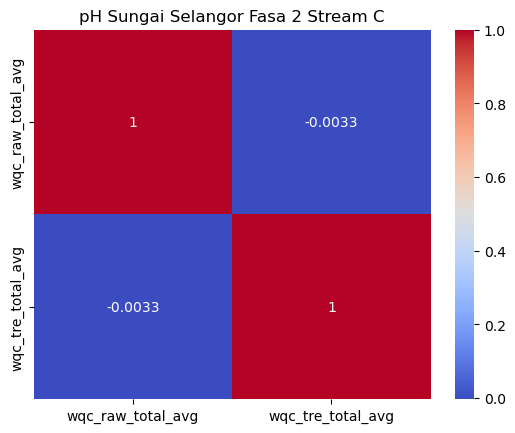

<AxesSubplot:title={'center':'pH Kuala Kubu Bharu'}, xlabel='TestDate'>

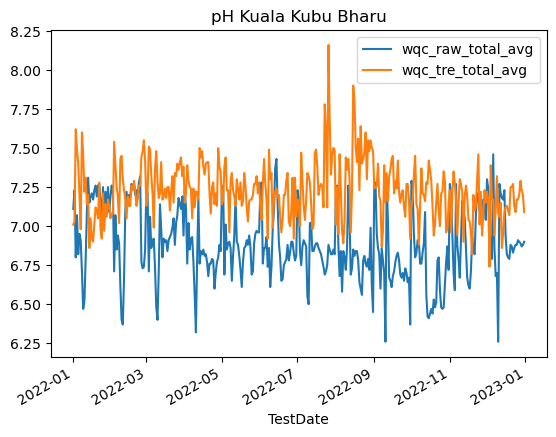

<AxesSubplot:>

Text(0.5, 1.0, 'pH Kuala Kubu Bharu')

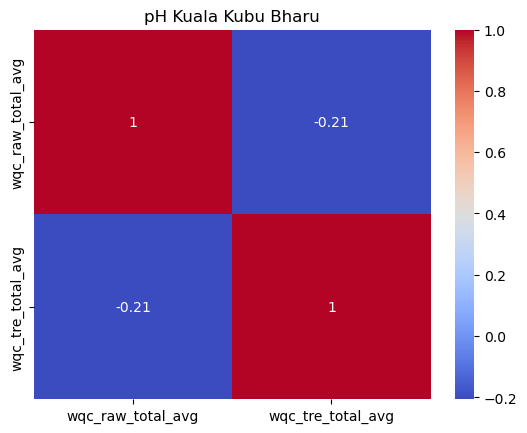

<AxesSubplot:title={'center':'pH Rasa'}, xlabel='TestDate'>

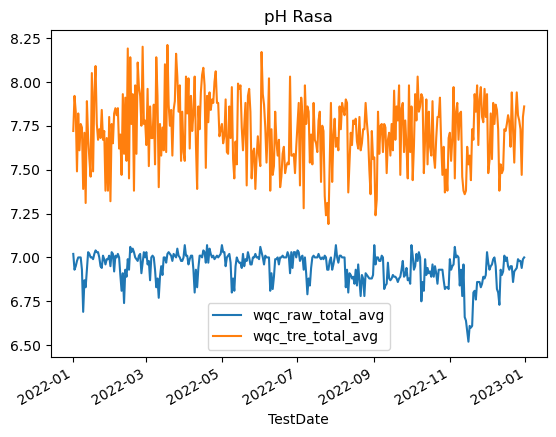

<AxesSubplot:>

Text(0.5, 1.0, 'pH Rasa')

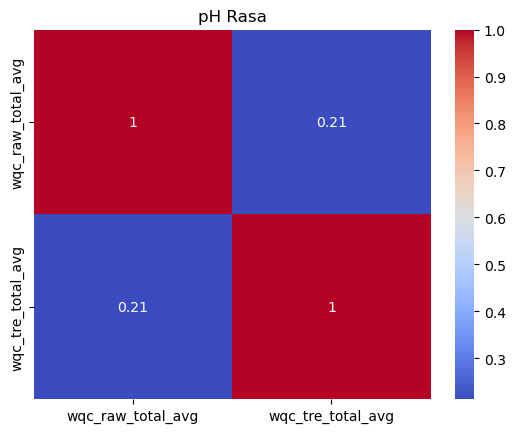

<AxesSubplot:title={'center':'pH Rantau Panjang New'}, xlabel='TestDate'>

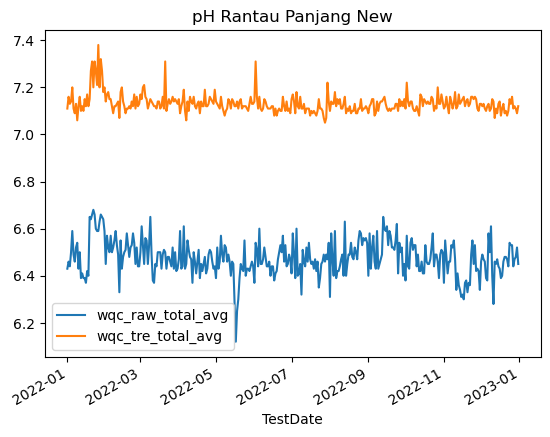

<AxesSubplot:>

Text(0.5, 1.0, 'pH Rantau Panjang New')

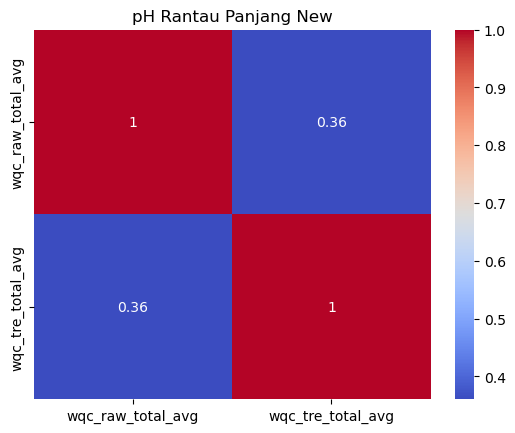

<AxesSubplot:title={'center':'pH Batang Kali'}, xlabel='TestDate'>

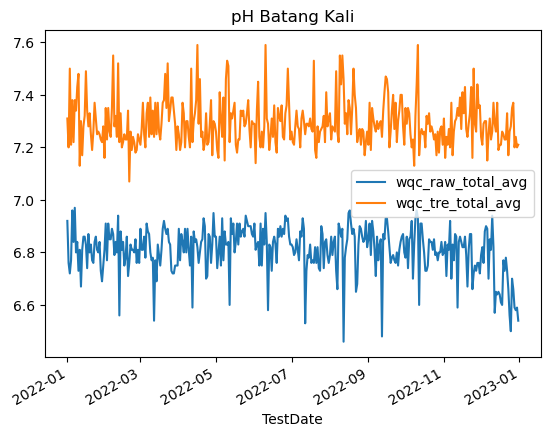

<AxesSubplot:>

Text(0.5, 1.0, 'pH Batang Kali')

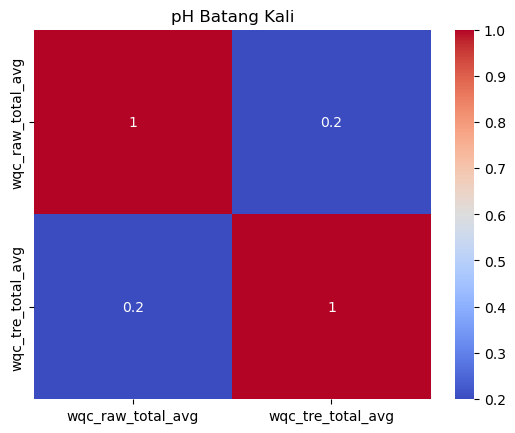

<AxesSubplot:title={'center':'pH Sungai Rangkap'}, xlabel='TestDate'>

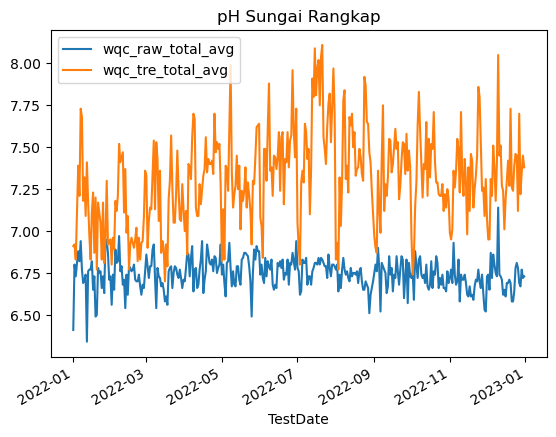

<AxesSubplot:>

Text(0.5, 1.0, 'pH Sungai Rangkap')

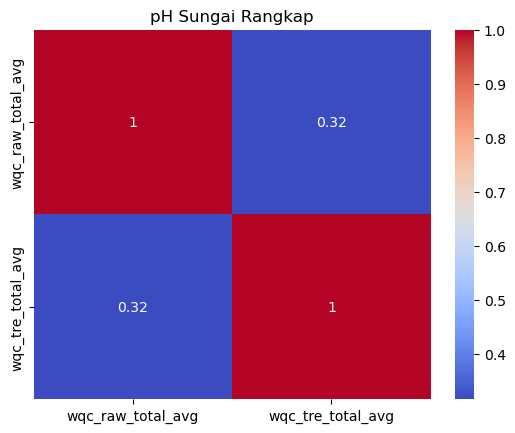

<AxesSubplot:title={'center':'Color Sungai Selangor Fasa 3'}, xlabel='TestDate'>

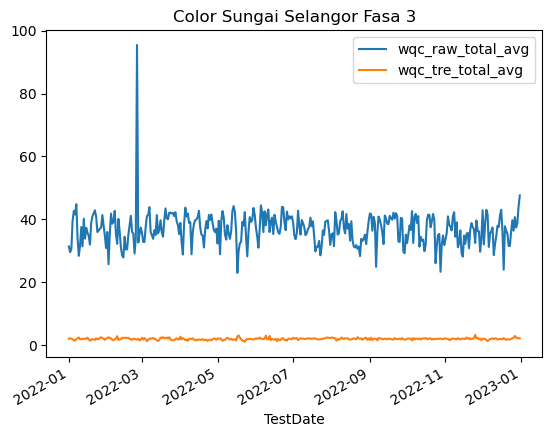

<AxesSubplot:>

Text(0.5, 1.0, 'Color Sungai Selangor Fasa 3')

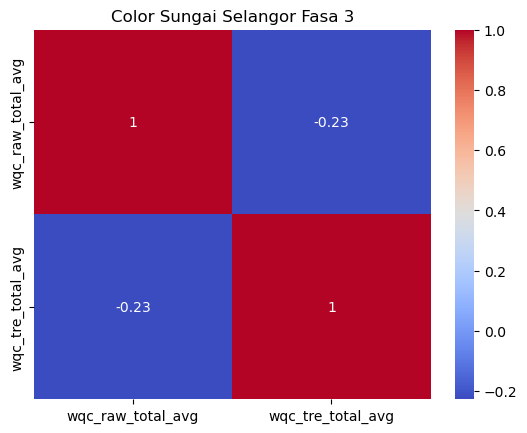

<AxesSubplot:title={'center':'Color Sungai Selangor Fasa 1'}, xlabel='TestDate'>

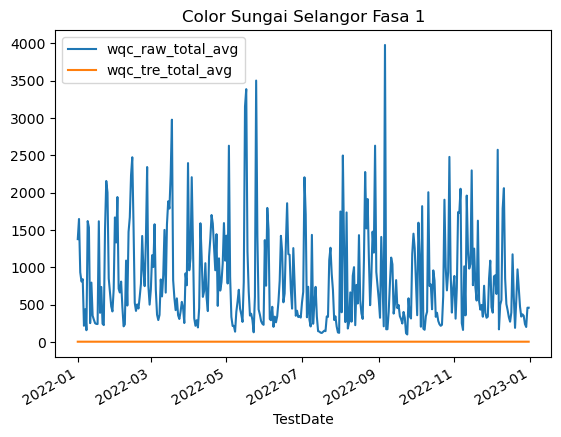

<AxesSubplot:>

Text(0.5, 1.0, 'Color Sungai Selangor Fasa 1')

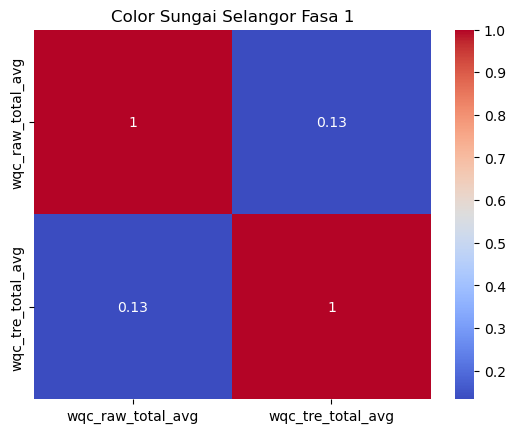

<AxesSubplot:title={'center':'Color Sungai Selangor Fasa 2 Stream C'}, xlabel='TestDate'>

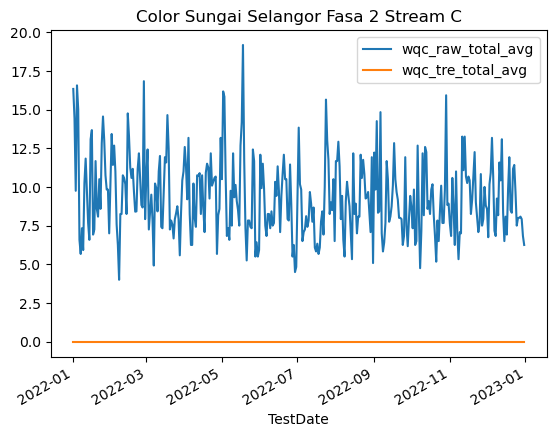

<AxesSubplot:>

Text(0.5, 1.0, 'Color Sungai Selangor Fasa 2 Stream C')

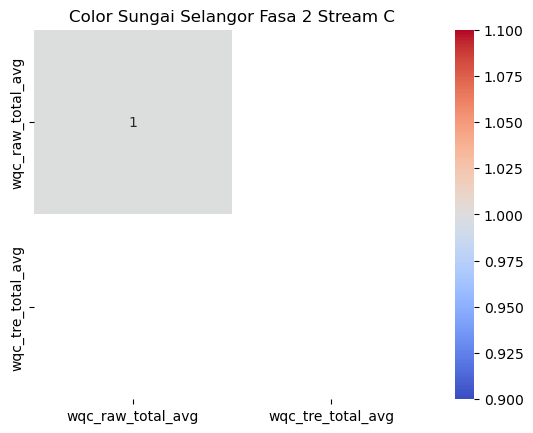

<AxesSubplot:title={'center':'Color Kuala Kubu Bharu'}, xlabel='TestDate'>

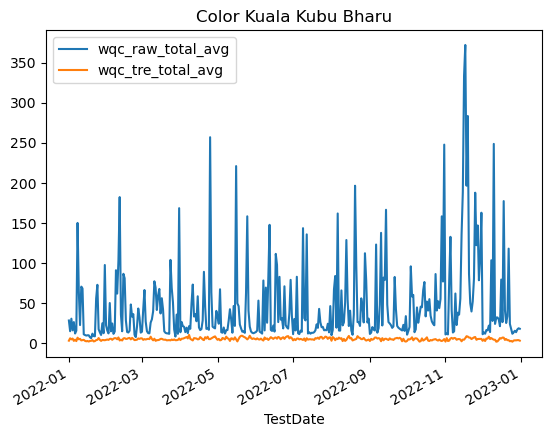

<AxesSubplot:>

Text(0.5, 1.0, 'Color Kuala Kubu Bharu')

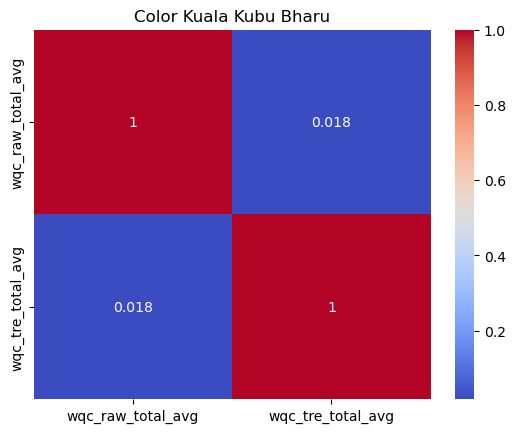

<AxesSubplot:title={'center':'Color Rasa'}, xlabel='TestDate'>

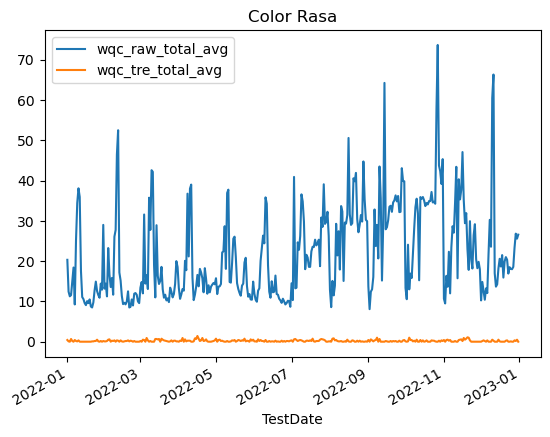

<AxesSubplot:>

Text(0.5, 1.0, 'Color Rasa')

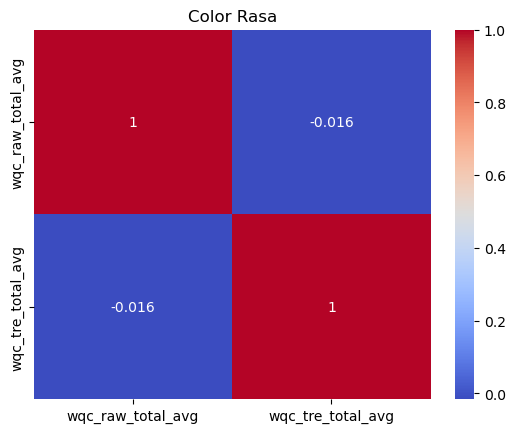

<AxesSubplot:title={'center':'Color Rantau Panjang New'}, xlabel='TestDate'>

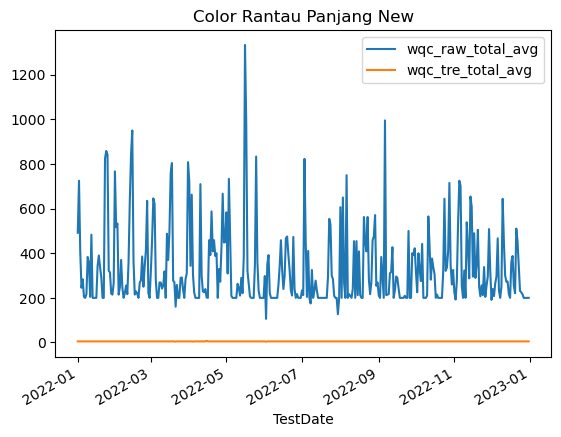

<AxesSubplot:>

Text(0.5, 1.0, 'Color Rantau Panjang New')

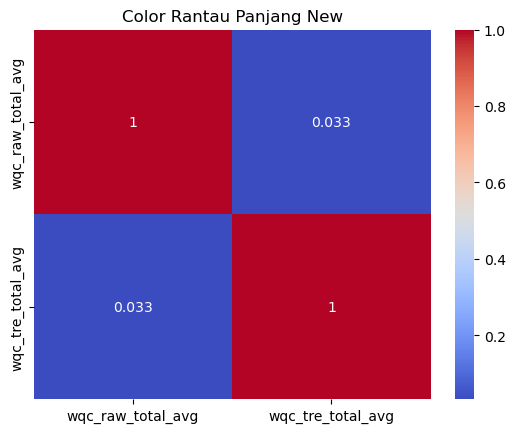

<AxesSubplot:title={'center':'Color Batang Kali'}, xlabel='TestDate'>

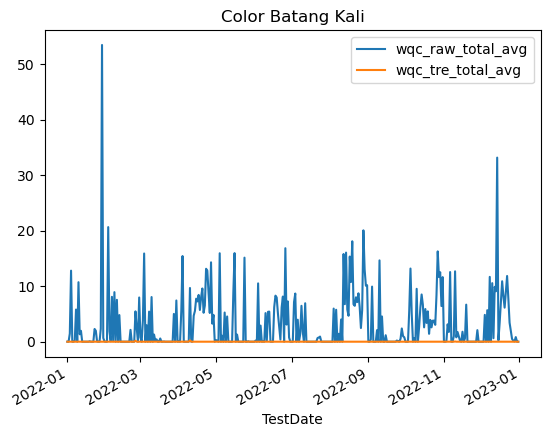

<AxesSubplot:>

Text(0.5, 1.0, 'Color Batang Kali')

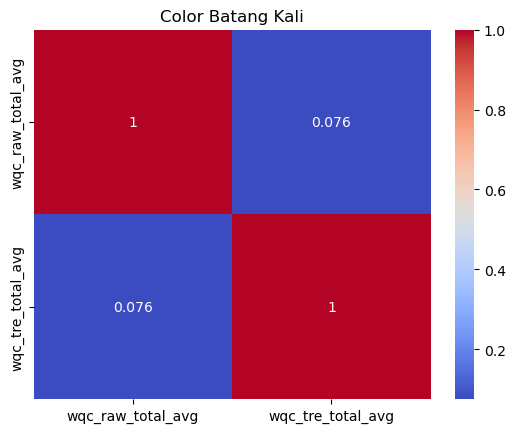

<AxesSubplot:title={'center':'Color Sungai Rangkap'}, xlabel='TestDate'>

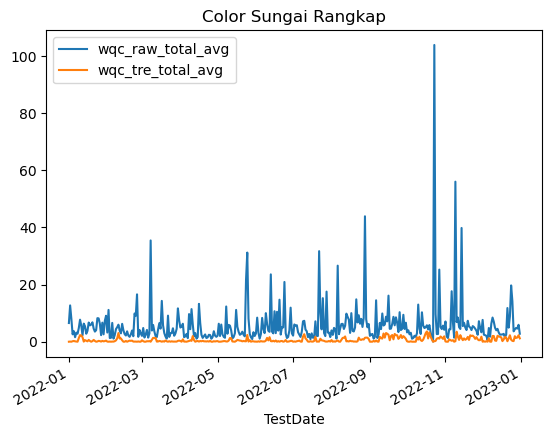

<AxesSubplot:>

Text(0.5, 1.0, 'Color Sungai Rangkap')

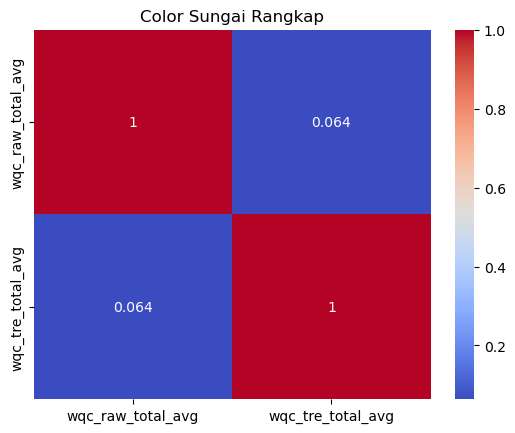

<AxesSubplot:title={'center':'Turbidity Sungai Selangor Fasa 3'}, xlabel='TestDate'>

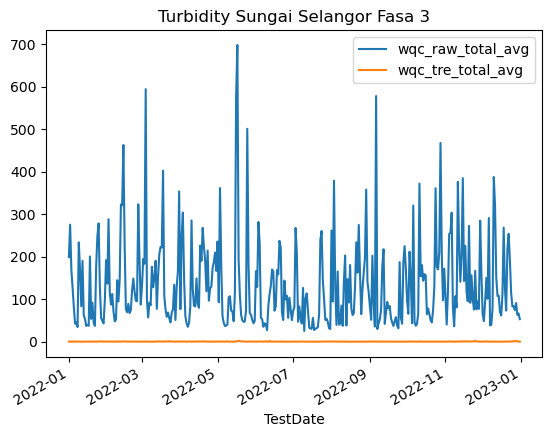

<AxesSubplot:>

Text(0.5, 1.0, 'Turbidity Sungai Selangor Fasa 3')

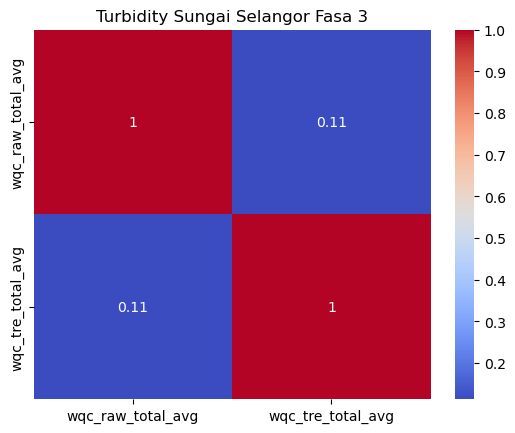

<AxesSubplot:title={'center':'Turbidity Sungai Selangor Fasa 1'}, xlabel='TestDate'>

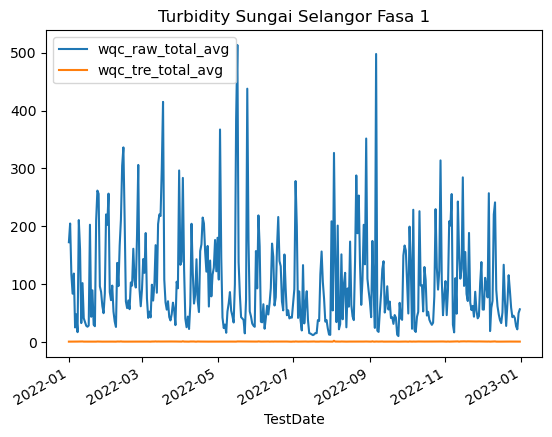

<AxesSubplot:>

Text(0.5, 1.0, 'Turbidity Sungai Selangor Fasa 1')

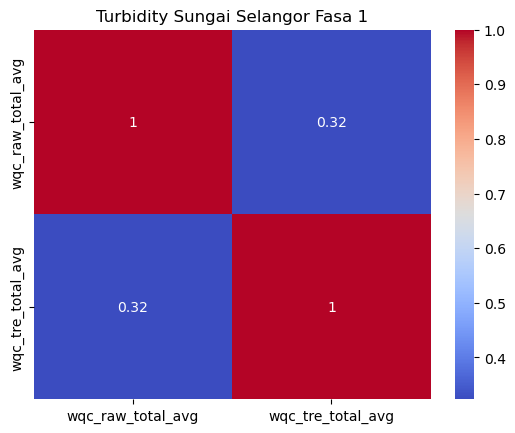

<AxesSubplot:title={'center':'Turbidity Sungai Selangor Fasa 2 Stream C'}, xlabel='TestDate'>

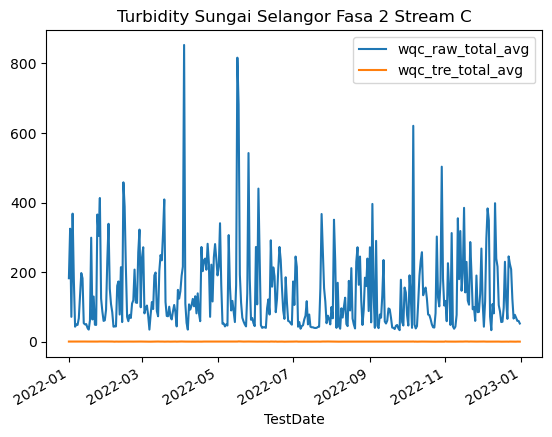

<AxesSubplot:>

Text(0.5, 1.0, 'Turbidity Sungai Selangor Fasa 2 Stream C')

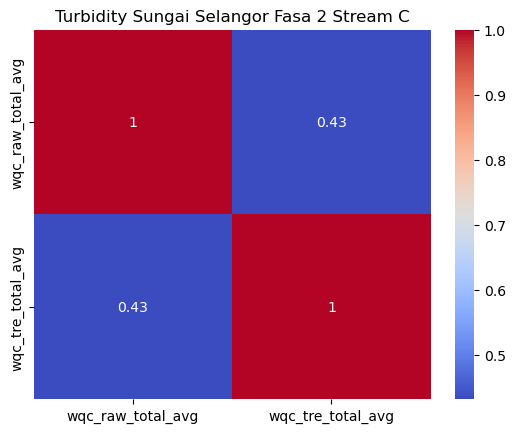

<AxesSubplot:title={'center':'Turbidity Kuala Kubu Bharu'}, xlabel='TestDate'>

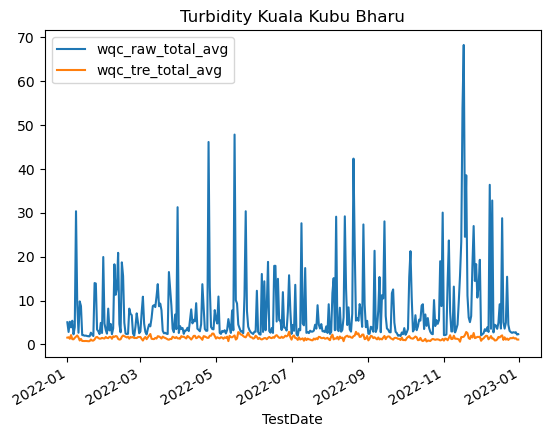

<AxesSubplot:>

Text(0.5, 1.0, 'Turbidity Kuala Kubu Bharu')

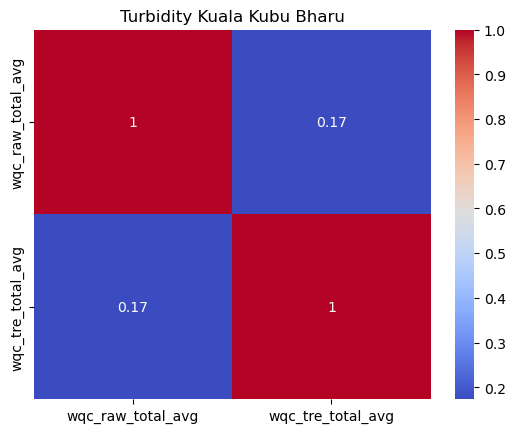

<AxesSubplot:title={'center':'Turbidity Rasa'}, xlabel='TestDate'>

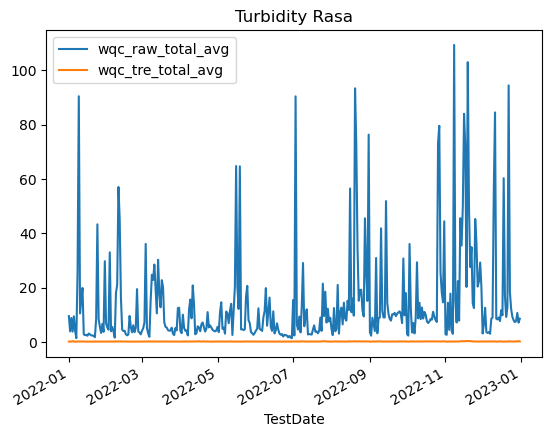

<AxesSubplot:>

Text(0.5, 1.0, 'Turbidity Rasa')

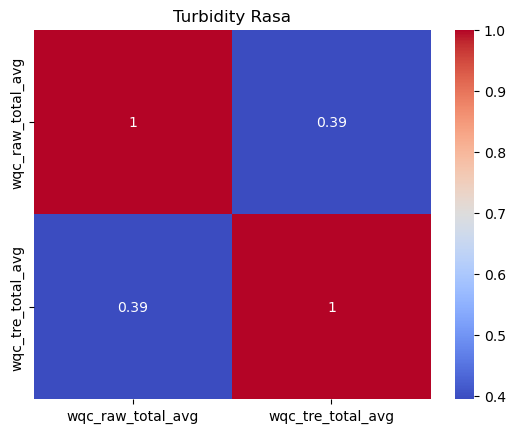

<AxesSubplot:title={'center':'Turbidity Rantau Panjang New'}, xlabel='TestDate'>

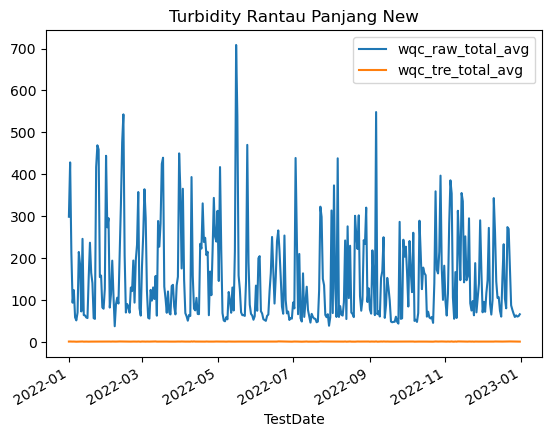

<AxesSubplot:>

Text(0.5, 1.0, 'Turbidity Rantau Panjang New')

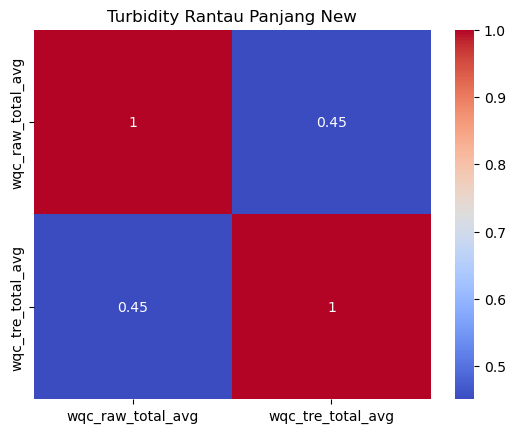

<AxesSubplot:title={'center':'Turbidity Batang Kali'}, xlabel='TestDate'>

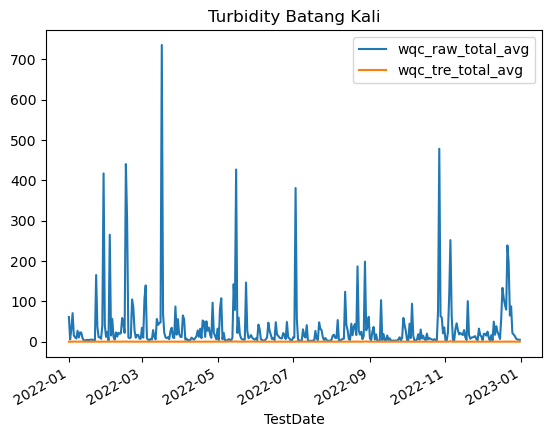

<AxesSubplot:>

Text(0.5, 1.0, 'Turbidity Batang Kali')

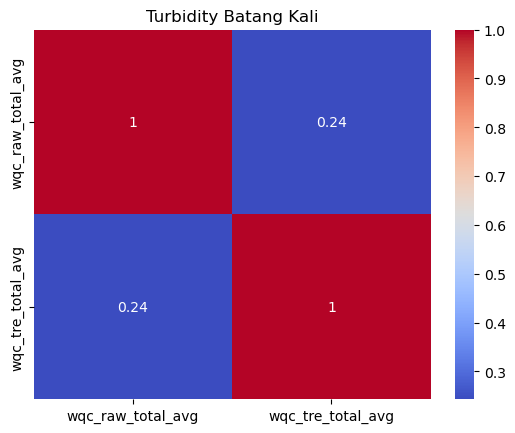

<AxesSubplot:title={'center':'Turbidity Sungai Rangkap'}, xlabel='TestDate'>

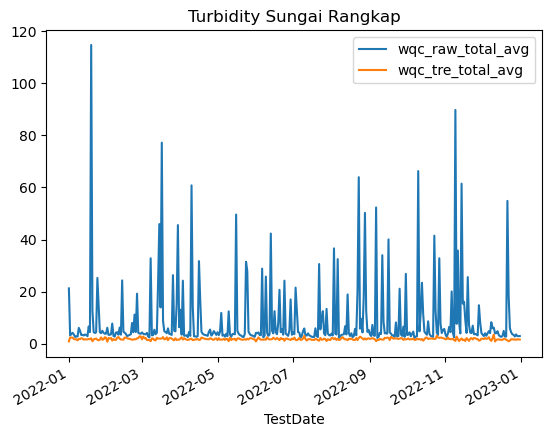

<AxesSubplot:>

Text(0.5, 1.0, 'Turbidity Sungai Rangkap')

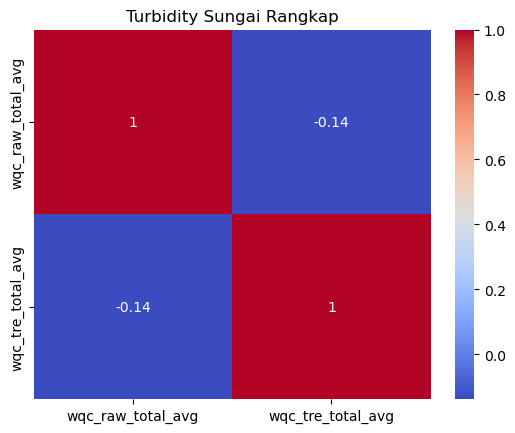

<AxesSubplot:title={'center':'Ferum/Iron (Fe) Sungai Selangor Fasa 3'}, xlabel='TestDate'>

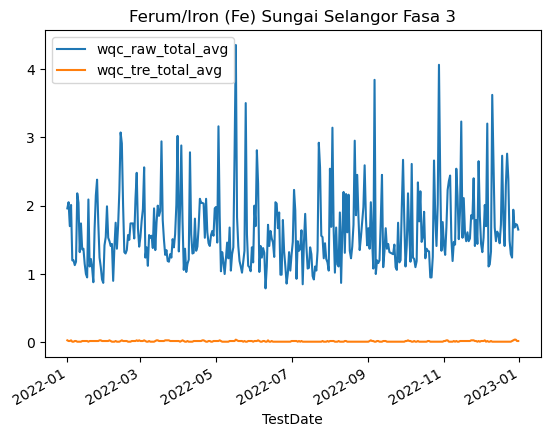

<AxesSubplot:>

Text(0.5, 1.0, 'Ferum/Iron (Fe) Sungai Selangor Fasa 3')

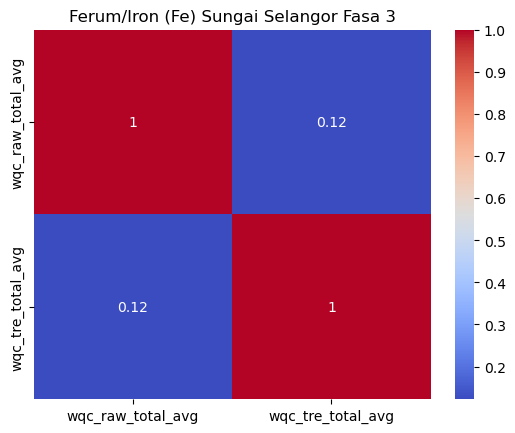

<AxesSubplot:title={'center':'Ferum/Iron (Fe) Sungai Selangor Fasa 1'}, xlabel='TestDate'>

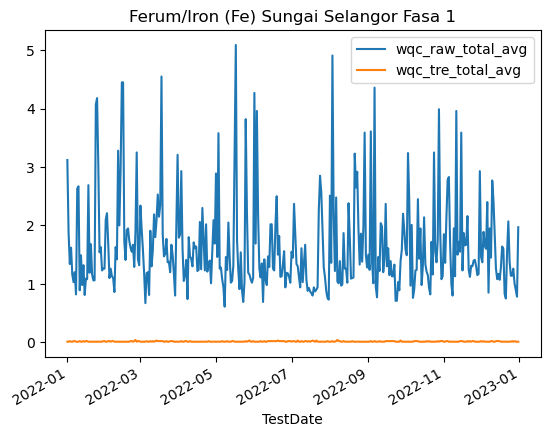

<AxesSubplot:>

Text(0.5, 1.0, 'Ferum/Iron (Fe) Sungai Selangor Fasa 1')

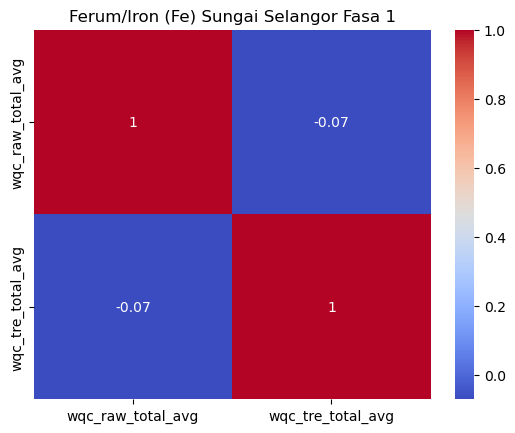

<AxesSubplot:title={'center':'Ferum/Iron (Fe) Sungai Selangor Fasa 2 Stream C'}, xlabel='TestDate'>

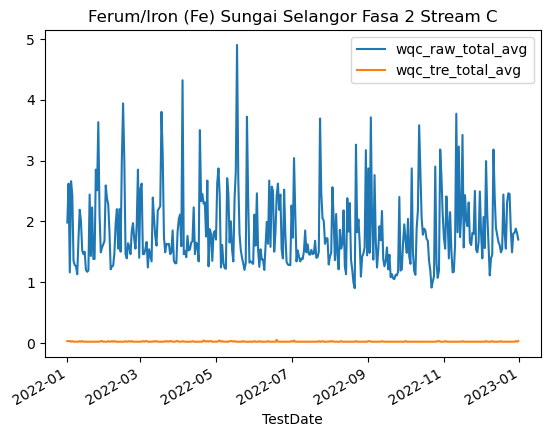

<AxesSubplot:>

Text(0.5, 1.0, 'Ferum/Iron (Fe) Sungai Selangor Fasa 2 Stream C')

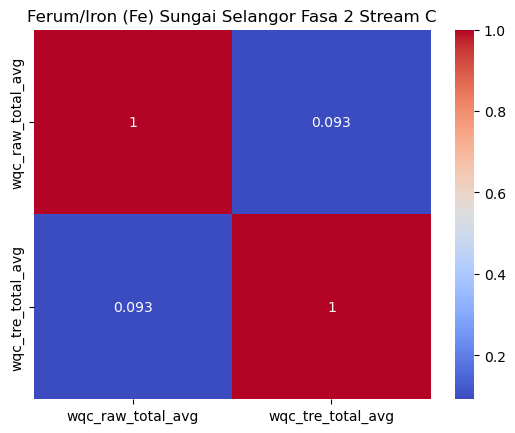

<AxesSubplot:title={'center':'Ferum/Iron (Fe) Kuala Kubu Bharu'}, xlabel='TestDate'>

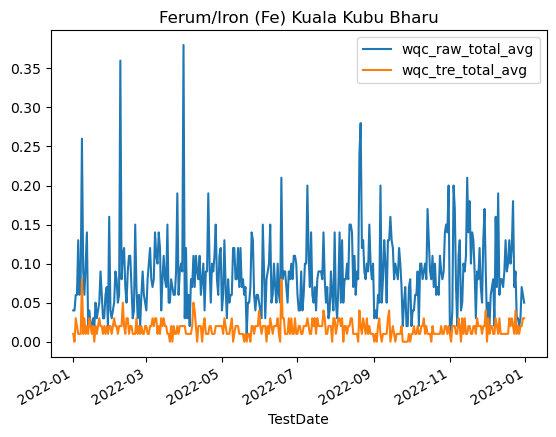

<AxesSubplot:>

Text(0.5, 1.0, 'Ferum/Iron (Fe) Kuala Kubu Bharu')

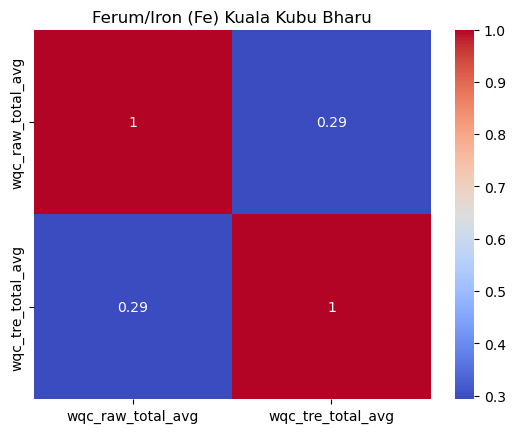

<AxesSubplot:title={'center':'Ferum/Iron (Fe) Rasa'}, xlabel='TestDate'>

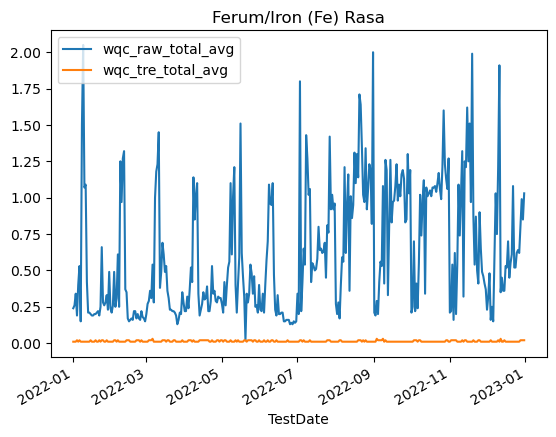

<AxesSubplot:>

Text(0.5, 1.0, 'Ferum/Iron (Fe) Rasa')

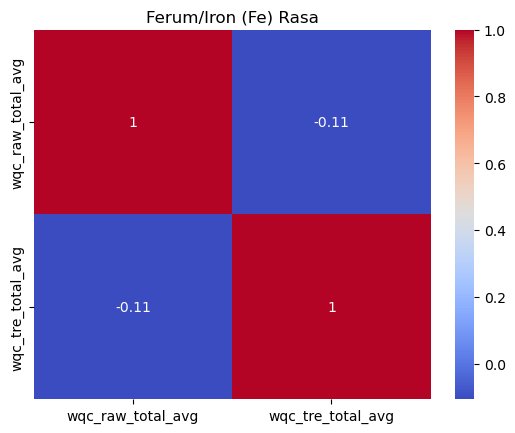

<AxesSubplot:title={'center':'Ferum/Iron (Fe) Rantau Panjang New'}, xlabel='TestDate'>

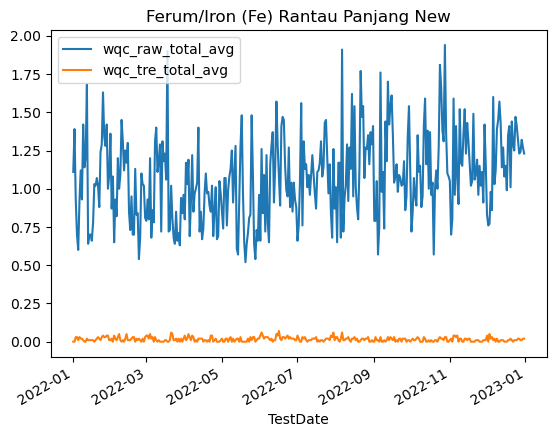

<AxesSubplot:>

Text(0.5, 1.0, 'Ferum/Iron (Fe) Rantau Panjang New')

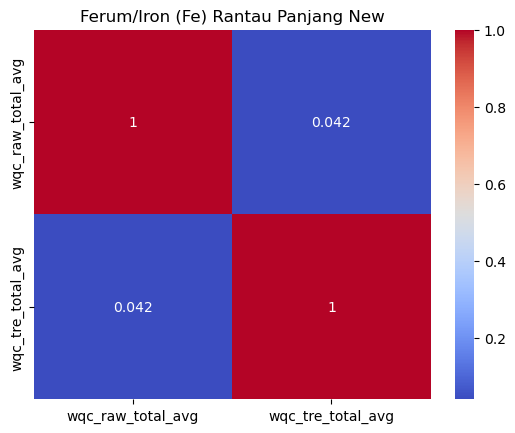

<AxesSubplot:title={'center':'Ferum/Iron (Fe) Batang Kali'}, xlabel='TestDate'>

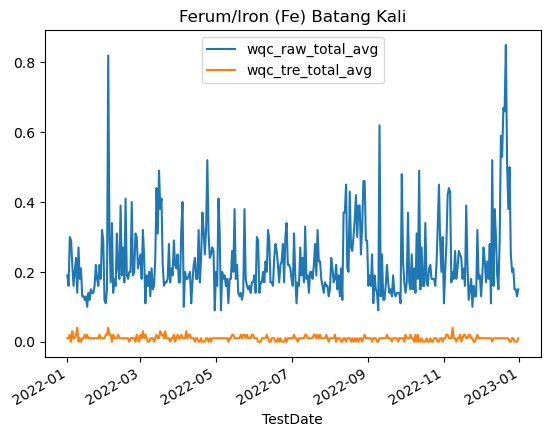

<AxesSubplot:>

Text(0.5, 1.0, 'Ferum/Iron (Fe) Batang Kali')

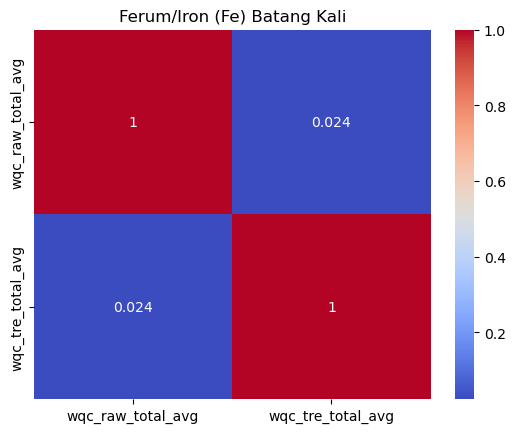

<AxesSubplot:title={'center':'Ferum/Iron (Fe) Sungai Rangkap'}, xlabel='TestDate'>

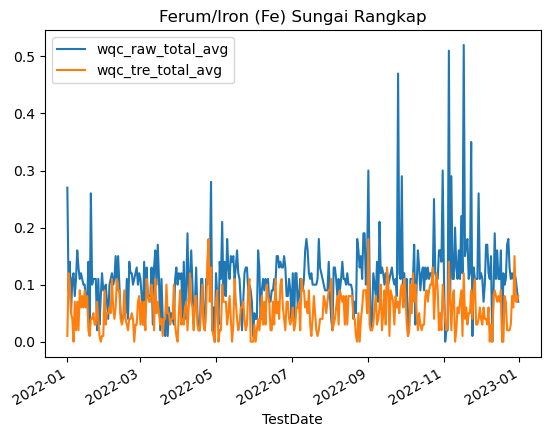

<AxesSubplot:>

Text(0.5, 1.0, 'Ferum/Iron (Fe) Sungai Rangkap')

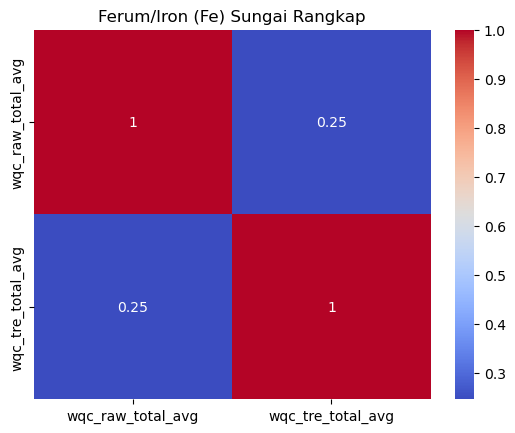

<AxesSubplot:title={'center':'Ammonia (NH4) Sungai Selangor Fasa 3'}, xlabel='TestDate'>

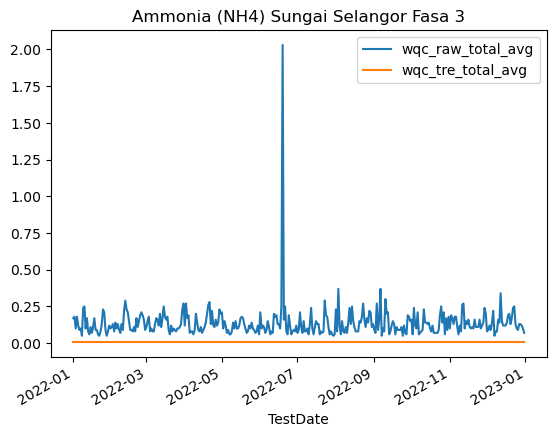

<AxesSubplot:>

Text(0.5, 1.0, 'Ammonia (NH4) Sungai Selangor Fasa 3')

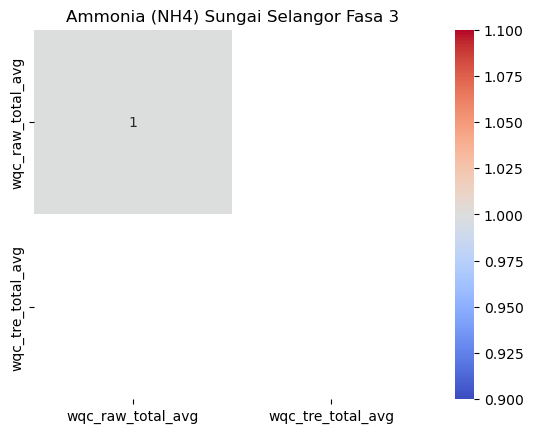

<AxesSubplot:title={'center':'Ammonia (NH4) Sungai Selangor Fasa 1'}, xlabel='TestDate'>

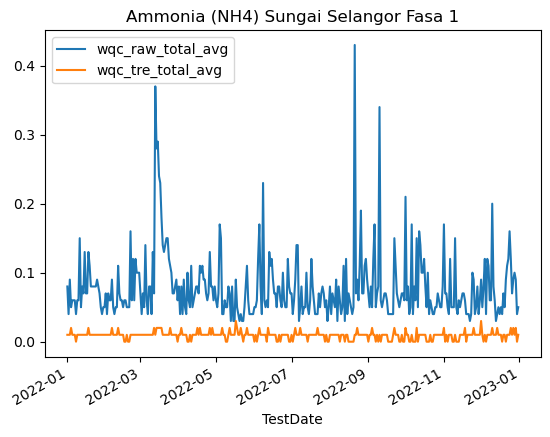

<AxesSubplot:>

Text(0.5, 1.0, 'Ammonia (NH4) Sungai Selangor Fasa 1')

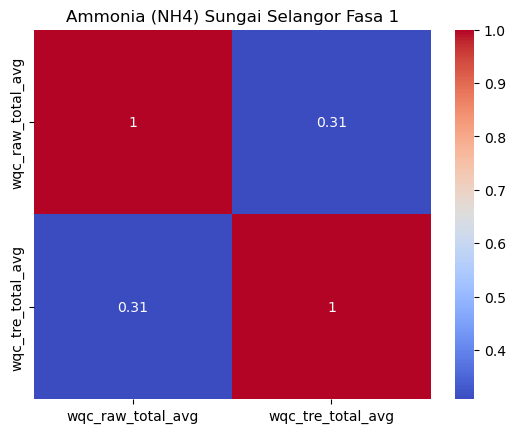

<AxesSubplot:title={'center':'Ammonia (NH4) Sungai Selangor Fasa 2 Stream C'}, xlabel='TestDate'>

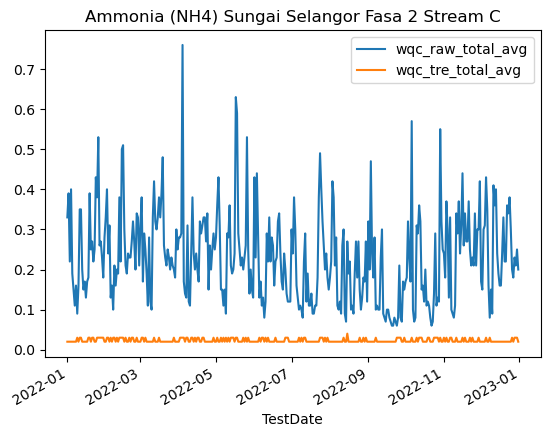

<AxesSubplot:>

Text(0.5, 1.0, 'Ammonia (NH4) Sungai Selangor Fasa 2 Stream C')

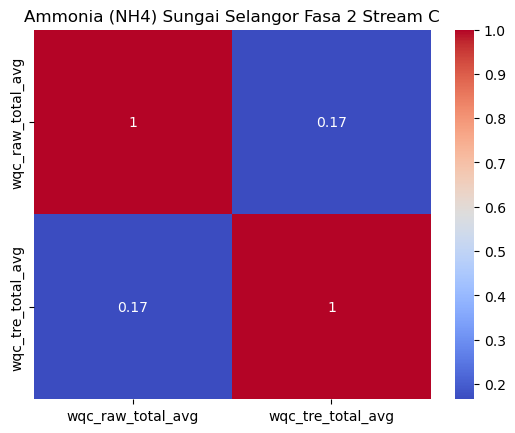

<AxesSubplot:title={'center':'Ammonia (NH4) Kuala Kubu Bharu'}, xlabel='TestDate'>

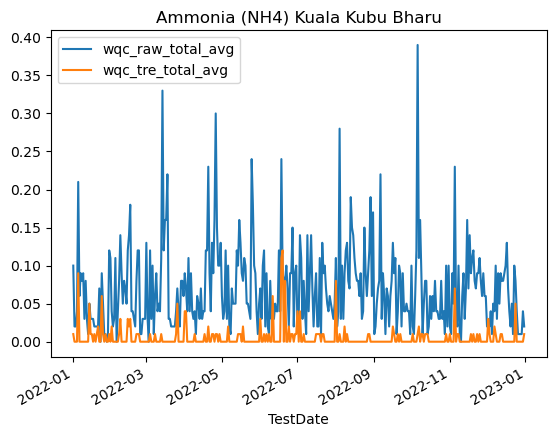

<AxesSubplot:>

Text(0.5, 1.0, 'Ammonia (NH4) Kuala Kubu Bharu')

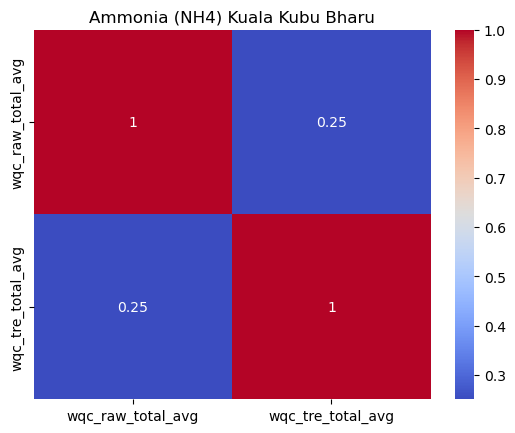

<AxesSubplot:title={'center':'Ammonia (NH4) Rasa'}, xlabel='TestDate'>

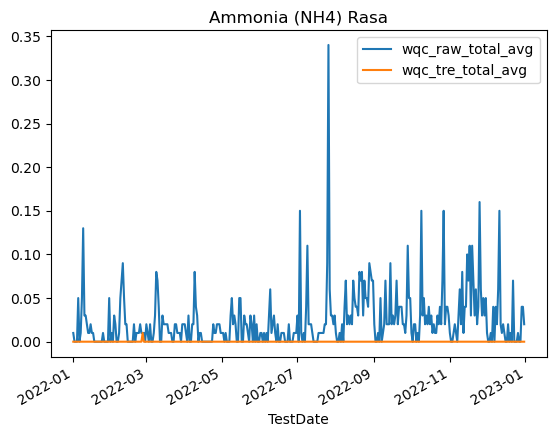

<AxesSubplot:>

Text(0.5, 1.0, 'Ammonia (NH4) Rasa')

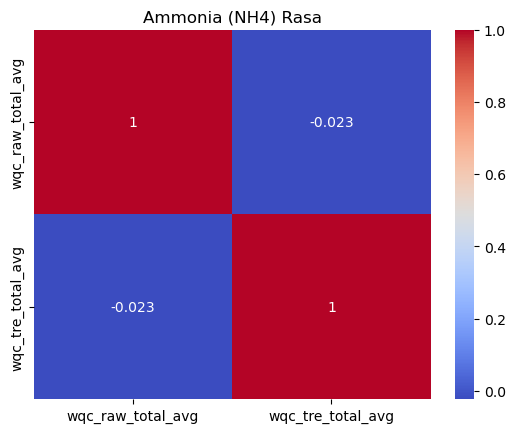

<AxesSubplot:title={'center':'Ammonia (NH4) Rantau Panjang New'}, xlabel='TestDate'>

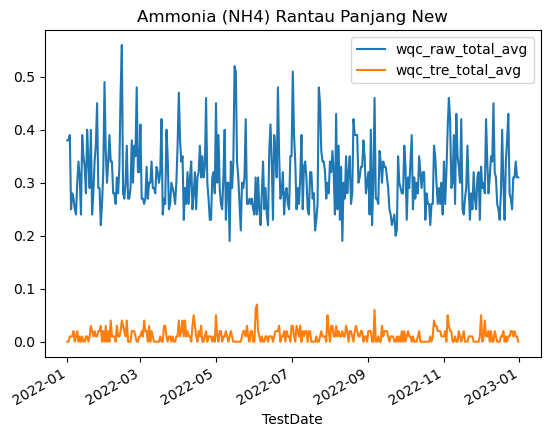

<AxesSubplot:>

Text(0.5, 1.0, 'Ammonia (NH4) Rantau Panjang New')

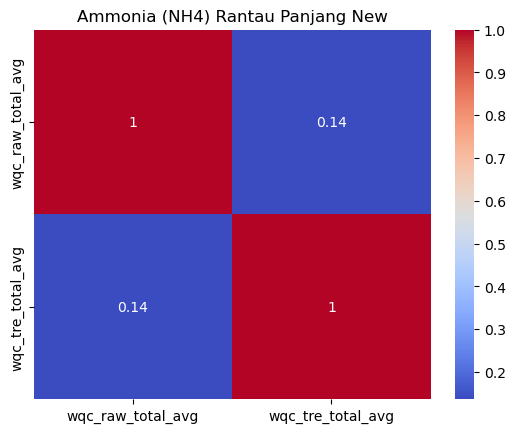

<AxesSubplot:title={'center':'Ammonia (NH4) Batang Kali'}, xlabel='TestDate'>

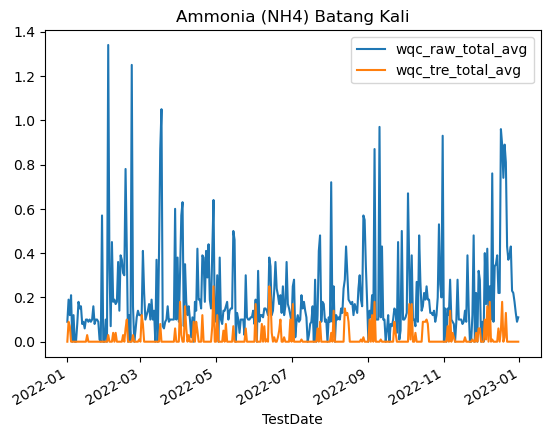

<AxesSubplot:>

Text(0.5, 1.0, 'Ammonia (NH4) Batang Kali')

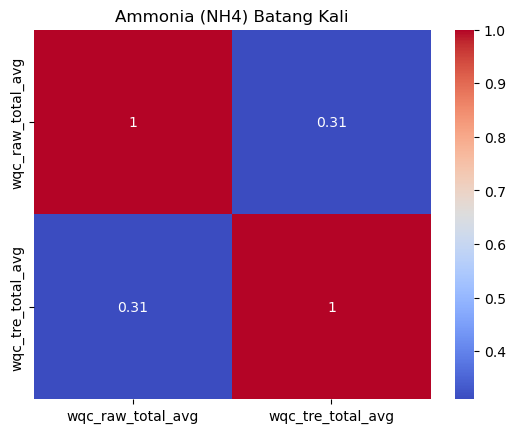

<AxesSubplot:title={'center':'Ammonia (NH4) Sungai Rangkap'}, xlabel='TestDate'>

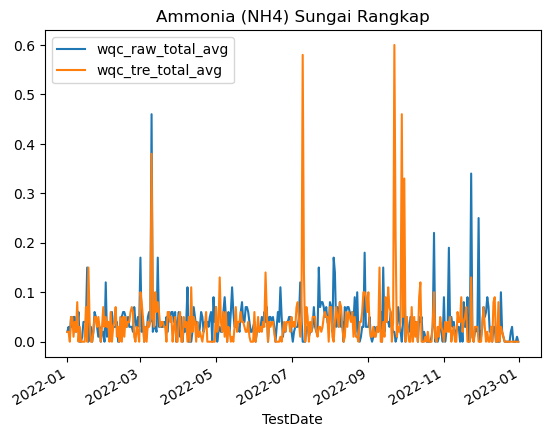

<AxesSubplot:>

Text(0.5, 1.0, 'Ammonia (NH4) Sungai Rangkap')

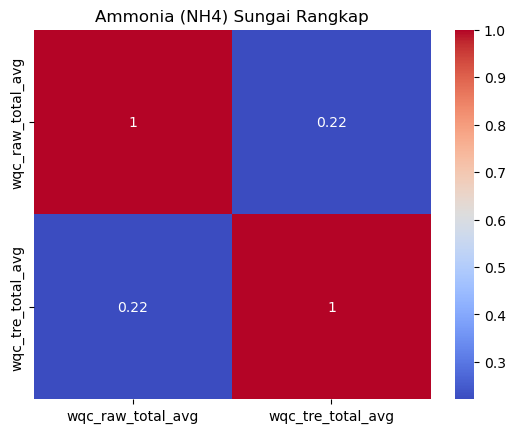

<AxesSubplot:title={'center':'Manganese (Mn) Sungai Selangor Fasa 3'}, xlabel='TestDate'>

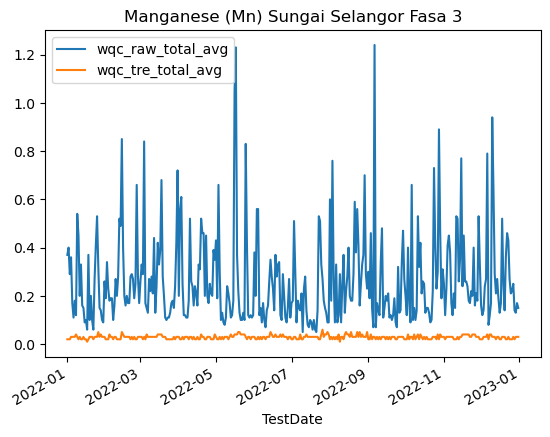

<AxesSubplot:>

Text(0.5, 1.0, 'Manganese (Mn) Sungai Selangor Fasa 3')

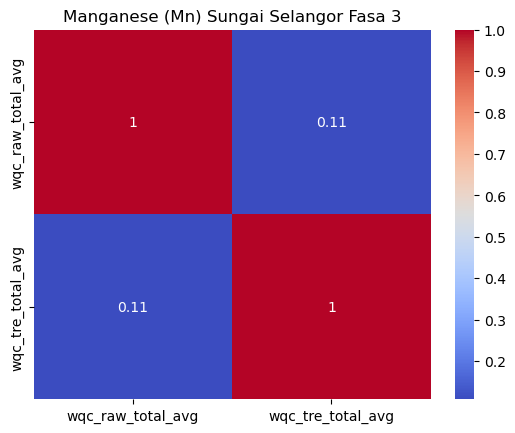

<AxesSubplot:title={'center':'Manganese (Mn) Sungai Selangor Fasa 1'}, xlabel='TestDate'>

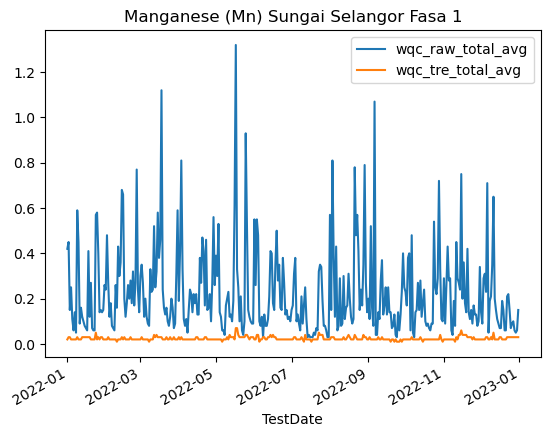

<AxesSubplot:>

Text(0.5, 1.0, 'Manganese (Mn) Sungai Selangor Fasa 1')

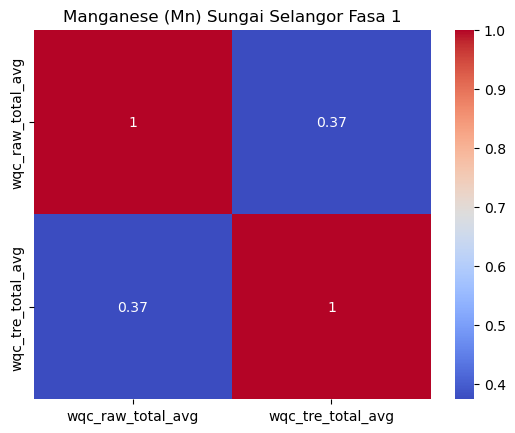

<AxesSubplot:title={'center':'Manganese (Mn) Sungai Selangor Fasa 2 Stream C'}, xlabel='TestDate'>

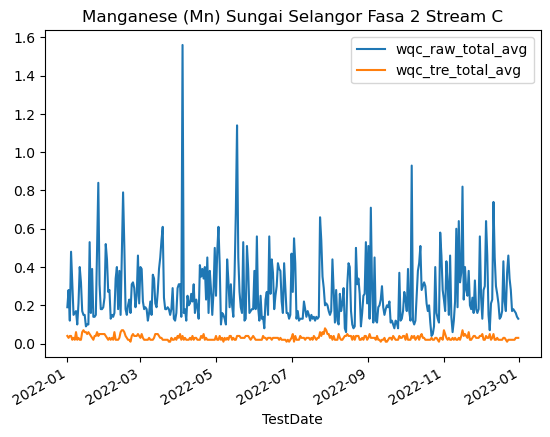

<AxesSubplot:>

Text(0.5, 1.0, 'Manganese (Mn) Sungai Selangor Fasa 2 Stream C')

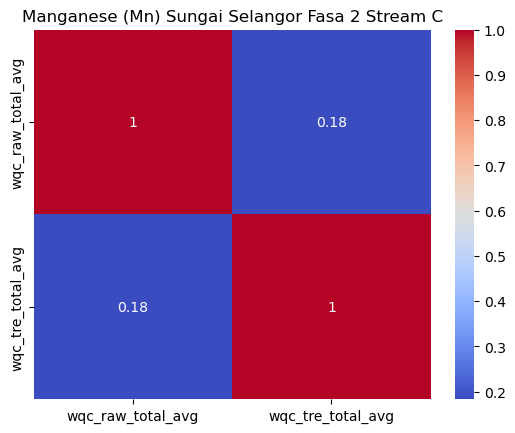

<AxesSubplot:title={'center':'Manganese (Mn) Kuala Kubu Bharu'}, xlabel='TestDate'>

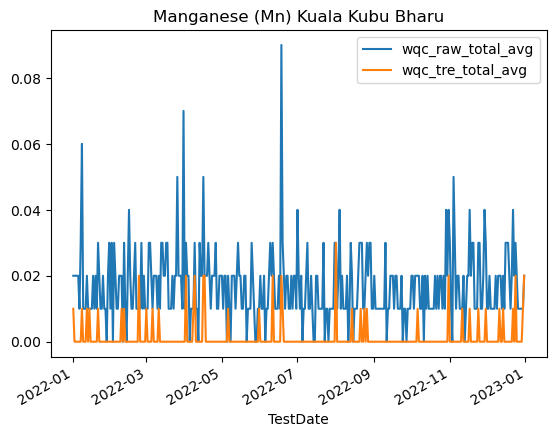

<AxesSubplot:>

Text(0.5, 1.0, 'Manganese (Mn) Kuala Kubu Bharu')

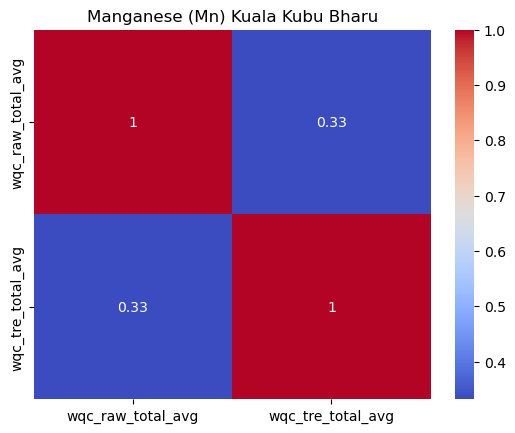

<AxesSubplot:title={'center':'Manganese (Mn) Rasa'}, xlabel='TestDate'>

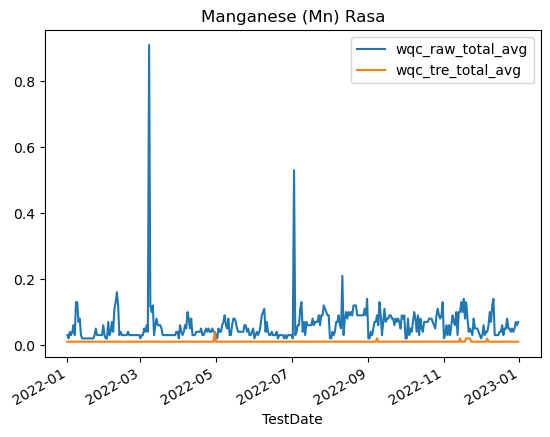

<AxesSubplot:>

Text(0.5, 1.0, 'Manganese (Mn) Rasa')

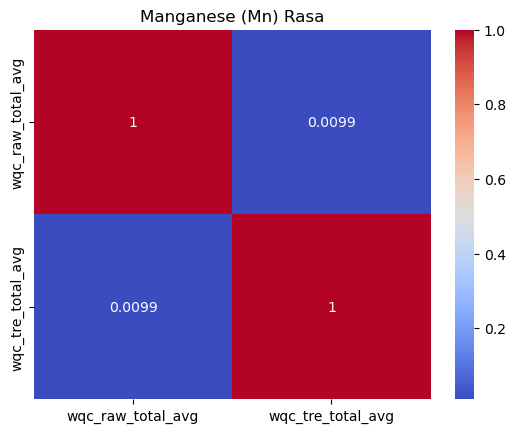

<AxesSubplot:title={'center':'Manganese (Mn) Rantau Panjang New'}, xlabel='TestDate'>

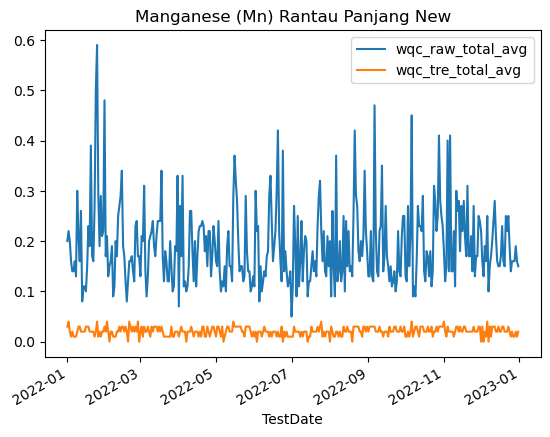

<AxesSubplot:>

Text(0.5, 1.0, 'Manganese (Mn) Rantau Panjang New')

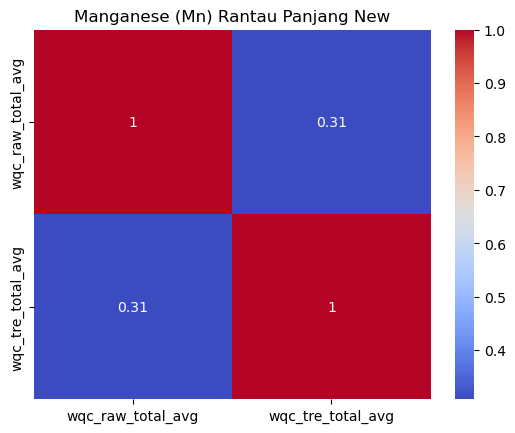

<AxesSubplot:title={'center':'Manganese (Mn) Batang Kali'}, xlabel='TestDate'>

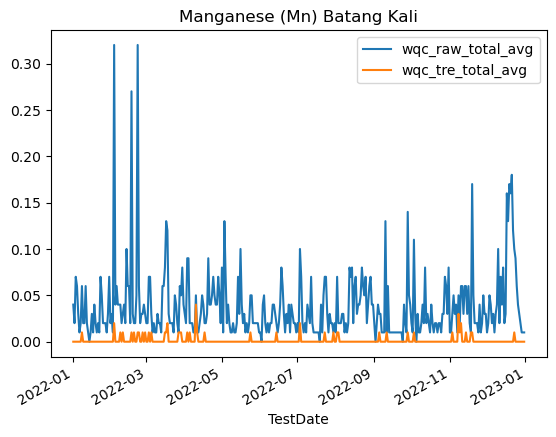

<AxesSubplot:>

Text(0.5, 1.0, 'Manganese (Mn) Batang Kali')

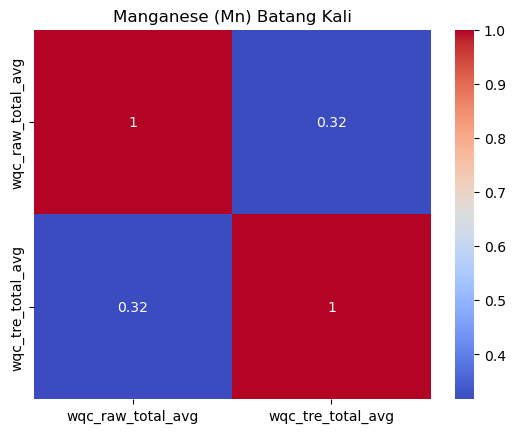

<AxesSubplot:title={'center':'Manganese (Mn) Sungai Rangkap'}, xlabel='TestDate'>

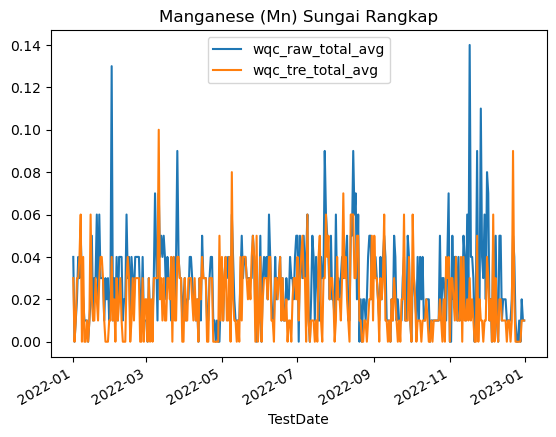

<AxesSubplot:>

Text(0.5, 1.0, 'Manganese (Mn) Sungai Rangkap')

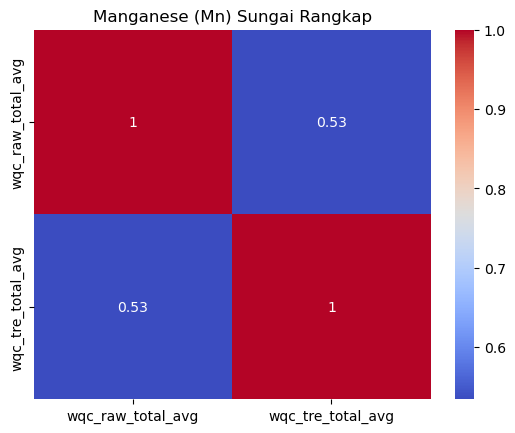

In [173]:
for i in treated_vs_raw_pd['metrix'].unique():
    for j in treated_vs_raw_pd['wtp'].unique():
        treated_vs_raw_pd[(treated_vs_raw_pd['metrix'] == i) & (treated_vs_raw_pd['wtp'] == j) ].plot(x='TestDate',y=['wqc_raw_total_avg','wqc_tre_total_avg'],title = i + ' '+ j)
        plt.show()
        core = treated_vs_raw_pd[(treated_vs_raw_pd['metrix'] == i) & (treated_vs_raw_pd['wtp'] == j)][['wqc_raw_total_avg','wqc_tre_total_avg']].corr()
        sns.heatmap(core, annot=True, cmap='coolwarm')
        plt.title(i + ' ' + j)
        plt.show()

In [ ]:
plot()